# a1901457_assignmnet3

# Optimizing Recurrent Neural Networks for stock prediction

In [ ]:
# Dataset downloading
import os
import zipfile

 # Suppress warnings
import warnings
warnings.filterwarnings("ignore") 

# Set the random seed for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)


# mathematical operations
import numpy as np
import pandas as pd
import random
from math import sqrt
from sklearn.metrics import mean_squared_error

# visualisation
import matplotlib.pyplot as plt

# data processing
from sklearn.preprocessing import MinMaxScaler

# model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Dense
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import optuna
from itertools import product


In [6]:
# Path to the uploaded file
uploaded_file_path = 'archive.zip'
extract_path = 'extracted_dataset/'

# Extract the contents of the zip file
with zipfile.ZipFile(uploaded_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# contents of the extracted directory for better understanding its structure
os.listdir(extract_path)


['Google_Stock_Price_Test.csv', 'Google_Stock_Price_Train.csv']

In [7]:
# Load the datasets
train_data_path = os.path.join(extract_path, 'Google_Stock_Price_Train.csv')
test_data_path = os.path.join(extract_path, 'Google_Stock_Price_Test.csv')

train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)

# Train dataset

In [ ]:
print("Train dataset\n",train_data.head())

# There is a comma in the volume which affects the datatype 

Train dataset
        Date    Open    High     Low   Close      Volume
0  1/3/2012  325.25  332.83  324.97  663.59   7,380,500
1  1/4/2012  331.27  333.87  329.08  666.45   5,749,400
2  1/5/2012  329.83  330.75  326.89  657.21   6,590,300
3  1/6/2012  328.34  328.77  323.68  648.24   5,405,900
4  1/9/2012  322.04  322.29  309.46  620.76  11,688,800


In [9]:
# Verifing the data types and checking for missing values 
train_missing = train_data.isnull().sum()

print("Train set:\n",train_missing)


Train set:
 Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64


In [ ]:
print("Train dataset\n")
train_data.info()

Train dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1258 non-null   object 
 1   Open    1258 non-null   float64
 2   High    1258 non-null   float64
 3   Low     1258 non-null   float64
 4   Close   1258 non-null   object 
 5   Volume  1258 non-null   object 
dtypes: float64(3), object(3)
memory usage: 59.1+ KB


In [11]:
# Data cleaning - Changing the catogorical dtatype to numerical datatype
train_data['Date']=pd.to_datetime(train_data['Date'])
train_data['Volume'] = train_data['Volume'].str.replace(',', '').astype(float)
train_data['Close'] = train_data['Close'].str.replace(',', '').astype(float)


In [13]:
print("Train dataset after cleaning\n")
train_data.info()

Train dataset after cleaning

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1258 non-null   datetime64[ns]
 1   Open    1258 non-null   float64       
 2   High    1258 non-null   float64       
 3   Low     1258 non-null   float64       
 4   Close   1258 non-null   float64       
 5   Volume  1258 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 59.1 KB


# Test dataset

In [14]:
print("Test dataset\n",test_data.head())

# There is a comma in the volume which affects the datatype 

Test dataset
        Date    Open    High     Low   Close     Volume
0  1/3/2017  778.81  789.63  775.80  786.14  1,657,300
1  1/4/2017  788.36  791.34  783.16  786.90  1,073,000
2  1/5/2017  786.08  794.48  785.02  794.02  1,335,200
3  1/6/2017  795.26  807.90  792.20  806.15  1,640,200
4  1/9/2017  806.40  809.97  802.83  806.65  1,272,400


In [15]:
#  checking for missing values
test_missing = test_data.isnull().sum()
print("Test set:\n",test_missing)

Test set:
 Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64


In [16]:
print("Test dataset\n")
test_data.info()

Test dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    20 non-null     object 
 1   Open    20 non-null     float64
 2   High    20 non-null     float64
 3   Low     20 non-null     float64
 4   Close   20 non-null     float64
 5   Volume  20 non-null     object 
dtypes: float64(4), object(2)
memory usage: 1.1+ KB


In [17]:
# Data cleaning - Changing the catogorical dtatype to numerical datatype

test_data['Date']=pd.to_datetime(test_data['Date'])
test_data.set_index('Date',drop=True,inplace=True)
test_data['Volume'] = test_data['Volume'].str.replace(',', '').astype(float)

In [18]:
print("Test dataset after cleaing\n")
test_data.info()

Test dataset after cleaing

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20 entries, 2017-01-03 to 2017-01-31
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    20 non-null     float64
 1   High    20 non-null     float64
 2   Low     20 non-null     float64
 3   Close   20 non-null     float64
 4   Volume  20 non-null     float64
dtypes: float64(5)
memory usage: 960.0 bytes


# Visualisation

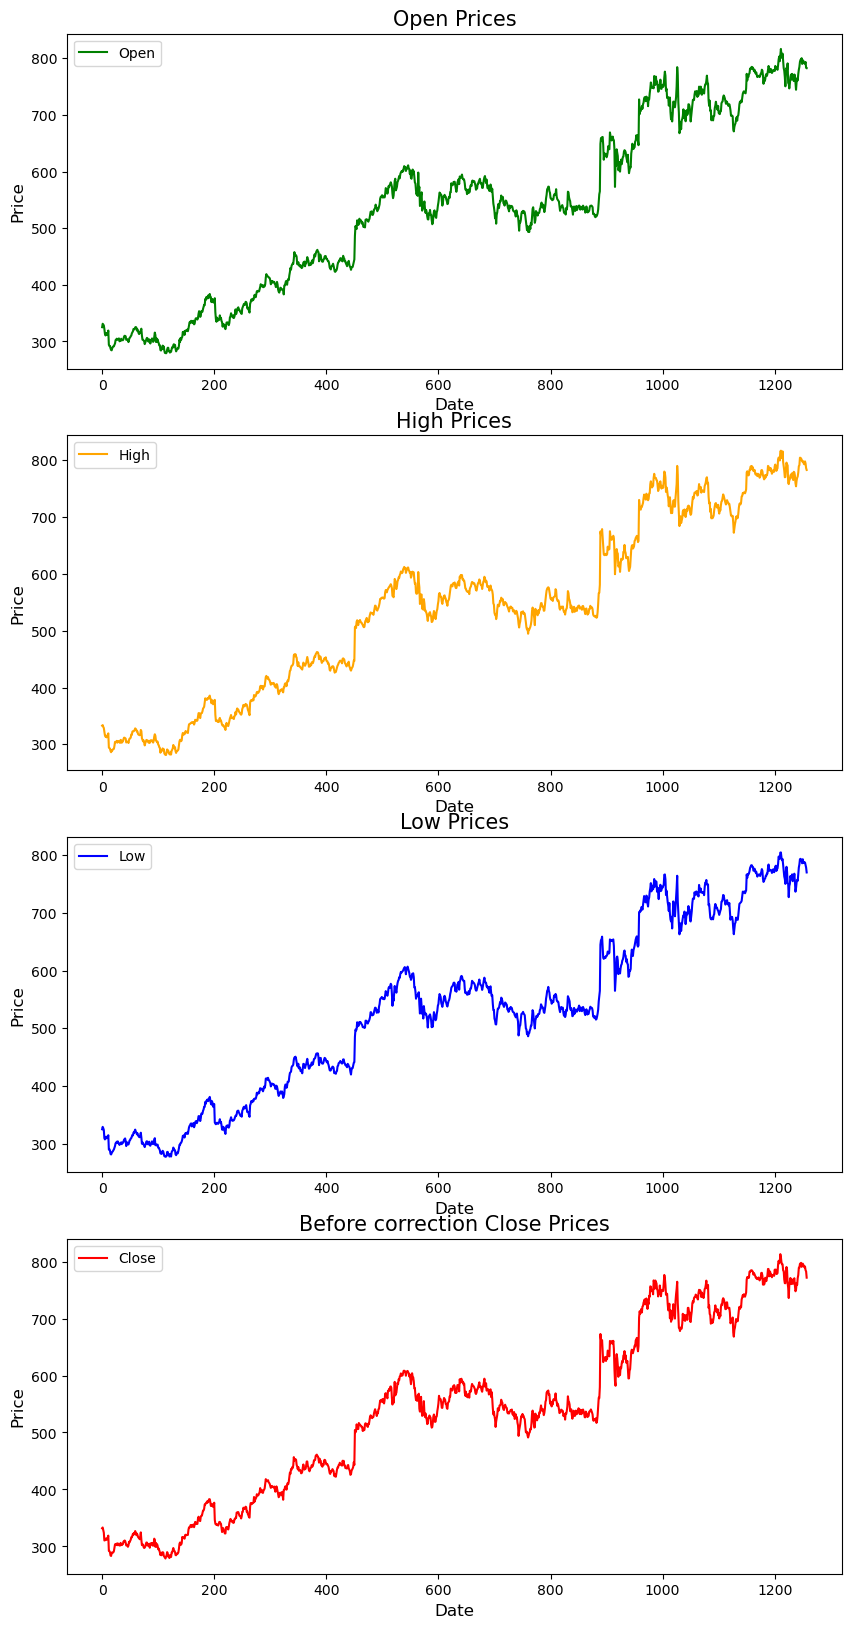

In [ ]:
fig, axs = plt.subplots(4, 1, figsize=(10, 20))

# Plot 'Open'
axs[0].plot(train_data['Open'], label='Open', color='green')
axs[0].set_title('Open Prices', size=15)
axs[0].set_xlabel('Date', size=12)
axs[0].set_ylabel('Price', size=12)
axs[0].legend()

# Plot 'High'
axs[1].plot(train_data['High'], label='High', color='orange')
axs[1].set_title('High Prices', size=15)
axs[1].set_xlabel('Date', size=12)
axs[1].set_ylabel('Price', size=12)
axs[1].legend()

# Plot 'Low'
axs[2].plot(train_data['Low'], label='Low', color='blue')
axs[2].set_title('Low Prices', size=15)
axs[2].set_xlabel('Date', size=12)
axs[2].set_ylabel('Price', size=12)
axs[2].legend()

# Plot 'Close'
axs[3].plot(train_data['Close'], label='Close', color='red')
axs[3].set_title('Before correction Close Prices', size=15)
axs[3].set_xlabel('Date', size=12)
axs[3].set_ylabel('Price', size=12)
axs[3].legend()

plt.show()


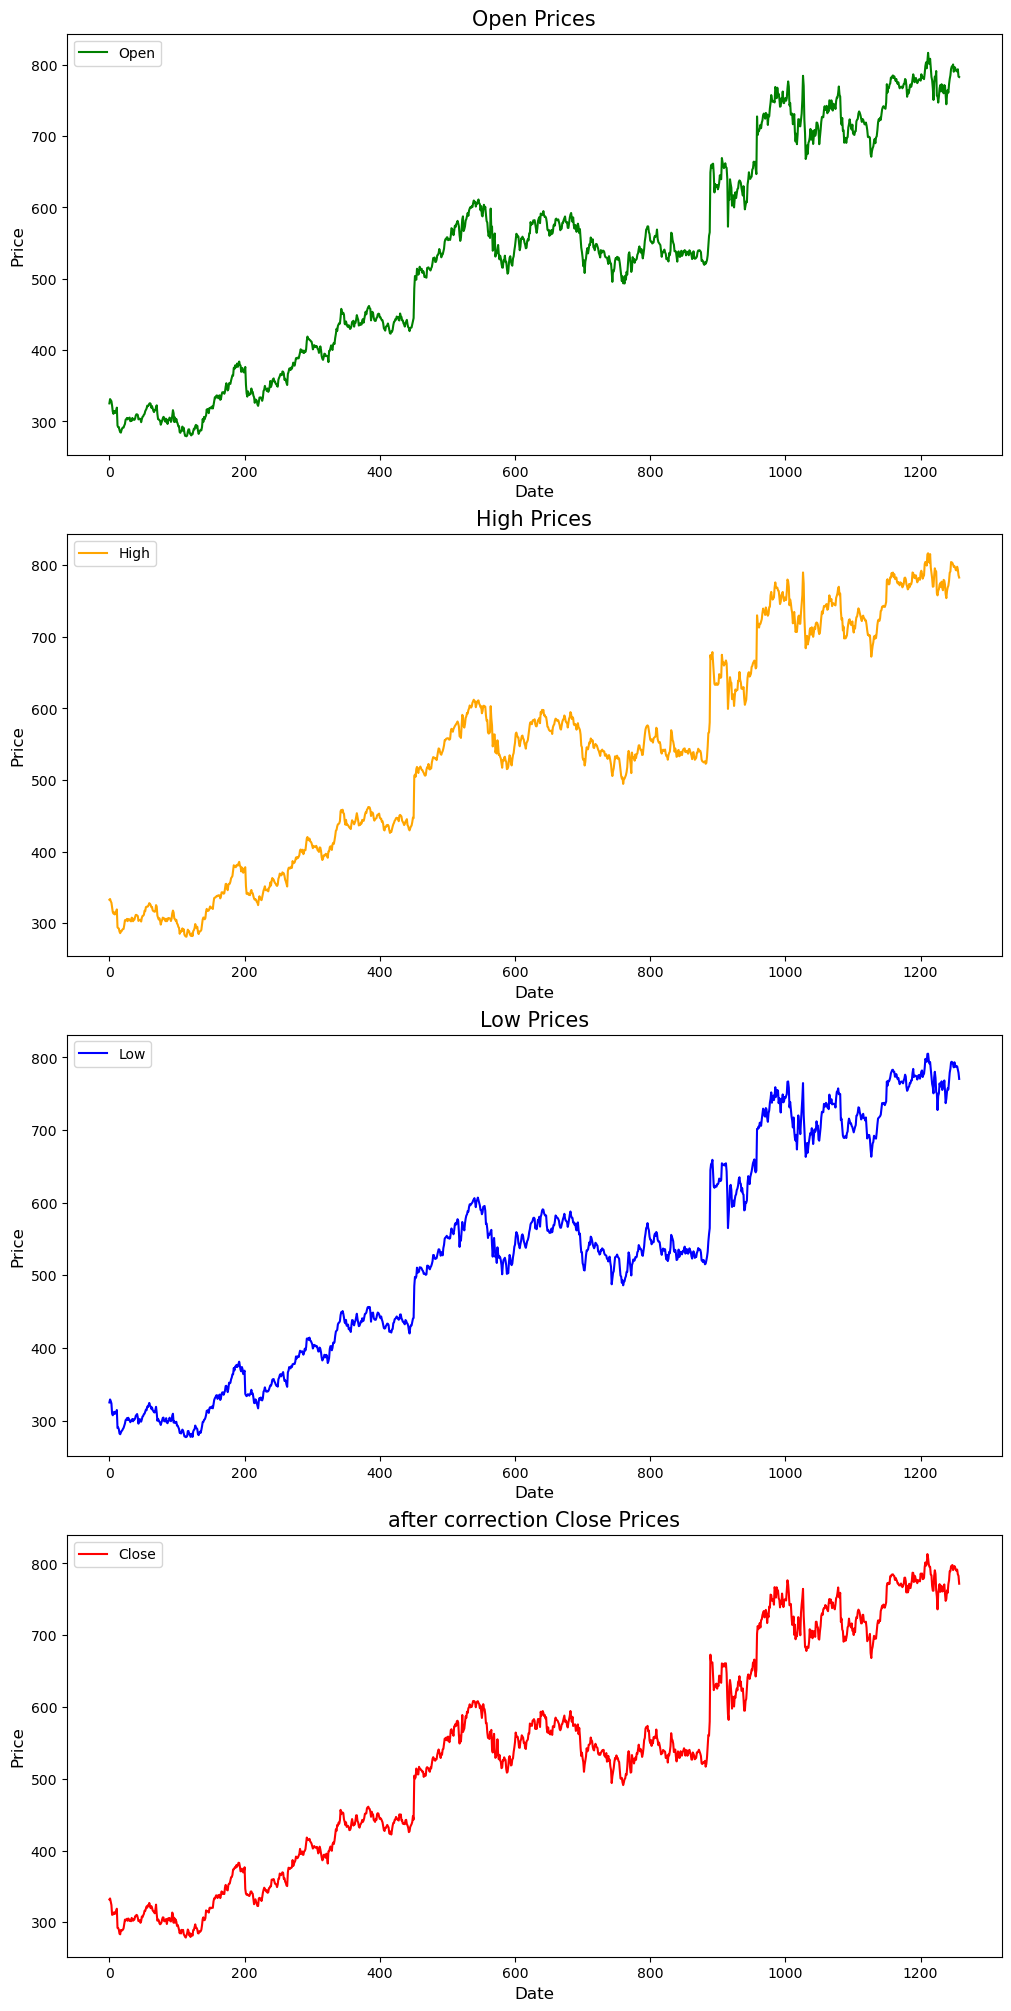

In [20]:
train_data['Close'] = train_data.apply(lambda x: x['Close']/2 if x['Close'] > x['High'] else x['Close'], axis=1)

fig, axs = plt.subplots(4, 1, figsize=(10, 20), constrained_layout=True)

# Plot 'Open'
axs[0].plot(train_data['Open'], label='Open', color='green')
axs[0].set_title('Open Prices', size=15)
axs[0].set_xlabel('Date', size=12)
axs[0].set_ylabel('Price', size=12)
axs[0].legend()

# Plot 'High'
axs[1].plot(train_data['High'], label='High', color='orange')
axs[1].set_title('High Prices', size=15)
axs[1].set_xlabel('Date', size=12)
axs[1].set_ylabel('Price', size=12)
axs[1].legend()

# Plot 'Low'
axs[2].plot(train_data['Low'], label='Low', color='blue')
axs[2].set_title('Low Prices', size=15)
axs[2].set_xlabel('Date', size=12)
axs[2].set_ylabel('Price', size=12)
axs[2].legend()

# Plot 'Close'
axs[3].plot(train_data['Close'], label='Close', color='red')
axs[3].set_title('after correction Close Prices', size=15)
axs[3].set_xlabel('Date', size=12)
axs[3].set_ylabel('Price', size=12)
axs[3].legend()

plt.show()

# used for elimination anomalies data from the close feature which is used during multivaraite model experiment 

# Data preprocessing -  splitting

In [ ]:
# splitting the data into 80-20 on the original train dataset
train_size_original = int(0.8 * len(train_data))
train_set = train_data[:train_size_original]
validation_set = train_data[train_size_original:]

# Display the training and validation sets
print("Training Set:")
print(train_set.head())

print("\nValidation Set:")
print(validation_set.head())



Training Set:
        Date    Open    High     Low    Close      Volume
0 2012-01-03  325.25  332.83  324.97  331.795   7380500.0
1 2012-01-04  331.27  333.87  329.08  333.225   5749400.0
2 2012-01-05  329.83  330.75  326.89  328.605   6590300.0
3 2012-01-06  328.34  328.77  323.68  324.120   5405900.0
4 2012-01-09  322.04  322.29  309.46  310.380  11688800.0

Validation Set:
           Date    Open    High     Low   Close     Volume
1006 2016-01-04  743.00  744.06  731.26  741.84  3272800.0
1007 2016-01-05  746.45  752.00  738.64  742.58  1950700.0
1008 2016-01-06  730.00  747.18  728.92  743.62  1947000.0
1009 2016-01-07  730.31  738.50  719.06  726.39  2963700.0
1010 2016-01-08  731.45  733.23  713.00  714.47  2450900.0


In [ ]:
# shapes of train, validation, and test datasets
train_set.shape, validation_set.shape, test_data.shape

((1006, 6), (252, 6), (20, 5))

# Data preprocessing - Normalisation 

In [ ]:
# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Apply normalization to the numerical columns in the datasets
columns_to_normalize = ['Open', 'High', 'Low', 'Close', 'Volume']

# Reapply normalization directly to the datasets
train_set[columns_to_normalize] = scaler.fit_transform(train_set[columns_to_normalize])
validation_set[columns_to_normalize] = scaler.transform(validation_set[columns_to_normalize])
test_data[columns_to_normalize] = scaler.transform(test_data[columns_to_normalize])

# Display the normalized datasets
print("train_set_normalize\n",train_set.head())
print("\n")
print("validation_set_normalized\n",validation_set.head()) 
print("\n")
print("test_set_normalized\n",test_data.head())


train_set_normalize
         Date      Open      High       Low     Close    Volume
0 2012-01-03  0.092727  0.103495  0.097513  0.106530  0.295258
1 2012-01-04  0.104828  0.105580  0.105906  0.109403  0.229936
2 2012-01-05  0.101934  0.099324  0.101434  0.100123  0.263612
3 2012-01-06  0.098939  0.095355  0.094878  0.091114  0.216179
4 2012-01-09  0.086275  0.082363  0.065839  0.063514  0.467797


validation_set_normalized
            Date      Open      High       Low     Close    Volume
1006 2016-01-04  0.932460  0.927983  0.927218  0.930178  0.130753
1007 2016-01-05  0.939395  0.943902  0.942289  0.931665  0.077805
1008 2016-01-06  0.906328  0.934238  0.922439  0.933754  0.077657
1009 2016-01-07  0.906951  0.916835  0.902304  0.899144  0.118374
1010 2016-01-08  0.909243  0.906269  0.889928  0.875201  0.097837


test_set_normalized
                 Open      High       Low     Close    Volume
Date                                                        
2017-01-03  1.004442  1.019348 

# Univariate

# 1. LSTM Baseline

In [ ]:
# Number of past days
N = 30  
# Number of future days (predict the next day)
M = 1   

# sequence creation for preparing the dataset using Open feature (univariate)
def create_sequences(data, N, M):
    X, y = [], []
    for i in range(len(data) - N - M + 1):
        X.append(data[i:i+N])  # Past N days (input)
        y.append(data[i+N:i+N+M])  # Next M days (output: single feature)
    return np.array(X), np.array(y)


In [ ]:
# Extracting only 'Open' column for univariate prediction
train_data = train_set[['Open']].values
val_data = validation_set[['Open']].values

# Create sequences for training and validation data
X_train, y_train = create_sequences(train_data, N, M)
X_val, y_val = create_sequences(val_data, N, M)

# Reshape input to 3D for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))  
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))  

print(f"Training data shape: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Validation data shape: X_val={X_val.shape}, y_val={y_val.shape}")

# Build the LSTM model single layer model
regressor = Sequential()
regressor.add(LSTM(units=5, input_shape=(X_train.shape[1], 1)))
regressor.add(Dense(units=M))  
regressor.compile(optimizer='adam', loss='mean_squared_error')

# Training the model
history = regressor.fit(X_train, y_train, 
                        epochs=50, batch_size=32,
                        validation_data=(X_val, y_val),
                        verbose=1)

# Evaluation on validation data
val_predictions = regressor.predict(X_val)
y_val_flattened = y_val.flatten()
val_predictions_flattened = val_predictions.flatten()

# RMSE
val_rmse = sqrt(mean_squared_error(y_val_flattened, val_predictions_flattened))
print(f"Validation RMSE: {val_rmse:.4f}")

Training data shape: X_train=(976, 30, 1), y_train=(976, 1, 1)
Validation data shape: X_val=(222, 30, 1), y_val=(222, 1, 1)
Epoch 1/50
31/31 [==============================] - 3s 13ms/step - loss: 0.3373 - val_loss: 0.9938
Epoch 2/50
31/31 [==============================] - 0s 6ms/step - loss: 0.1370 - val_loss: 0.4740
Epoch 3/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0582 - val_loss: 0.2321
Epoch 4/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0359 - val_loss: 0.1504
Epoch 5/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0311 - val_loss: 0.1269
Epoch 6/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0272 - val_loss: 0.1134
Epoch 7/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0234 - val_loss: 0.0970
Epoch 8/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0197 - val_loss: 0.0773
Epoch 9/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0160 - val_loss: 

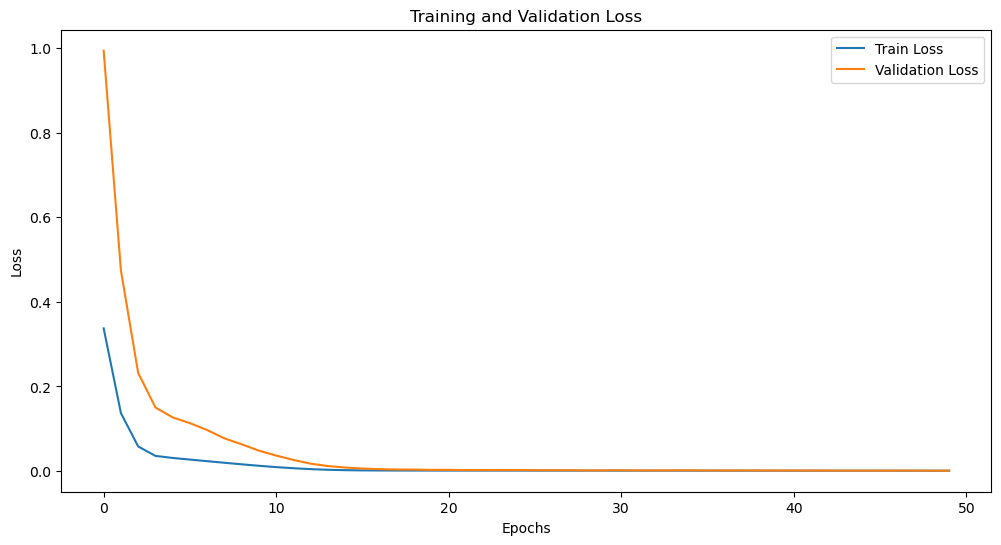

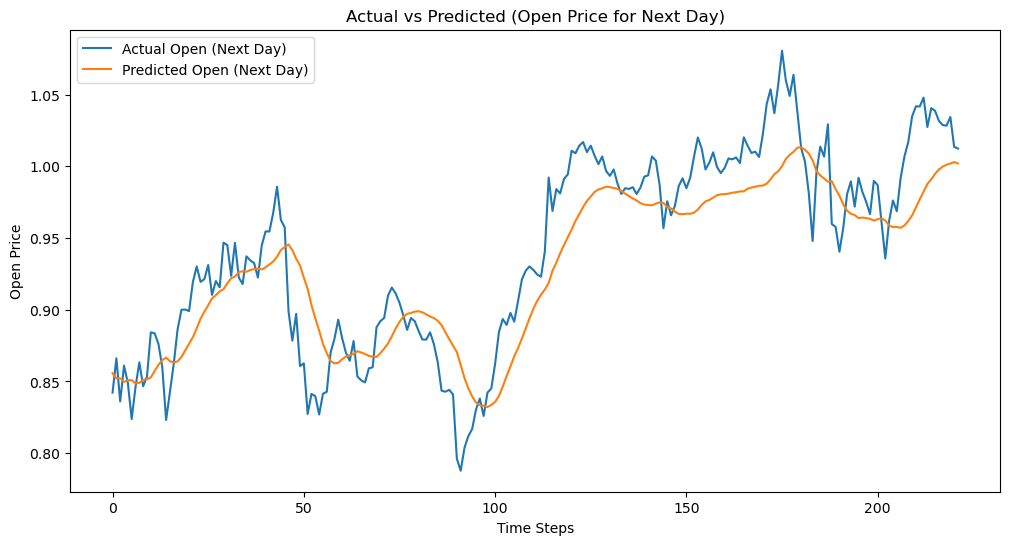

In [21]:
# Visualize training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Visualize actual vs. predicted for the 'Open' feature
plt.figure(figsize=(12, 6))
plt.plot(y_val_flattened, label='Actual Open (Next Day)')
plt.plot(val_predictions_flattened, label='Predicted Open (Next Day)')
plt.title('Actual vs Predicted (Open Price for Next Day)')
plt.xlabel('Time Steps')
plt.ylabel('Open Price')
plt.legend()
plt.show()

# Hyperparameter tuning

In [ ]:
# Function for LSTM model
def create_lstm_model(input_shape, units, layers, activation, optimizer, learning_rate, output_units):
    model = Sequential()

    # Add LSTM layers
    for i in range(layers):
        if i == 0:  
            model.add(
                LSTM(
                    units=units, activation=activation, return_sequences=(i < layers - 1),
                    input_shape=input_shape
                )
            )
        else: 
            model.add(
                LSTM(
                    units=units, activation=activation, return_sequences=(i < layers - 1)
                )
            )


    # output layer
    model.add(Dense(units=output_units))

    # optimizers
    if optimizer.lower() == 'sgd':
        opt = SGD(learning_rate=learning_rate)
    elif optimizer.lower() == 'adam':
        opt = Adam(learning_rate=learning_rate)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer}")

    model.compile(optimizer=opt, loss='mean_squared_error')
    return model

In [ ]:
# Optuna Objective Function
def objective(trial):
    # hyperparameter search space
    units = trial.suggest_categorical("units", [20, 50, 100])
    layers = trial.suggest_int("layers", 1, 5)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-8, 1e-2)
    optimizer = trial.suggest_categorical("optimizer", ["SGD", "Adam"])
    
    # Create the model
    model = create_lstm_model(
        input_shape=(X_train.shape[1], X_train.shape[2]),
        units=units,
        layers=layers,
        activation="tanh",
        optimizer=optimizer,
        learning_rate=learning_rate,
        output_units=M
    )

    # Train the model
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=0)
    history = model.fit(
        X_train, y_train,
        epochs=30,
        batch_size=32,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping],
        verbose=0
    )

    # Evaluate the model - rmse
    val_predictions = model.predict(X_val)
    val_rmse = sqrt(mean_squared_error(y_val.flatten(), val_predictions.flatten()))
    return val_rmse

In [ ]:
# Optuna optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

# Print the best parameters
print("\nBest Hyperparameters:")
print(study.best_params)
print(f"Best Validation RMSE: {study.best_value:.4f}")

# Train and Evaluate the Best Model
best_params = study.best_params
best_model = create_lstm_model(
    input_shape=(X_train.shape[1], X_train.shape[2]),
    units=best_params['units'],
    layers=best_params['layers'],
    activation="tanh",
    optimizer=best_params['optimizer'],
    learning_rate=best_params['learning_rate'],
    output_units=M
)

[I 2024-11-23 21:22:38,416] A new study created in memory with name: no-name-b7a4f5f4-2bcd-4080-8ac2-99c5d1e2eda1


7/7 [==============================] - 0s 5ms/step


[I 2024-11-23 21:22:49,470] Trial 0 finished with value: 0.8079060846168522 and parameters: {'units': 20, 'layers': 2, 'learning_rate': 4.3101253200971885e-06, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.8079060846168522.


7/7 [==============================] - 0s 2ms/step


[I 2024-11-23 21:22:55,970] Trial 1 finished with value: 0.8583065156047482 and parameters: {'units': 50, 'layers': 1, 'learning_rate': 2.7529662314693437e-06, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.8079060846168522.


7/7 [==============================] - 0s 4ms/step


[I 2024-11-23 21:23:07,195] Trial 2 finished with value: 0.5751619645718428 and parameters: {'units': 100, 'layers': 2, 'learning_rate': 0.00015362904493267698, 'optimizer': 'SGD'}. Best is trial 2 with value: 0.5751619645718428.


7/7 [==============================] - 0s 4ms/step


[I 2024-11-23 21:23:17,998] Trial 3 finished with value: 0.7912293776182346 and parameters: {'units': 20, 'layers': 2, 'learning_rate': 2.7801032878484533e-07, 'optimizer': 'Adam'}. Best is trial 2 with value: 0.5751619645718428.


7/7 [==============================] - 0s 3ms/step


[I 2024-11-23 21:23:24,564] Trial 4 finished with value: 0.031170123539071767 and parameters: {'units': 20, 'layers': 1, 'learning_rate': 7.894625544049868e-05, 'optimizer': 'Adam'}. Best is trial 4 with value: 0.031170123539071767.


7/7 [==============================] - 0s 3ms/step


[I 2024-11-23 21:23:31,441] Trial 5 finished with value: 0.7196862057007067 and parameters: {'units': 20, 'layers': 1, 'learning_rate': 2.215993936751515e-07, 'optimizer': 'Adam'}. Best is trial 4 with value: 0.031170123539071767.


7/7 [==============================] - 0s 2ms/step


[I 2024-11-23 21:23:38,103] Trial 6 finished with value: 0.9947019233678407 and parameters: {'units': 20, 'layers': 1, 'learning_rate': 1.9649029422145156e-08, 'optimizer': 'SGD'}. Best is trial 4 with value: 0.031170123539071767.


7/7 [==============================] - 0s 3ms/step


[I 2024-11-23 21:23:42,112] Trial 7 finished with value: 0.0388440996517833 and parameters: {'units': 50, 'layers': 1, 'learning_rate': 0.00013572364786873444, 'optimizer': 'Adam'}. Best is trial 4 with value: 0.031170123539071767.


7/7 [==============================] - 0s 3ms/step


[I 2024-11-23 21:23:48,722] Trial 8 finished with value: 0.9243432650823911 and parameters: {'units': 20, 'layers': 1, 'learning_rate': 3.017169142076073e-08, 'optimizer': 'SGD'}. Best is trial 4 with value: 0.031170123539071767.


7/7 [==============================] - 1s 6ms/step


[I 2024-11-23 21:24:08,311] Trial 9 finished with value: 0.9064168264889004 and parameters: {'units': 20, 'layers': 4, 'learning_rate': 4.642436386653755e-07, 'optimizer': 'Adam'}. Best is trial 4 with value: 0.031170123539071767.


7/7 [==============================] - 1s 8ms/step


[I 2024-11-23 21:24:21,177] Trial 10 finished with value: 0.03638850731607015 and parameters: {'units': 100, 'layers': 5, 'learning_rate': 0.006591920888000168, 'optimizer': 'Adam'}. Best is trial 4 with value: 0.031170123539071767.


7/7 [==============================] - 1s 9ms/step


[I 2024-11-23 21:24:40,276] Trial 11 finished with value: 0.030085233632240235 and parameters: {'units': 100, 'layers': 5, 'learning_rate': 0.0068153242544687406, 'optimizer': 'Adam'}. Best is trial 11 with value: 0.030085233632240235.


7/7 [==============================] - 1s 9ms/step


[I 2024-11-23 21:24:59,067] Trial 12 finished with value: 0.031444911932821666 and parameters: {'units': 100, 'layers': 5, 'learning_rate': 0.009059621039788721, 'optimizer': 'Adam'}. Best is trial 11 with value: 0.030085233632240235.


7/7 [==============================] - 0s 5ms/step


[I 2024-11-23 21:25:06,898] Trial 13 finished with value: 0.04109558710248845 and parameters: {'units': 100, 'layers': 3, 'learning_rate': 0.0004860180541790567, 'optimizer': 'Adam'}. Best is trial 11 with value: 0.030085233632240235.


7/7 [==============================] - 1s 7ms/step


[I 2024-11-23 21:25:18,042] Trial 14 finished with value: 0.04402466544237818 and parameters: {'units': 100, 'layers': 4, 'learning_rate': 0.0010888853213629035, 'optimizer': 'Adam'}. Best is trial 11 with value: 0.030085233632240235.


7/7 [==============================] - 1s 7ms/step


[I 2024-11-23 21:25:32,035] Trial 15 finished with value: 0.05080709314301826 and parameters: {'units': 50, 'layers': 4, 'learning_rate': 3.906217479695774e-05, 'optimizer': 'Adam'}. Best is trial 11 with value: 0.030085233632240235.


7/7 [==============================] - 0s 5ms/step


[I 2024-11-23 21:25:40,322] Trial 16 finished with value: 0.036549623689957386 and parameters: {'units': 100, 'layers': 3, 'learning_rate': 0.0014880190009680604, 'optimizer': 'Adam'}. Best is trial 11 with value: 0.030085233632240235.


7/7 [==============================] - 1s 9ms/step


[I 2024-11-23 21:26:04,267] Trial 17 finished with value: 0.23037395374015004 and parameters: {'units': 20, 'layers': 5, 'learning_rate': 1.023580866448342e-05, 'optimizer': 'Adam'}. Best is trial 11 with value: 0.030085233632240235.


7/7 [==============================] - 0s 6ms/step


[I 2024-11-23 21:26:19,906] Trial 18 finished with value: 0.7219375316404268 and parameters: {'units': 100, 'layers': 3, 'learning_rate': 6.766935822409242e-05, 'optimizer': 'SGD'}. Best is trial 11 with value: 0.030085233632240235.


7/7 [==============================] - 1s 7ms/step


[I 2024-11-23 21:26:40,784] Trial 19 finished with value: 0.052093316591983505 and parameters: {'units': 50, 'layers': 4, 'learning_rate': 1.8950887178687746e-05, 'optimizer': 'Adam'}. Best is trial 11 with value: 0.030085233632240235.


7/7 [==============================] - 0s 4ms/step


[I 2024-11-23 21:26:49,323] Trial 20 finished with value: 0.024227848920701314 and parameters: {'units': 100, 'layers': 2, 'learning_rate': 0.0027327703998142774, 'optimizer': 'Adam'}. Best is trial 20 with value: 0.024227848920701314.


7/7 [==============================] - 0s 4ms/step


[I 2024-11-23 21:26:53,963] Trial 21 finished with value: 0.03082298507454453 and parameters: {'units': 100, 'layers': 2, 'learning_rate': 0.0022226770632154643, 'optimizer': 'Adam'}. Best is trial 20 with value: 0.024227848920701314.


7/7 [==============================] - 0s 4ms/step


[I 2024-11-23 21:27:05,251] Trial 22 finished with value: 0.029495676493089252 and parameters: {'units': 100, 'layers': 2, 'learning_rate': 0.002712464759500455, 'optimizer': 'Adam'}. Best is trial 20 with value: 0.024227848920701314.


7/7 [==============================] - 0s 7ms/step


[I 2024-11-23 21:27:11,127] Trial 23 finished with value: 0.04367935900025193 and parameters: {'units': 100, 'layers': 3, 'learning_rate': 0.000417684553852954, 'optimizer': 'Adam'}. Best is trial 20 with value: 0.024227848920701314.


7/7 [==============================] - 0s 4ms/step


[I 2024-11-23 21:27:16,172] Trial 24 finished with value: 0.02963470268930986 and parameters: {'units': 100, 'layers': 2, 'learning_rate': 0.0034302417376040825, 'optimizer': 'Adam'}. Best is trial 20 with value: 0.024227848920701314.


7/7 [==============================] - 0s 4ms/step


[I 2024-11-23 21:27:24,057] Trial 25 finished with value: 0.024853499544088355 and parameters: {'units': 100, 'layers': 2, 'learning_rate': 0.0027645452714988236, 'optimizer': 'Adam'}. Best is trial 20 with value: 0.024227848920701314.


7/7 [==============================] - 0s 5ms/step


[I 2024-11-23 21:27:35,115] Trial 26 finished with value: 0.3801747696325613 and parameters: {'units': 100, 'layers': 2, 'learning_rate': 0.0005434437040631502, 'optimizer': 'SGD'}. Best is trial 20 with value: 0.024227848920701314.


7/7 [==============================] - 0s 4ms/step


[I 2024-11-23 21:27:42,901] Trial 27 finished with value: 0.03413371215298071 and parameters: {'units': 100, 'layers': 2, 'learning_rate': 0.00022874876066090243, 'optimizer': 'Adam'}. Best is trial 20 with value: 0.024227848920701314.


7/7 [==============================] - 0s 6ms/step


[I 2024-11-23 21:27:51,987] Trial 28 finished with value: 0.034591284313659626 and parameters: {'units': 100, 'layers': 3, 'learning_rate': 0.0011806351405617495, 'optimizer': 'Adam'}. Best is trial 20 with value: 0.024227848920701314.


7/7 [==============================] - 0s 4ms/step


[I 2024-11-23 21:28:03,396] Trial 29 finished with value: 0.5568260663986061 and parameters: {'units': 100, 'layers': 2, 'learning_rate': 1.8021556089276023e-06, 'optimizer': 'Adam'}. Best is trial 20 with value: 0.024227848920701314.


7/7 [==============================] - 0s 4ms/step


[I 2024-11-23 21:28:13,273] Trial 30 finished with value: 0.024081097990952795 and parameters: {'units': 100, 'layers': 2, 'learning_rate': 0.0029005651213019554, 'optimizer': 'Adam'}. Best is trial 30 with value: 0.024081097990952795.


7/7 [==============================] - 0s 4ms/step


[I 2024-11-23 21:28:20,708] Trial 31 finished with value: 0.025258014100907247 and parameters: {'units': 100, 'layers': 2, 'learning_rate': 0.0042159000360534405, 'optimizer': 'Adam'}. Best is trial 30 with value: 0.024081097990952795.


7/7 [==============================] - 0s 4ms/step


[I 2024-11-23 21:28:28,201] Trial 32 finished with value: 0.02714317980080463 and parameters: {'units': 100, 'layers': 2, 'learning_rate': 0.0037223887739228742, 'optimizer': 'Adam'}. Best is trial 30 with value: 0.024081097990952795.


7/7 [==============================] - 0s 6ms/step


[I 2024-11-23 21:28:37,630] Trial 33 finished with value: 0.03516351595286562 and parameters: {'units': 100, 'layers': 3, 'learning_rate': 0.0009082671546347976, 'optimizer': 'Adam'}. Best is trial 30 with value: 0.024081097990952795.


7/7 [==============================] - 0s 5ms/step


[I 2024-11-23 21:28:48,804] Trial 34 finished with value: 0.05921467593956778 and parameters: {'units': 50, 'layers': 2, 'learning_rate': 0.009591002410725396, 'optimizer': 'SGD'}. Best is trial 30 with value: 0.024081097990952795.


7/7 [==============================] - 0s 3ms/step


[I 2024-11-23 21:28:51,608] Trial 35 finished with value: 0.034170618069108476 and parameters: {'units': 100, 'layers': 1, 'learning_rate': 0.00027038826008049375, 'optimizer': 'Adam'}. Best is trial 30 with value: 0.024081097990952795.


7/7 [==============================] - 0s 4ms/step


[I 2024-11-23 21:28:58,700] Trial 36 finished with value: 0.026909723602931708 and parameters: {'units': 100, 'layers': 2, 'learning_rate': 0.0035287964599814026, 'optimizer': 'Adam'}. Best is trial 30 with value: 0.024081097990952795.


7/7 [==============================] - 0s 3ms/step


[I 2024-11-23 21:29:05,317] Trial 37 finished with value: 0.35169789162775333 and parameters: {'units': 100, 'layers': 1, 'learning_rate': 0.0007979367644786789, 'optimizer': 'SGD'}. Best is trial 30 with value: 0.024081097990952795.


7/7 [==============================] - 0s 4ms/step


[I 2024-11-23 21:29:10,438] Trial 38 finished with value: 0.03299623413728531 and parameters: {'units': 50, 'layers': 2, 'learning_rate': 0.001770011146954902, 'optimizer': 'Adam'}. Best is trial 30 with value: 0.024081097990952795.


7/7 [==============================] - 0s 3ms/step


[I 2024-11-23 21:29:13,651] Trial 39 finished with value: 0.039168380930620396 and parameters: {'units': 100, 'layers': 1, 'learning_rate': 0.00014559920993534415, 'optimizer': 'Adam'}. Best is trial 30 with value: 0.024081097990952795.


7/7 [==============================] - 0s 2ms/step


[I 2024-11-23 21:29:20,304] Trial 40 finished with value: 0.0885133169627818 and parameters: {'units': 100, 'layers': 1, 'learning_rate': 0.004508810747586974, 'optimizer': 'SGD'}. Best is trial 30 with value: 0.024081097990952795.


7/7 [==============================] - 0s 4ms/step


[I 2024-11-23 21:29:31,317] Trial 41 finished with value: 0.05999232628495232 and parameters: {'units': 100, 'layers': 2, 'learning_rate': 0.002391934954317916, 'optimizer': 'Adam'}. Best is trial 30 with value: 0.024081097990952795.


7/7 [==============================] - 0s 3ms/step


[I 2024-11-23 21:29:35,334] Trial 42 finished with value: 0.028934013212467056 and parameters: {'units': 100, 'layers': 2, 'learning_rate': 0.0045870090728371005, 'optimizer': 'Adam'}. Best is trial 30 with value: 0.024081097990952795.


7/7 [==============================] - 0s 4ms/step


[I 2024-11-23 21:29:43,568] Trial 43 finished with value: 0.0299927619540743 and parameters: {'units': 100, 'layers': 2, 'learning_rate': 0.0006190808631623049, 'optimizer': 'Adam'}. Best is trial 30 with value: 0.024081097990952795.


7/7 [==============================] - 0s 5ms/step


[I 2024-11-23 21:29:58,824] Trial 44 finished with value: 1.1801373884921276 and parameters: {'units': 20, 'layers': 3, 'learning_rate': 7.880155663643623e-08, 'optimizer': 'Adam'}. Best is trial 30 with value: 0.024081097990952795.


7/7 [==============================] - 0s 4ms/step


[I 2024-11-23 21:30:09,849] Trial 45 finished with value: 0.02774891549039915 and parameters: {'units': 100, 'layers': 2, 'learning_rate': 0.009842971236218242, 'optimizer': 'Adam'}. Best is trial 30 with value: 0.024081097990952795.


7/7 [==============================] - 0s 2ms/step


[I 2024-11-23 21:30:13,744] Trial 46 finished with value: 0.026901715717136624 and parameters: {'units': 100, 'layers': 1, 'learning_rate': 0.0015882934826055206, 'optimizer': 'Adam'}. Best is trial 30 with value: 0.024081097990952795.


7/7 [==============================] - 0s 2ms/step


[I 2024-11-23 21:30:19,428] Trial 47 finished with value: 0.03482918077634115 and parameters: {'units': 20, 'layers': 1, 'learning_rate': 0.00027697122859948997, 'optimizer': 'Adam'}. Best is trial 30 with value: 0.024081097990952795.


7/7 [==============================] - 0s 3ms/step


[I 2024-11-23 21:30:26,421] Trial 48 finished with value: 0.8584968712080382 and parameters: {'units': 100, 'layers': 1, 'learning_rate': 1.6124862781512244e-06, 'optimizer': 'Adam'}. Best is trial 30 with value: 0.024081097990952795.


7/7 [==============================] - 0s 3ms/step


[I 2024-11-23 21:30:30,577] Trial 49 finished with value: 0.03982909583874061 and parameters: {'units': 50, 'layers': 1, 'learning_rate': 6.719112758737326e-05, 'optimizer': 'Adam'}. Best is trial 30 with value: 0.024081097990952795.



Best Hyperparameters:
{'units': 100, 'layers': 2, 'learning_rate': 0.0029005651213019554, 'optimizer': 'Adam'}
Best Validation RMSE: 0.0241


In [ ]:
# Best parameter
print("\nBest Hyperparameters:")
print(study.best_params)
print(f"Best Validation RMSE: {study.best_value:.4f}")


Best Hyperparameters:
{'units': 100, 'layers': 2, 'learning_rate': 0.0029005651213019554, 'optimizer': 'Adam'}
Best Validation RMSE: 0.0241


# Test lstm

In [ ]:
# concatinating validation and train datset and retrain the combined dataset model with test set and best parameter
combined_data_lstm= pd.DataFrame(np.concatenate([train_set, validation_set], axis=0)
, columns=['Date','Open', 'High', 'Low', 'Close', 'Volume'])

# MinMaxScaler
scaler = MinMaxScaler()

# transformation on the combined dataset
combined_data_lstm[columns_to_normalize] = scaler.fit_transform(combined_data_lstm[columns_to_normalize])

Univariate = combined_data_lstm[['Open']]

In [ ]:
# Set the random seed for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

In [ ]:

def create_sequences(data, N, M):

    X, y = [], []
    for i in range(len(data) - N - M + 1):
        input_sequence = data[i:i+N]  # Past N days
        output_sequence = data[i+N:i+N+M]  # Next M days
        X.append(input_sequence)
        y.append(output_sequence)

    # Convert to numpy arrays
    X_array = np.array(X)
    y_array = np.array(y)
    return X_array, y_array

In [ ]:
# Parameters for sequence creation
N = 5  # Number of past 5 days
M = 1  # Number of future days (predict the next day)

combined_data_open = combined_data_lstm['Open'].values
X_train, y_train = create_sequences(combined_data_open, N=N, M=M)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))  # (samples, timesteps, features)

# Prepare sequences for the test dataset
test_data_open = test_data['Open'].values
X_test, y_test = create_sequences(test_data_open, N=N, M=M)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))  

# LSTM model with best hyperparameters
def create_model(input_shape, units, layers, learning_rate):
    model = Sequential()
    for i in range(layers):
        if i == 0:  
            model.add(LSTM(units, activation='tanh', return_sequences=(i < layers - 1), input_shape=input_shape))
        else:  #
            model.add(LSTM(units, activation='tanh', return_sequences=(i < layers - 1)))
    model.add(Dense(1)) 
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse')
    return model

# Best hyperparameters
best_params = {
    'units': 100,
    'layers': 2,
    'learning_rate':0.0029005651213019554
}

units = best_params['units']
layers = best_params['layers']
learning_rate = best_params['learning_rate']

# Create the model
input_shape = (X_train.shape[1], X_train.shape[2]) 
model = create_model(input_shape, units, layers, learning_rate)

In [ ]:
# Train the model on the full combined dataset
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    verbose=1,
    validation_data=(X_test, y_test)
)

Epoch 1/30
40/40 [==============================] - 2s 14ms/step - loss: 0.0251 - val_loss: 0.0056
Epoch 2/30
40/40 [==============================] - 0s 6ms/step - loss: 7.7991e-04 - val_loss: 0.0028
Epoch 3/30
40/40 [==============================] - 0s 5ms/step - loss: 6.9034e-04 - val_loss: 0.0015
Epoch 4/30
40/40 [==============================] - 0s 6ms/step - loss: 6.5612e-04 - val_loss: 0.0013
Epoch 5/30
40/40 [==============================] - 0s 6ms/step - loss: 6.3302e-04 - val_loss: 0.0011
Epoch 6/30
40/40 [==============================] - 0s 6ms/step - loss: 6.0499e-04 - val_loss: 7.6476e-04
Epoch 7/30
40/40 [==============================] - 0s 6ms/step - loss: 6.7632e-04 - val_loss: 0.0013
Epoch 8/30
40/40 [==============================] - 0s 6ms/step - loss: 6.7996e-04 - val_loss: 9.1098e-04
Epoch 9/30
40/40 [==============================] - 0s 6ms/step - loss: 5.9830e-04 - val_loss: 0.0016
Epoch 10/30
40/40 [==============================] - 0s 6ms/step - loss: 6.37

In [46]:
# Evaluate the model on the test set
test_predictions = model.predict(X_test)
test_rmse = sqrt(mean_squared_error(y_test.flatten(), test_predictions.flatten()))
print(f"Test RMSE: {test_rmse:.4f}")


1/1 [==============================] - 0s 268ms/step
Test RMSE: 0.0246


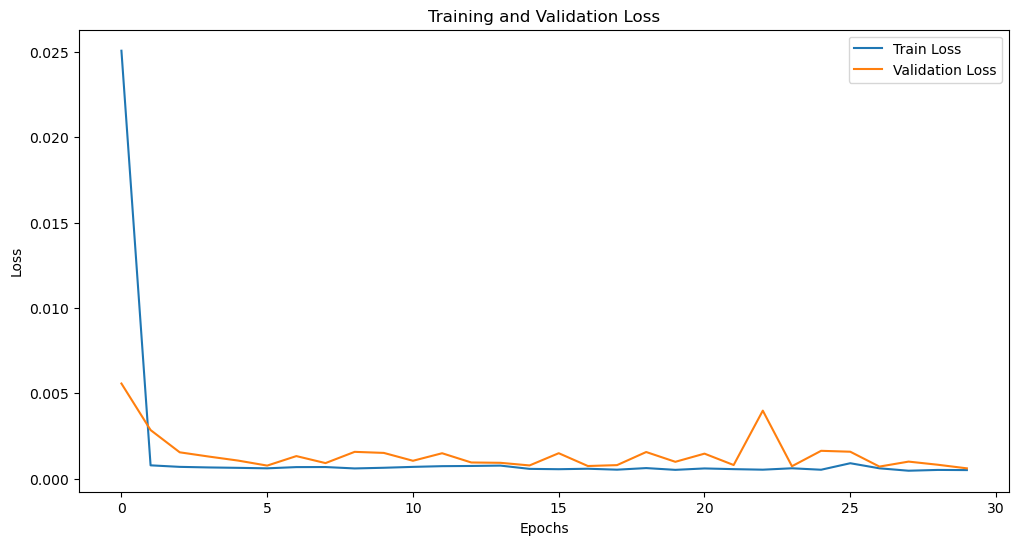

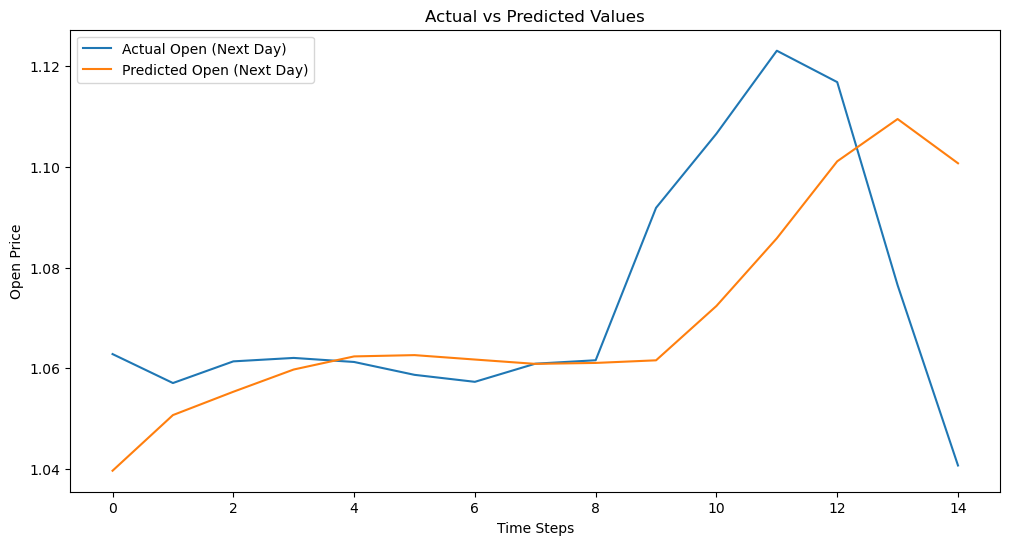

In [47]:
# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test.flatten(), label='Actual Open (Next Day)')
plt.plot(test_predictions.flatten(), label='Predicted Open (Next Day)')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time Steps')
plt.ylabel('Open Price')
plt.legend()
plt.show()

# 2. Vanilla RNN Baseline

In [ ]:
N = 30  # Number of past days
M = 1   # Number of future days (predict the next day)

# Prepare the dataset using the Open feature (univariate)
def create_sequences(data, N, M):
    X, y = [], []
    for i in range(len(data) - N - M + 1):
        X.append(data[i:i+N])  # Past N days (input)
        y.append(data[i+N:i+N+M])  # Next M days (output: single feature)
    return np.array(X), np.array(y)

# Extract only the 'Open' column for univariate prediction
train_data = train_set[['Open']].values
val_data = validation_set[['Open']].values

# Create sequences for training and validation data
X_train, y_train = create_sequences(train_data, N, M)
X_val, y_val = create_sequences(val_data, N, M)

# Reshape input to 3D for SimpleRNN
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1)) 
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))

print(f"Training data shape: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Validation data shape: X_val={X_val.shape}, y_val={y_val.shape}")

# Vanilla RNN model single layer model
regressor = Sequential()
regressor.add(SimpleRNN(units=10,  activation='tanh', input_shape=(X_train.shape[1], 1)))
regressor.add(Dense(units=M)) 
regressor.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = regressor.fit(X_train, y_train, 
                        epochs=50, batch_size=32,
                        validation_data=(X_val, y_val),
                        verbose=1)
val_predictions = regressor.predict(X_val)

# Flatten the arrays to make them 1D
y_val_flattened = y_val.flatten()
val_predictions_flattened = val_predictions.flatten()

#  RMSE
val_rmse = sqrt(mean_squared_error(y_val_flattened, val_predictions_flattened))
print(f"Validation RMSE: {val_rmse:.4f}")


Training data shape: X_train=(976, 30, 1), y_train=(976, 1, 1)
Validation data shape: X_val=(222, 30, 1), y_val=(222, 1, 1)
Epoch 1/50
31/31 [==============================] - 1s 20ms/step - loss: 0.0593 - val_loss: 0.2821
Epoch 2/50
31/31 [==============================] - 1s 17ms/step - loss: 0.0162 - val_loss: 0.1730
Epoch 3/50
31/31 [==============================] - 1s 16ms/step - loss: 0.0100 - val_loss: 0.1135
Epoch 4/50
31/31 [==============================] - 1s 18ms/step - loss: 0.0075 - val_loss: 0.0943
Epoch 5/50
31/31 [==============================] - 1s 17ms/step - loss: 0.0060 - val_loss: 0.0707
Epoch 6/50
31/31 [==============================] - 1s 17ms/step - loss: 0.0050 - val_loss: 0.0567
Epoch 7/50
31/31 [==============================] - 1s 19ms/step - loss: 0.0043 - val_loss: 0.0476
Epoch 8/50
31/31 [==============================] - 1s 19ms/step - loss: 0.0037 - val_loss: 0.0395
Epoch 9/50
31/31 [==============================] - 1s 17ms/step - loss: 0.0033 - va

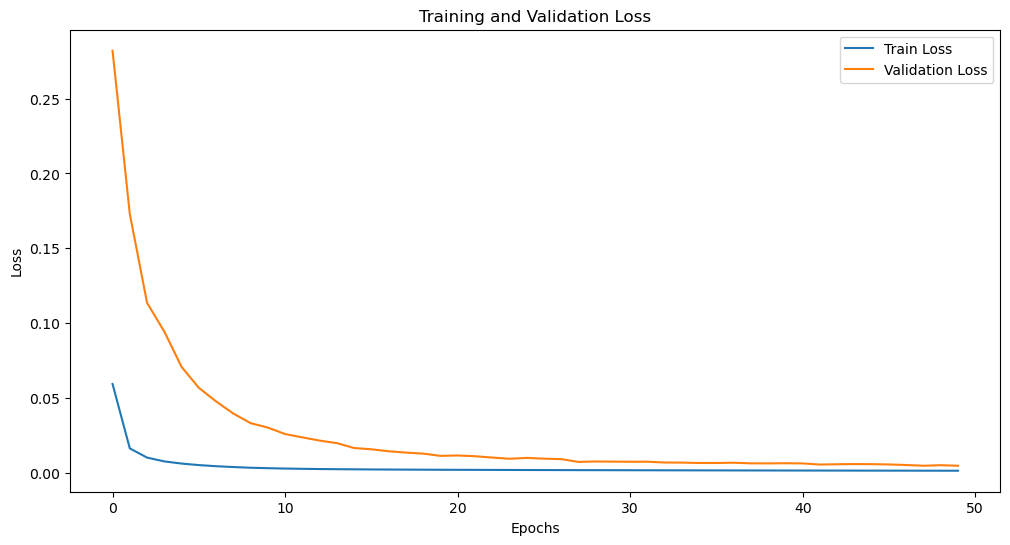

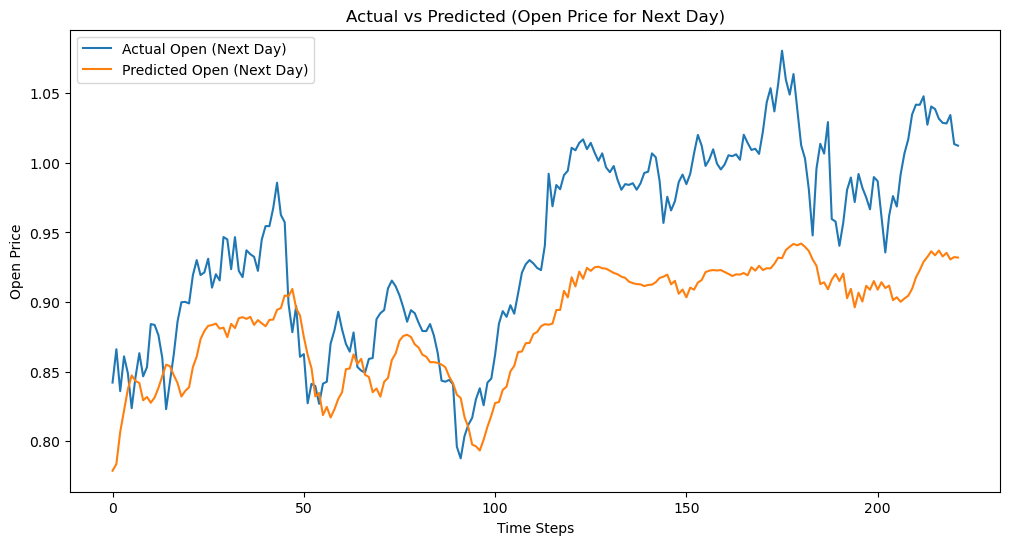

In [50]:
# Visualize training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Visualize actual vs. predicted for the 'Open' feature
plt.figure(figsize=(12, 6))
plt.plot(y_val_flattened, label='Actual Open (Next Day)')
plt.plot(val_predictions_flattened, label='Predicted Open (Next Day)')
plt.title('Actual vs Predicted (Open Price for Next Day)')
plt.xlabel('Time Steps')
plt.ylabel('Open Price')
plt.legend()
plt.show()


# Hyperparameter Vanilla RNN

In [ ]:
#  Vanilla RNN model
def create_model(input_shape, units, layers, activation, optimizer, learning_rate, output_units):
    model = Sequential()

    # Add RNN layers
    for i in range(layers):
        if i == 0:  # First RNN layer
            model.add(SimpleRNN(units, activation=activation, return_sequences=(i < layers - 1), input_shape=input_shape))
        else:  # Subsequent RNN layers
            model.add(SimpleRNN(units, activation=activation, return_sequences=(i < layers - 1)))

    # Add output layer
    model.add(Dense(units=output_units))

    # optimizers
    if optimizer.lower() == 'sgd':
        opt = SGD(learning_rate=learning_rate)
    elif optimizer.lower() == 'adam':
        opt = Adam(learning_rate=learning_rate)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer}")

    # Compile the model
    model.compile(optimizer=opt, loss='mean_squared_error')
    return model

In [ ]:
# Optuna objective function
def objective(trial):
    # hyperparameter search space
    units = trial.suggest_categorical("units", [20, 50, 100])
    layers = trial.suggest_int("layers", 1, 3)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
    optimizer = trial.suggest_categorical("optimizer", ["SGD", "Adam"])

    # Create the model
    model = create_model(
        input_shape=(X_train.shape[1], X_train.shape[2]),
        units=units,
        layers=layers,
        activation='tanh',
        optimizer=optimizer,
        learning_rate=learning_rate,
        output_units=M
    )

    # Train the model
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=0)
    history = model.fit(
        X_train, y_train,
        epochs=30,
        batch_size=32,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping],
        verbose=0  
    )

    # Evaluate the model
    val_predictions = model.predict(X_val)
    val_rmse = sqrt(mean_squared_error(y_val.flatten(), val_predictions.flatten()))
    return val_rmse

# Optuna optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

# Print the best parameters
print("\nBest Hyperparameters:")
print(study.best_params)
print(f"Best Validation RMSE: {study.best_value:.4f}")


[I 2024-11-23 21:47:32,345] A new study created in memory with name: no-name-b998eef6-f735-4eb0-8eef-7c66c2573870


7/7 [==============================] - 0s 8ms/step


[I 2024-11-23 21:47:42,782] Trial 0 finished with value: 0.14782850692052435 and parameters: {'units': 20, 'layers': 2, 'learning_rate': 0.0001808907873228128, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.14782850692052435.


7/7 [==============================] - 0s 9ms/step


[I 2024-11-23 21:47:56,804] Trial 1 finished with value: 0.02790813731067709 and parameters: {'units': 50, 'layers': 3, 'learning_rate': 0.0022676811083130956, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.02790813731067709.


7/7 [==============================] - 0s 6ms/step


[I 2024-11-23 21:48:05,302] Trial 2 finished with value: 0.02207794562570222 and parameters: {'units': 50, 'layers': 1, 'learning_rate': 0.001337163990830478, 'optimizer': 'Adam'}. Best is trial 2 with value: 0.02207794562570222.


7/7 [==============================] - 0s 9ms/step


[I 2024-11-23 21:48:46,233] Trial 3 finished with value: 0.20007058731816768 and parameters: {'units': 20, 'layers': 2, 'learning_rate': 0.000337152820165099, 'optimizer': 'SGD'}. Best is trial 2 with value: 0.02207794562570222.


7/7 [==============================] - 0s 5ms/step


[I 2024-11-23 21:49:02,110] Trial 4 finished with value: 0.022452153959930905 and parameters: {'units': 20, 'layers': 1, 'learning_rate': 0.0009772660806540874, 'optimizer': 'Adam'}. Best is trial 2 with value: 0.02207794562570222.


7/7 [==============================] - 0s 8ms/step


[I 2024-11-23 21:49:41,027] Trial 5 finished with value: 0.11727945844124191 and parameters: {'units': 50, 'layers': 2, 'learning_rate': 0.0011886807974883266, 'optimizer': 'SGD'}. Best is trial 2 with value: 0.02207794562570222.


7/7 [==============================] - 0s 8ms/step


[I 2024-11-23 21:49:49,558] Trial 6 finished with value: 0.06805936472502595 and parameters: {'units': 50, 'layers': 2, 'learning_rate': 0.0002100052251350223, 'optimizer': 'SGD'}. Best is trial 2 with value: 0.02207794562570222.


7/7 [==============================] - 0s 5ms/step


[I 2024-11-23 21:49:57,763] Trial 7 finished with value: 0.02599929204164723 and parameters: {'units': 100, 'layers': 1, 'learning_rate': 0.0013521229125289188, 'optimizer': 'Adam'}. Best is trial 2 with value: 0.02207794562570222.


7/7 [==============================] - 0s 7ms/step


[I 2024-11-23 21:50:12,799] Trial 8 finished with value: 0.06215427984631402 and parameters: {'units': 100, 'layers': 2, 'learning_rate': 0.002448713462934233, 'optimizer': 'SGD'}. Best is trial 2 with value: 0.02207794562570222.


7/7 [==============================] - 0s 10ms/step


[I 2024-11-23 21:51:08,955] Trial 9 finished with value: 0.13138349830748117 and parameters: {'units': 100, 'layers': 3, 'learning_rate': 0.0001922179513773619, 'optimizer': 'SGD'}. Best is trial 2 with value: 0.02207794562570222.


7/7 [==============================] - 0s 4ms/step


[I 2024-11-23 21:51:15,985] Trial 10 finished with value: 0.01740265539822158 and parameters: {'units': 50, 'layers': 1, 'learning_rate': 0.006931806090129947, 'optimizer': 'Adam'}. Best is trial 10 with value: 0.01740265539822158.


7/7 [==============================] - 0s 5ms/step


[I 2024-11-23 21:51:23,602] Trial 11 finished with value: 0.019698034330130603 and parameters: {'units': 50, 'layers': 1, 'learning_rate': 0.00813207949488333, 'optimizer': 'Adam'}. Best is trial 10 with value: 0.01740265539822158.


7/7 [==============================] - 0s 4ms/step


[I 2024-11-23 21:51:28,527] Trial 12 finished with value: 0.021634274315977073 and parameters: {'units': 50, 'layers': 1, 'learning_rate': 0.008106880309096823, 'optimizer': 'Adam'}. Best is trial 10 with value: 0.01740265539822158.


7/7 [==============================] - 0s 5ms/step


[I 2024-11-23 21:51:35,417] Trial 13 finished with value: 0.01896284746501576 and parameters: {'units': 50, 'layers': 1, 'learning_rate': 0.009827614661053632, 'optimizer': 'Adam'}. Best is trial 10 with value: 0.01740265539822158.


7/7 [==============================] - 0s 4ms/step


[I 2024-11-23 21:51:43,119] Trial 14 finished with value: 0.02072162952846658 and parameters: {'units': 50, 'layers': 1, 'learning_rate': 0.004443425491118961, 'optimizer': 'Adam'}. Best is trial 10 with value: 0.01740265539822158.


7/7 [==============================] - 0s 5ms/step


[I 2024-11-23 21:51:50,992] Trial 15 finished with value: 0.020060282583325026 and parameters: {'units': 50, 'layers': 1, 'learning_rate': 0.009667249636662122, 'optimizer': 'Adam'}. Best is trial 10 with value: 0.01740265539822158.


7/7 [==============================] - 0s 4ms/step


[I 2024-11-23 21:51:54,963] Trial 16 finished with value: 0.019682472917377306 and parameters: {'units': 50, 'layers': 1, 'learning_rate': 0.0042564951431440295, 'optimizer': 'Adam'}. Best is trial 10 with value: 0.01740265539822158.


7/7 [==============================] - 0s 10ms/step


[I 2024-11-23 21:52:46,780] Trial 17 finished with value: 0.02163871860704356 and parameters: {'units': 50, 'layers': 3, 'learning_rate': 0.00416087427138161, 'optimizer': 'Adam'}. Best is trial 10 with value: 0.01740265539822158.


7/7 [==============================] - 0s 4ms/step


[I 2024-11-23 21:53:02,093] Trial 18 finished with value: 0.03819284286064116 and parameters: {'units': 100, 'layers': 1, 'learning_rate': 0.005329268853089979, 'optimizer': 'Adam'}. Best is trial 10 with value: 0.01740265539822158.


7/7 [==============================] - 0s 7ms/step


[I 2024-11-23 21:53:38,680] Trial 19 finished with value: 0.026359121273750254 and parameters: {'units': 20, 'layers': 2, 'learning_rate': 0.0006052815711989803, 'optimizer': 'Adam'}. Best is trial 10 with value: 0.01740265539822158.


7/7 [==============================] - 0s 8ms/step


[I 2024-11-23 21:54:02,362] Trial 20 finished with value: 0.017699353196756754 and parameters: {'units': 50, 'layers': 2, 'learning_rate': 0.002385918792104085, 'optimizer': 'Adam'}. Best is trial 10 with value: 0.01740265539822158.


7/7 [==============================] - 0s 7ms/step


[I 2024-11-23 21:54:28,066] Trial 21 finished with value: 0.01853174414449452 and parameters: {'units': 50, 'layers': 2, 'learning_rate': 0.0025907047535058346, 'optimizer': 'Adam'}. Best is trial 10 with value: 0.01740265539822158.


7/7 [==============================] - 0s 8ms/step


[I 2024-11-23 21:54:55,774] Trial 22 finished with value: 0.019230796289315445 and parameters: {'units': 50, 'layers': 2, 'learning_rate': 0.002486802649241634, 'optimizer': 'Adam'}. Best is trial 10 with value: 0.01740265539822158.


7/7 [==============================] - 0s 10ms/step


[I 2024-11-23 21:55:36,469] Trial 23 finished with value: 0.019001405417171376 and parameters: {'units': 50, 'layers': 3, 'learning_rate': 0.0019985995747498625, 'optimizer': 'Adam'}. Best is trial 10 with value: 0.01740265539822158.


7/7 [==============================] - 0s 8ms/step


[I 2024-11-23 21:56:12,971] Trial 24 finished with value: 0.02046165930815342 and parameters: {'units': 50, 'layers': 2, 'learning_rate': 0.0032518642956634717, 'optimizer': 'Adam'}. Best is trial 10 with value: 0.01740265539822158.


7/7 [==============================] - 0s 11ms/step


[I 2024-11-23 21:57:08,364] Trial 25 finished with value: 0.020398556398627376 and parameters: {'units': 50, 'layers': 3, 'learning_rate': 0.0007362044148606971, 'optimizer': 'Adam'}. Best is trial 10 with value: 0.01740265539822158.


7/7 [==============================] - 0s 7ms/step


[I 2024-11-23 21:57:26,627] Trial 26 finished with value: 0.01971853903426444 and parameters: {'units': 50, 'layers': 2, 'learning_rate': 0.005771110588704245, 'optimizer': 'Adam'}. Best is trial 10 with value: 0.01740265539822158.


7/7 [==============================] - 0s 8ms/step


[I 2024-11-23 21:57:47,497] Trial 27 finished with value: 0.021017223767839183 and parameters: {'units': 50, 'layers': 2, 'learning_rate': 0.001782831600675684, 'optimizer': 'Adam'}. Best is trial 10 with value: 0.01740265539822158.


7/7 [==============================] - 0s 11ms/step


[I 2024-11-23 21:58:42,765] Trial 28 finished with value: 0.029668590881913114 and parameters: {'units': 20, 'layers': 3, 'learning_rate': 0.0030018009206325504, 'optimizer': 'Adam'}. Best is trial 10 with value: 0.01740265539822158.


7/7 [==============================] - 0s 7ms/step


[I 2024-11-23 21:58:56,627] Trial 29 finished with value: 0.040367830979038365 and parameters: {'units': 100, 'layers': 2, 'learning_rate': 0.006498178444487547, 'optimizer': 'SGD'}. Best is trial 10 with value: 0.01740265539822158.


7/7 [==============================] - 0s 7ms/step


[I 2024-11-23 21:59:13,984] Trial 30 finished with value: 0.021995198715002603 and parameters: {'units': 20, 'layers': 2, 'learning_rate': 0.003220031656263771, 'optimizer': 'Adam'}. Best is trial 10 with value: 0.01740265539822158.


7/7 [==============================] - 0s 4ms/step


[I 2024-11-23 21:59:22,415] Trial 31 finished with value: 0.019432570719835444 and parameters: {'units': 50, 'layers': 1, 'learning_rate': 0.007094829055999748, 'optimizer': 'Adam'}. Best is trial 10 with value: 0.01740265539822158.


7/7 [==============================] - 0s 4ms/step


[I 2024-11-23 21:59:28,329] Trial 32 finished with value: 0.019390581893093815 and parameters: {'units': 50, 'layers': 1, 'learning_rate': 0.00902442760373966, 'optimizer': 'Adam'}. Best is trial 10 with value: 0.01740265539822158.


7/7 [==============================] - 0s 4ms/step


[I 2024-11-23 21:59:36,550] Trial 33 finished with value: 0.02148686167676788 and parameters: {'units': 50, 'layers': 1, 'learning_rate': 0.0016706762746420507, 'optimizer': 'Adam'}. Best is trial 10 with value: 0.01740265539822158.


7/7 [==============================] - 0s 4ms/step


[I 2024-11-23 21:59:45,338] Trial 34 finished with value: 0.018870160170433626 and parameters: {'units': 50, 'layers': 1, 'learning_rate': 0.005128809897576294, 'optimizer': 'Adam'}. Best is trial 10 with value: 0.01740265539822158.


7/7 [==============================] - 0s 8ms/step


[I 2024-11-23 22:00:11,115] Trial 35 finished with value: 0.018671923471528535 and parameters: {'units': 50, 'layers': 2, 'learning_rate': 0.0036709257658080474, 'optimizer': 'Adam'}. Best is trial 10 with value: 0.01740265539822158.


7/7 [==============================] - 0s 8ms/step


[I 2024-11-23 22:00:30,373] Trial 36 finished with value: 0.022242327948783072 and parameters: {'units': 50, 'layers': 2, 'learning_rate': 0.0036471842271194946, 'optimizer': 'Adam'}. Best is trial 10 with value: 0.01740265539822158.


7/7 [==============================] - 0s 7ms/step


[I 2024-11-23 22:01:06,929] Trial 37 finished with value: 0.23226658881889148 and parameters: {'units': 20, 'layers': 2, 'learning_rate': 0.0008639418074913949, 'optimizer': 'SGD'}. Best is trial 10 with value: 0.01740265539822158.


7/7 [==============================] - 0s 8ms/step


[I 2024-11-23 22:01:42,754] Trial 38 finished with value: 0.03304989903700689 and parameters: {'units': 50, 'layers': 2, 'learning_rate': 0.00010830592137249703, 'optimizer': 'Adam'}. Best is trial 10 with value: 0.01740265539822158.


7/7 [==============================] - 0s 8ms/step


[I 2024-11-23 22:01:53,761] Trial 39 finished with value: 0.03740348817684784 and parameters: {'units': 50, 'layers': 2, 'learning_rate': 0.0013668828905369869, 'optimizer': 'SGD'}. Best is trial 10 with value: 0.01740265539822158.


7/7 [==============================] - 0s 10ms/step


[I 2024-11-23 22:02:41,019] Trial 40 finished with value: 0.022428095871840484 and parameters: {'units': 100, 'layers': 3, 'learning_rate': 0.0004837179340093297, 'optimizer': 'Adam'}. Best is trial 10 with value: 0.01740265539822158.


7/7 [==============================] - 0s 7ms/step


[I 2024-11-23 22:03:02,502] Trial 41 finished with value: 0.018014373776498557 and parameters: {'units': 50, 'layers': 2, 'learning_rate': 0.00519718905674176, 'optimizer': 'Adam'}. Best is trial 10 with value: 0.01740265539822158.


7/7 [==============================] - 0s 7ms/step


[I 2024-11-23 22:03:22,305] Trial 42 finished with value: 0.019173085405059454 and parameters: {'units': 50, 'layers': 2, 'learning_rate': 0.002717421291754946, 'optimizer': 'Adam'}. Best is trial 10 with value: 0.01740265539822158.


7/7 [==============================] - 0s 8ms/step


[I 2024-11-23 22:03:39,423] Trial 43 finished with value: 0.018863169691532063 and parameters: {'units': 50, 'layers': 2, 'learning_rate': 0.002287046368488846, 'optimizer': 'Adam'}. Best is trial 10 with value: 0.01740265539822158.


7/7 [==============================] - 0s 5ms/step


[I 2024-11-23 22:03:57,477] Trial 44 finished with value: 0.019941175762853272 and parameters: {'units': 50, 'layers': 2, 'learning_rate': 0.006438985530356687, 'optimizer': 'Adam'}. Best is trial 10 with value: 0.01740265539822158.


7/7 [==============================] - 0s 8ms/step


[I 2024-11-23 22:04:28,785] Trial 45 finished with value: 0.017606551114012582 and parameters: {'units': 50, 'layers': 2, 'learning_rate': 0.004781059452871439, 'optimizer': 'Adam'}. Best is trial 10 with value: 0.01740265539822158.


7/7 [==============================] - 0s 8ms/step


[I 2024-11-23 22:04:43,579] Trial 46 finished with value: 0.03652317595558822 and parameters: {'units': 50, 'layers': 2, 'learning_rate': 0.004853814673056707, 'optimizer': 'SGD'}. Best is trial 10 with value: 0.01740265539822158.


7/7 [==============================] - 0s 9ms/step


[I 2024-11-23 22:05:00,393] Trial 47 finished with value: 0.030444700493964954 and parameters: {'units': 50, 'layers': 2, 'learning_rate': 0.007360014244860948, 'optimizer': 'Adam'}. Best is trial 10 with value: 0.01740265539822158.


7/7 [==============================] - 0s 8ms/step


[I 2024-11-23 22:05:19,145] Trial 48 finished with value: 0.02014037533171785 and parameters: {'units': 50, 'layers': 2, 'learning_rate': 0.003673505793153471, 'optimizer': 'Adam'}. Best is trial 10 with value: 0.01740265539822158.


7/7 [==============================] - 0s 12ms/step


[I 2024-11-23 22:06:11,280] Trial 49 finished with value: 0.020462933777129873 and parameters: {'units': 100, 'layers': 3, 'learning_rate': 0.0012328915901976497, 'optimizer': 'Adam'}. Best is trial 10 with value: 0.01740265539822158.



Best Hyperparameters:
{'units': 50, 'layers': 1, 'learning_rate': 0.006931806090129947, 'optimizer': 'Adam'}
Best Validation RMSE: 0.0174


In [ ]:
# Print the best parameters
print("\nBest Hyperparameters:")
print(study.best_params)
print(f"Best Validation RMSE: {study.best_value:.4f}")




Best Hyperparameters:
{'units': 50, 'layers': 1, 'learning_rate': 0.006931806090129947, 'optimizer': 'Adam'}
Best Validation RMSE: 0.0174


# testing vanilla RNN

In [ ]:
# concatinating train and validation set and retraing it with best parameters

combined_data_vanilla = np.concatenate([train_set, validation_set], axis=0)
combined_data_vanilla = pd.DataFrame(combined_data_vanilla, columns=['Date','Open', 'High', 'Low', 'Close', 'Volume'])

# MinMaxScaler
scaler = MinMaxScaler()

# Apply the transformation to the combined dataset
combined_data_vanilla[columns_to_normalize] = scaler.fit_transform(combined_data_vanilla[columns_to_normalize])

In [ ]:
def create_sequences(data, N, M):
    X, y = [], []
    
    # Iterate through the data to create sequences
    for i in range(len(data) - N - M + 1):
        input_sequence = data[i:i+N]  # Past N days
        output_sequence = data[i+N:i+N+M]  # Next M days
        
        X.append(input_sequence)
        y.append(output_sequence)
    
    # Convert to numpy arrays
    X_array = np.array(X)
    y_array = np.array(y)
    
    return X_array, y_array

In [ ]:

N = 5 # Number of past days
M = 1   # Number of future days (predict the next day)

# Converting the 'Open' column to a numpy array for sequence preparation
combined_data_open = combined_data_vanilla['Open'].values

# sequences from  combined data
X_train, y_train = create_sequences(combined_data_open, N=N, M=M)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1)) 

# sequences for the test dataset
test_data_open = test_data['Open'].values
X_test, y_test = create_sequences(test_data_open, N=N, M=M)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Vanilla RNN model with best hyperparameters
def create_model(input_shape, units, layers, learning_rate):
    model = Sequential()
    for i in range(layers):
        if i == 0:
            model.add(SimpleRNN(units, activation='tanh', return_sequences=(i < layers - 1), input_shape=input_shape))
        else:
            model.add(SimpleRNN(units, activation='tanh', return_sequences=(i < layers - 1)))
    model.add(Dense(1)) 
    model.compile(optimizer='Adam', loss='mse')
    return model

# Best hyperparameters
best_params = {
    'units': 50,
    'layers': 1,
    'learning_rate':   0.006931806090129947,
}

units = best_params['units']
layers = best_params['layers']
learning_rate = best_params['learning_rate']

input_shape = (X_train.shape[1], X_train.shape[2]) 
model = create_model(input_shape, units, layers, learning_rate)

In [ ]:
# Train the model on the full combined dataset
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    verbose=1,
    validation_data = (X_test, y_test)
)

# Evaluate the model on the test set
test_predictions = model.predict(X_test)
test_rmse = sqrt(mean_squared_error(y_test.flatten(), test_predictions.flatten()))
print(f"Test RMSE: {test_rmse:.4f}")


Epoch 1/30
40/40 [==============================] - 1s 7ms/step - loss: 0.0223 - val_loss: 0.0168
Epoch 2/30
40/40 [==============================] - 0s 5ms/step - loss: 0.0013 - val_loss: 0.0065
Epoch 3/30
40/40 [==============================] - 0s 5ms/step - loss: 8.6822e-04 - val_loss: 0.0058
Epoch 4/30
40/40 [==============================] - 0s 5ms/step - loss: 7.4993e-04 - val_loss: 0.0038
Epoch 5/30
40/40 [==============================] - 0s 5ms/step - loss: 6.6103e-04 - val_loss: 0.0033
Epoch 6/30
40/40 [==============================] - 0s 5ms/step - loss: 5.6851e-04 - val_loss: 0.0025
Epoch 7/30
40/40 [==============================] - 0s 5ms/step - loss: 5.2893e-04 - val_loss: 0.0018
Epoch 8/30
40/40 [==============================] - 0s 5ms/step - loss: 4.7244e-04 - val_loss: 9.9285e-04
Epoch 9/30
40/40 [==============================] - 0s 4ms/step - loss: 4.5365e-04 - val_loss: 0.0014
Epoch 10/30
40/40 [==============================] - 0s 5ms/step - loss: 4.2176e-04 - 

In [67]:
# Evaluate the model on the test set
test_predictions = model.predict(X_test)

test_rmse = sqrt(mean_squared_error(y_test.flatten(), test_predictions.flatten()))
print(f"Test RMSE: {test_rmse:.4f}")

1/1 [==============================] - 0s 13ms/step
Test RMSE: 0.0216


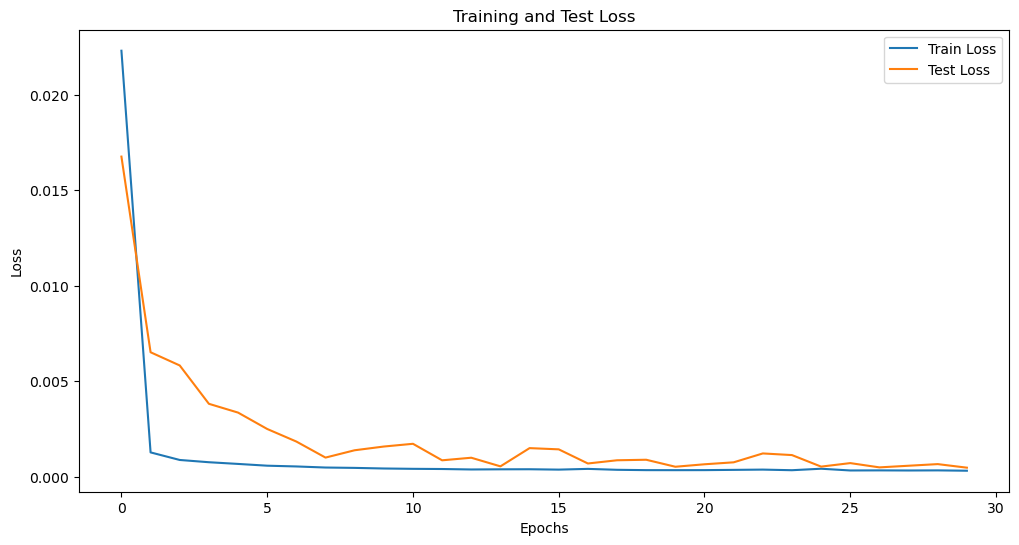

1/1 [==============================] - 0s 21ms/step


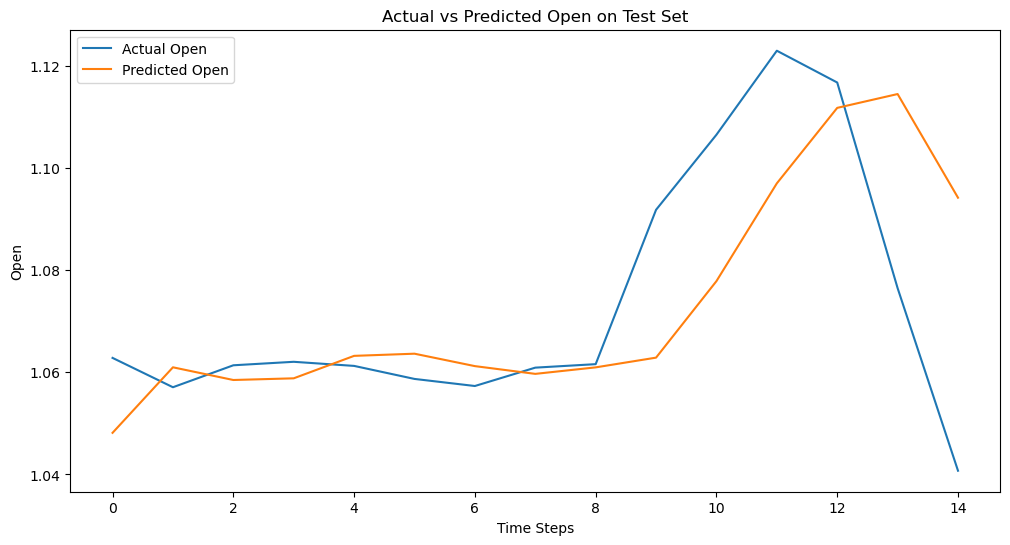

In [ ]:
# Plot training and test loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')  
plt.title('Training and Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Generate predictions for the test set
test_predictions = model.predict(X_test)

# Plot actual vs. predicted values for the test set
plt.figure(figsize=(12, 6))
plt.plot(y_test.flatten(), label='Actual Open')
plt.plot(test_predictions.flatten(), label='Predicted Open')
plt.title('Actual vs Predicted Open on Test Set')
plt.xlabel('Time Steps')
plt.ylabel('Open')
plt.legend()
plt.show()


# 3. GRU Baseline

In [ ]:
N = 30  # Number of past days
M = 1   # Number of future days (predict the next day)

# Prepare the dataset using the Open feature (univariate)
def create_sequences(data, N, M):
    X, y = [], []
    for i in range(len(data) - N - M + 1):
        X.append(data[i:i+N])  # Past N days (input)
        y.append(data[i+N:i+N+M])  # Next M days (output: single feature)
    return np.array(X), np.array(y)

train_data = train_set[['Open']].values
val_data = validation_set[['Open']].values

# Create sequences for training and validation data
X_train, y_train = create_sequences(train_data, N, M)
X_val, y_val = create_sequences(val_data, N, M)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1)) 
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1)) 

#  GRU model - single layer
regressor = Sequential()
regressor.add(GRU(units=50, activation='tanh', input_shape=(X_train.shape[1], 1)))
regressor.add(Dense(units=M))
regressor.compile(optimizer='Adam', loss='mean_squared_error')

Training data shape: X_train=(976, 30, 1), y_train=(976, 1, 1)
Validation data shape: X_val=(222, 30, 1), y_val=(222, 1, 1)
Epoch 1/50
31/31 [==============================] - 3s 12ms/step - loss: 0.0702 - val_loss: 0.1658
Epoch 2/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0292 - val_loss: 0.1228
Epoch 3/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0238 - val_loss: 0.0994
Epoch 4/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0194 - val_loss: 0.0817
Epoch 5/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0157 - val_loss: 0.0652
Epoch 6/50
31/31 [==============================] - 0s 5ms/step - loss: 0.0127 - val_loss: 0.0518
Epoch 7/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0102 - val_loss: 0.0411
Epoch 8/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0082 - val_loss: 0.0328
Epoch 9/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0066 - val_loss: 

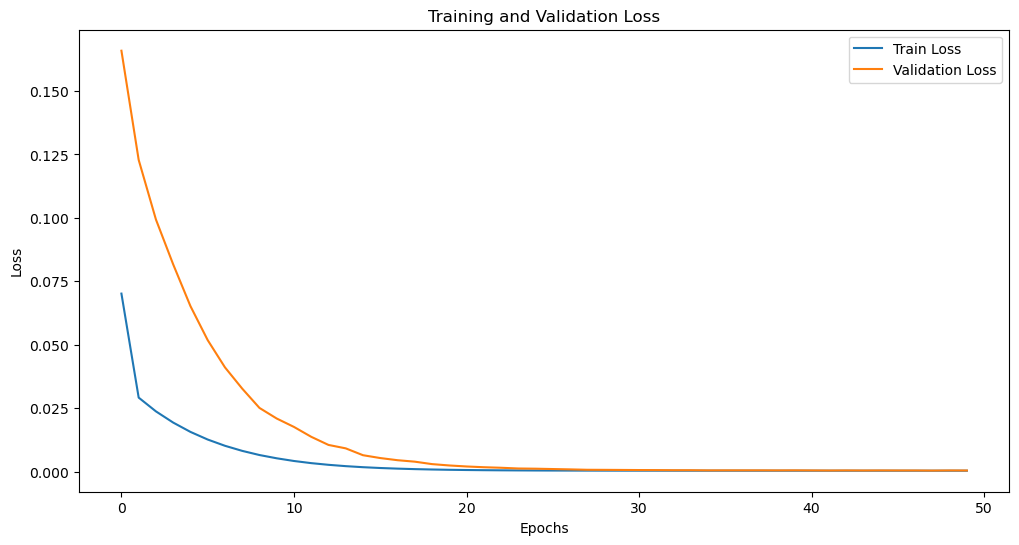

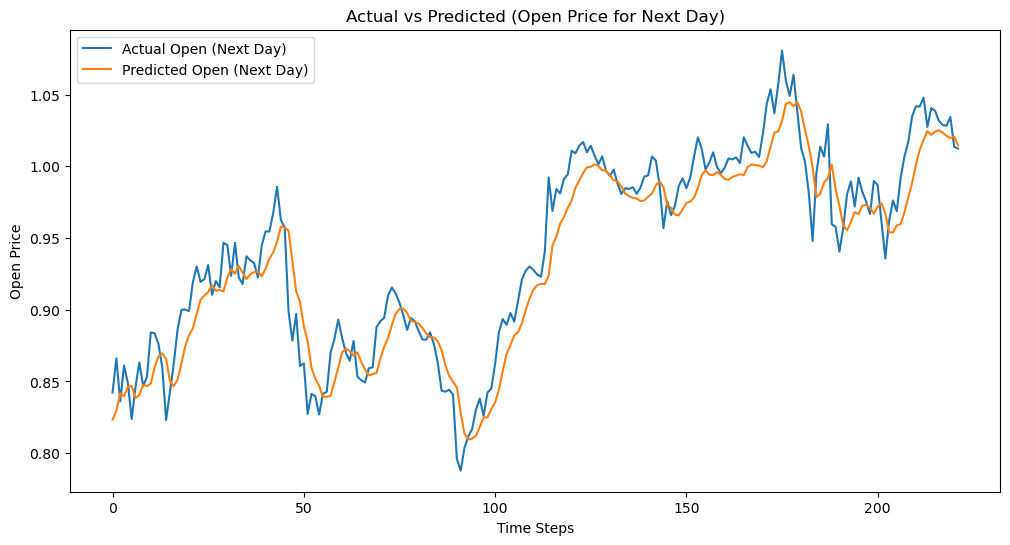

In [ ]:
print(f"Training data shape: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Validation data shape: X_val={X_val.shape}, y_val={y_val.shape}")

# Train the model
history = regressor.fit(X_train, y_train, 
                        epochs=50, batch_size=32,
                        validation_data=(X_val, y_val),
                        verbose=1)

# Evaluate on validation data
val_predictions = regressor.predict(X_val)

y_val_flattened = y_val.flatten()
val_predictions_flattened = val_predictions.flatten()

#  RMSE
val_rmse = sqrt(mean_squared_error(y_val_flattened, val_predictions_flattened))
print(f"Validation RMSE: {val_rmse:.4f}")

# Visualize training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Visualize actual vs. predicted for the 'Open' feature
plt.figure(figsize=(12, 6))
plt.plot(y_val_flattened, label='Actual Open (Next Day)')
plt.plot(val_predictions_flattened, label='Predicted Open (Next Day)')
plt.title('Actual vs Predicted (Open Price for Next Day)')
plt.xlabel('Time Steps')
plt.ylabel('Open Price')
plt.legend()
plt.show()


# hyperparameter tuning for GRU 

In [ ]:
N = 30  # Number of past days
M = 1   # Number of future days (predict the next day)

# Prepare the dataset using the Open feature (univariate)
def create_sequences(data, N, M):
    X, y = [], []
    for i in range(len(data) - N - M + 1):
        X.append(data[i:i+N])  # Past N days (input)
        y.append(data[i+N:i+N+M])  # Next M days (output: single feature)
    return np.array(X), np.array(y)

In [ ]:
#  only the 'Open' column for univariate prediction
train_data = train_set[['Open']].values
val_data = validation_set[['Open']].values

X_train, y_train = create_sequences(train_data, N, M)
X_val, y_val = create_sequences(val_data, N, M)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))  
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))  

print(f"Training data shape: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Validation data shape: X_val={X_val.shape}, y_val={y_val.shape}")

# Optuna objective function
def objective(trial):
    # hyperparameter search space
    units = trial.suggest_categorical("units", [20, 50, 100])
    layers = trial.suggest_int("layers", 1, 3)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
    optimizer_name = trial.suggest_categorical("optimizer", ["SGD", "Adam"])
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])

    # GRU model
    regressor = Sequential()
    for i in range(layers):
        if i == 0: 
            regressor.add(GRU(units=units, activation='tanh', return_sequences=(i < layers - 1), input_shape=(X_train.shape[1], 1)))
        else:  
            regressor.add(GRU(units=units, activation='tanh', return_sequences=(i < layers - 1)))
    regressor.add(Dense(units=M)) 

    # optimizers
    if optimizer_name == "SGD":
        optimizer = SGD(learning_rate=learning_rate)
    else:
        optimizer = Adam(learning_rate=learning_rate)
    regressor.compile(optimizer=optimizer, loss='mean_squared_error')

    # Early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=0)
    history = regressor.fit(
        X_train, y_train,
        epochs=30,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping],
        verbose=0  
    )

    # Evaluate the model
    val_predictions = regressor.predict(X_val)
    val_rmse = sqrt(mean_squared_error(y_val.flatten(), val_predictions.flatten()))
    return val_rmse

#  Optuna optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

#  best parameters
print("\nBest Hyperparameters:")
print(study.best_params)
print(f"Best Validation RMSE: {study.best_value:.4f}")

# Train and Evaluate the Best Model
best_params = study.best_params
best_model = Sequential()
for i in range(best_params['layers']):
    if i == 0: 
        best_model.add(GRU(units=best_params['units'], activation='tanh', return_sequences=(i < best_params['layers'] - 1), input_shape=(X_train.shape[1], 1)))
    else:  
        best_model.add(GRU(units=best_params['units'], activation='tanh', return_sequences=(i < best_params['layers'] - 1)))
best_model.add(Dense(units=M))  

# optimizer
if best_params['optimizer'] == "SGD":
    optimizer = SGD(learning_rate=best_params['learning_rate'])
else:
    optimizer = Adam(learning_rate=best_params['learning_rate'])
best_model.compile(optimizer=optimizer, loss='mean_squared_error')

[I 2024-11-23 18:26:27,340] A new study created in memory with name: no-name-e03756db-18e6-49f0-8e1a-f3a526a245b3


Training data shape: X_train=(976, 30, 1), y_train=(976, 1, 1)
Validation data shape: X_val=(222, 30, 1), y_val=(222, 1, 1)
7/7 [==============================] - 0s 2ms/step


[I 2024-11-23 18:26:29,712] Trial 0 finished with value: 0.023932978510005535 and parameters: {'units': 50, 'layers': 1, 'learning_rate': 0.0008210835951958726, 'optimizer': 'Adam', 'batch_size': 64}. Best is trial 0 with value: 0.023932978510005535.


7/7 [==============================] - 0s 6ms/step


[I 2024-11-23 18:26:44,109] Trial 1 finished with value: 0.39321516626996555 and parameters: {'units': 20, 'layers': 3, 'learning_rate': 0.0007745104702204512, 'optimizer': 'SGD', 'batch_size': 32}. Best is trial 0 with value: 0.023932978510005535.


7/7 [==============================] - 0s 4ms/step


[I 2024-11-23 18:26:51,792] Trial 2 finished with value: 0.016654947464587903 and parameters: {'units': 20, 'layers': 2, 'learning_rate': 0.00773519924121048, 'optimizer': 'Adam', 'batch_size': 16}. Best is trial 2 with value: 0.016654947464587903.


7/7 [==============================] - 0s 4ms/step


[I 2024-11-23 18:27:08,283] Trial 3 finished with value: 0.027026643507662405 and parameters: {'units': 20, 'layers': 2, 'learning_rate': 0.004360333130762401, 'optimizer': 'SGD', 'batch_size': 16}. Best is trial 2 with value: 0.016654947464587903.


7/7 [==============================] - 0s 5ms/step


[I 2024-11-23 18:27:16,346] Trial 4 finished with value: 0.021280239885368007 and parameters: {'units': 100, 'layers': 2, 'learning_rate': 0.00027757245991778004, 'optimizer': 'Adam', 'batch_size': 64}. Best is trial 2 with value: 0.016654947464587903.


7/7 [==============================] - 0s 4ms/step


[I 2024-11-23 18:27:27,077] Trial 5 finished with value: 0.01786907063141294 and parameters: {'units': 20, 'layers': 2, 'learning_rate': 0.0012897696291864398, 'optimizer': 'Adam', 'batch_size': 16}. Best is trial 2 with value: 0.016654947464587903.


7/7 [==============================] - 0s 4ms/step


[I 2024-11-23 18:27:34,294] Trial 6 finished with value: 0.02065081835175807 and parameters: {'units': 20, 'layers': 2, 'learning_rate': 0.001005386891774889, 'optimizer': 'Adam', 'batch_size': 64}. Best is trial 2 with value: 0.016654947464587903.


7/7 [==============================] - 1s 3ms/step


[I 2024-11-23 18:27:40,559] Trial 7 finished with value: 0.02217060057481428 and parameters: {'units': 20, 'layers': 1, 'learning_rate': 0.00035429225037508224, 'optimizer': 'Adam', 'batch_size': 32}. Best is trial 2 with value: 0.016654947464587903.


7/7 [==============================] - 1s 7ms/step


[I 2024-11-23 18:28:05,709] Trial 8 finished with value: 0.29312053782738534 and parameters: {'units': 20, 'layers': 3, 'learning_rate': 0.0009613907555176384, 'optimizer': 'SGD', 'batch_size': 16}. Best is trial 2 with value: 0.016654947464587903.


7/7 [==============================] - 0s 4ms/step


[I 2024-11-23 18:28:13,426] Trial 9 finished with value: 0.2725215723718428 and parameters: {'units': 50, 'layers': 1, 'learning_rate': 0.0014379091816005636, 'optimizer': 'SGD', 'batch_size': 32}. Best is trial 2 with value: 0.016654947464587903.


7/7 [==============================] - 0s 5ms/step


[I 2024-11-23 18:28:20,988] Trial 10 finished with value: 0.019217705419284768 and parameters: {'units': 100, 'layers': 3, 'learning_rate': 0.007810016894487934, 'optimizer': 'Adam', 'batch_size': 16}. Best is trial 2 with value: 0.016654947464587903.


7/7 [==============================] - 0s 4ms/step


[I 2024-11-23 18:28:29,768] Trial 11 finished with value: 0.016679019479805334 and parameters: {'units': 20, 'layers': 2, 'learning_rate': 0.003857887315592286, 'optimizer': 'Adam', 'batch_size': 16}. Best is trial 2 with value: 0.016654947464587903.


7/7 [==============================] - 0s 5ms/step


[I 2024-11-23 18:28:38,457] Trial 12 finished with value: 0.016655047983531665 and parameters: {'units': 20, 'layers': 2, 'learning_rate': 0.00413655455509942, 'optimizer': 'Adam', 'batch_size': 16}. Best is trial 2 with value: 0.016654947464587903.


7/7 [==============================] - 0s 7ms/step


[I 2024-11-23 18:28:47,473] Trial 13 finished with value: 0.01705747218021434 and parameters: {'units': 20, 'layers': 2, 'learning_rate': 0.00990268857168529, 'optimizer': 'Adam', 'batch_size': 16}. Best is trial 2 with value: 0.016654947464587903.


7/7 [==============================] - 0s 5ms/step


[I 2024-11-23 18:29:07,055] Trial 14 finished with value: 0.01653798796678358 and parameters: {'units': 100, 'layers': 3, 'learning_rate': 0.003201868954781851, 'optimizer': 'Adam', 'batch_size': 16}. Best is trial 14 with value: 0.01653798796678358.


7/7 [==============================] - 0s 7ms/step


[I 2024-11-23 18:29:18,670] Trial 15 finished with value: 0.016833200433789722 and parameters: {'units': 100, 'layers': 3, 'learning_rate': 0.0025596297691060656, 'optimizer': 'Adam', 'batch_size': 16}. Best is trial 14 with value: 0.01653798796678358.


7/7 [==============================] - 0s 5ms/step


[I 2024-11-23 18:29:29,405] Trial 16 finished with value: 0.01661619843624291 and parameters: {'units': 100, 'layers': 3, 'learning_rate': 0.0023216275189398457, 'optimizer': 'Adam', 'batch_size': 16}. Best is trial 14 with value: 0.01653798796678358.


7/7 [==============================] - 1s 5ms/step


[I 2024-11-23 18:29:46,286] Trial 17 finished with value: 0.023670906865052528 and parameters: {'units': 100, 'layers': 3, 'learning_rate': 0.00012467681442771483, 'optimizer': 'Adam', 'batch_size': 16}. Best is trial 14 with value: 0.01653798796678358.


7/7 [==============================] - 0s 5ms/step


[I 2024-11-23 18:30:00,069] Trial 18 finished with value: 0.30909336487832056 and parameters: {'units': 100, 'layers': 3, 'learning_rate': 0.002045821478304247, 'optimizer': 'SGD', 'batch_size': 32}. Best is trial 14 with value: 0.01653798796678358.


7/7 [==============================] - 0s 6ms/step


[I 2024-11-23 18:30:08,143] Trial 19 finished with value: 0.016929579588935362 and parameters: {'units': 100, 'layers': 3, 'learning_rate': 0.0025324463506662493, 'optimizer': 'Adam', 'batch_size': 64}. Best is trial 14 with value: 0.01653798796678358.


7/7 [==============================] - 0s 5ms/step


[I 2024-11-23 18:30:14,294] Trial 20 finished with value: 0.020121919639689144 and parameters: {'units': 100, 'layers': 3, 'learning_rate': 0.005080290920029333, 'optimizer': 'Adam', 'batch_size': 16}. Best is trial 14 with value: 0.01653798796678358.


7/7 [==============================] - 0s 4ms/step


[I 2024-11-23 18:30:19,127] Trial 21 finished with value: 0.018260257656465384 and parameters: {'units': 100, 'layers': 2, 'learning_rate': 0.00686926040540483, 'optimizer': 'Adam', 'batch_size': 16}. Best is trial 14 with value: 0.01653798796678358.


7/7 [==============================] - 0s 6ms/step


[I 2024-11-23 18:30:30,141] Trial 22 finished with value: 0.016501105391985144 and parameters: {'units': 50, 'layers': 3, 'learning_rate': 0.002880815048623893, 'optimizer': 'Adam', 'batch_size': 16}. Best is trial 22 with value: 0.016501105391985144.


7/7 [==============================] - 0s 5ms/step


[I 2024-11-23 18:30:44,030] Trial 23 finished with value: 0.01660676684741938 and parameters: {'units': 50, 'layers': 3, 'learning_rate': 0.0019514325430142073, 'optimizer': 'Adam', 'batch_size': 16}. Best is trial 22 with value: 0.016501105391985144.


7/7 [==============================] - 0s 5ms/step


[I 2024-11-23 18:30:56,092] Trial 24 finished with value: 0.018111792865833372 and parameters: {'units': 50, 'layers': 3, 'learning_rate': 0.0016974133992516001, 'optimizer': 'Adam', 'batch_size': 16}. Best is trial 22 with value: 0.016501105391985144.


7/7 [==============================] - 0s 6ms/step


[I 2024-11-23 18:31:06,567] Trial 25 finished with value: 0.016501320154260753 and parameters: {'units': 50, 'layers': 3, 'learning_rate': 0.0031659650554478223, 'optimizer': 'Adam', 'batch_size': 16}. Best is trial 22 with value: 0.016501105391985144.


7/7 [==============================] - 0s 5ms/step


[I 2024-11-23 18:31:27,731] Trial 26 finished with value: 0.06080622254782181 and parameters: {'units': 50, 'layers': 3, 'learning_rate': 0.0031535064377719835, 'optimizer': 'SGD', 'batch_size': 16}. Best is trial 22 with value: 0.016501105391985144.


7/7 [==============================] - 0s 5ms/step


[I 2024-11-23 18:31:49,293] Trial 27 finished with value: 0.016895445605874665 and parameters: {'units': 50, 'layers': 3, 'learning_rate': 0.00045795702433816353, 'optimizer': 'Adam', 'batch_size': 16}. Best is trial 22 with value: 0.016501105391985144.


7/7 [==============================] - 0s 5ms/step


[I 2024-11-23 18:31:57,356] Trial 28 finished with value: 0.016591577907816464 and parameters: {'units': 50, 'layers': 3, 'learning_rate': 0.0031541335102483266, 'optimizer': 'Adam', 'batch_size': 64}. Best is trial 22 with value: 0.016501105391985144.


7/7 [==============================] - 0s 2ms/step


[I 2024-11-23 18:32:03,430] Trial 29 finished with value: 0.022742642646786968 and parameters: {'units': 50, 'layers': 1, 'learning_rate': 0.005614241016942756, 'optimizer': 'Adam', 'batch_size': 32}. Best is trial 22 with value: 0.016501105391985144.


7/7 [==============================] - 0s 5ms/step


[I 2024-11-23 18:32:12,615] Trial 30 finished with value: 0.02151218671420651 and parameters: {'units': 50, 'layers': 3, 'learning_rate': 0.0007261602701548219, 'optimizer': 'Adam', 'batch_size': 64}. Best is trial 22 with value: 0.016501105391985144.


7/7 [==============================] - 0s 5ms/step


[I 2024-11-23 18:32:18,986] Trial 31 finished with value: 0.01771518781983664 and parameters: {'units': 50, 'layers': 3, 'learning_rate': 0.0029885863957527722, 'optimizer': 'Adam', 'batch_size': 64}. Best is trial 22 with value: 0.016501105391985144.


7/7 [==============================] - 0s 8ms/step


[I 2024-11-23 18:32:26,453] Trial 32 finished with value: 0.01675300618790729 and parameters: {'units': 50, 'layers': 3, 'learning_rate': 0.003499296260947731, 'optimizer': 'Adam', 'batch_size': 64}. Best is trial 22 with value: 0.016501105391985144.


7/7 [==============================] - 0s 5ms/step


[I 2024-11-23 18:32:33,088] Trial 33 finished with value: 0.021254417272801054 and parameters: {'units': 50, 'layers': 3, 'learning_rate': 0.0013817495817822004, 'optimizer': 'Adam', 'batch_size': 64}. Best is trial 22 with value: 0.016501105391985144.


7/7 [==============================] - 0s 5ms/step


[I 2024-11-23 18:32:42,358] Trial 34 finished with value: 0.21496600004635766 and parameters: {'units': 50, 'layers': 3, 'learning_rate': 0.004717823539232823, 'optimizer': 'SGD', 'batch_size': 64}. Best is trial 22 with value: 0.016501105391985144.


7/7 [==============================] - 0s 5ms/step


[I 2024-11-23 18:32:48,813] Trial 35 finished with value: 0.01644034390836351 and parameters: {'units': 50, 'layers': 3, 'learning_rate': 0.005960578238684364, 'optimizer': 'Adam', 'batch_size': 64}. Best is trial 35 with value: 0.01644034390836351.


7/7 [==============================] - 0s 5ms/step


[I 2024-11-23 18:32:56,425] Trial 36 finished with value: 0.0171943093860908 and parameters: {'units': 50, 'layers': 3, 'learning_rate': 0.006642762231803667, 'optimizer': 'Adam', 'batch_size': 16}. Best is trial 35 with value: 0.01644034390836351.


7/7 [==============================] - 0s 3ms/step


[I 2024-11-23 18:33:02,010] Trial 37 finished with value: 0.01637555170632583 and parameters: {'units': 50, 'layers': 2, 'learning_rate': 0.009192481999696148, 'optimizer': 'Adam', 'batch_size': 32}. Best is trial 37 with value: 0.01637555170632583.


7/7 [==============================] - 0s 3ms/step


[I 2024-11-23 18:33:12,036] Trial 38 finished with value: 0.027675041566394026 and parameters: {'units': 50, 'layers': 2, 'learning_rate': 0.009930751163195365, 'optimizer': 'SGD', 'batch_size': 32}. Best is trial 37 with value: 0.01637555170632583.


7/7 [==============================] - 0s 4ms/step


[I 2024-11-23 18:33:17,616] Trial 39 finished with value: 0.016466680017426294 and parameters: {'units': 50, 'layers': 2, 'learning_rate': 0.005732863370103074, 'optimizer': 'Adam', 'batch_size': 32}. Best is trial 37 with value: 0.01637555170632583.


7/7 [==============================] - 0s 4ms/step


[I 2024-11-23 18:33:23,418] Trial 40 finished with value: 0.0164171139362803 and parameters: {'units': 50, 'layers': 2, 'learning_rate': 0.008152793783427651, 'optimizer': 'Adam', 'batch_size': 32}. Best is trial 37 with value: 0.01637555170632583.


7/7 [==============================] - 0s 4ms/step


[I 2024-11-23 18:33:28,830] Trial 41 finished with value: 0.0163878891018077 and parameters: {'units': 50, 'layers': 2, 'learning_rate': 0.00820362415419183, 'optimizer': 'Adam', 'batch_size': 32}. Best is trial 37 with value: 0.01637555170632583.


7/7 [==============================] - 0s 5ms/step


[I 2024-11-23 18:33:36,138] Trial 42 finished with value: 0.01633749796563455 and parameters: {'units': 50, 'layers': 2, 'learning_rate': 0.0083191521183569, 'optimizer': 'Adam', 'batch_size': 32}. Best is trial 42 with value: 0.01633749796563455.


7/7 [==============================] - 0s 4ms/step


[I 2024-11-23 18:33:41,820] Trial 43 finished with value: 0.01672409084573446 and parameters: {'units': 50, 'layers': 2, 'learning_rate': 0.008128366081238545, 'optimizer': 'Adam', 'batch_size': 32}. Best is trial 42 with value: 0.01633749796563455.


7/7 [==============================] - 0s 4ms/step


[I 2024-11-23 18:33:47,288] Trial 44 finished with value: 0.016341498883656397 and parameters: {'units': 50, 'layers': 2, 'learning_rate': 0.007711953664932229, 'optimizer': 'Adam', 'batch_size': 32}. Best is trial 42 with value: 0.01633749796563455.


7/7 [==============================] - 0s 3ms/step


[I 2024-11-23 18:33:52,371] Trial 45 finished with value: 0.016416685427385683 and parameters: {'units': 50, 'layers': 2, 'learning_rate': 0.008134382981086838, 'optimizer': 'Adam', 'batch_size': 32}. Best is trial 42 with value: 0.01633749796563455.


7/7 [==============================] - 0s 4ms/step


[I 2024-11-23 18:33:57,808] Trial 46 finished with value: 0.016460086390430916 and parameters: {'units': 50, 'layers': 2, 'learning_rate': 0.009493312060164768, 'optimizer': 'Adam', 'batch_size': 32}. Best is trial 42 with value: 0.01633749796563455.


7/7 [==============================] - 0s 5ms/step


[I 2024-11-23 18:34:07,754] Trial 47 finished with value: 0.036327939020202815 and parameters: {'units': 50, 'layers': 2, 'learning_rate': 0.00727432083823609, 'optimizer': 'SGD', 'batch_size': 32}. Best is trial 42 with value: 0.01633749796563455.


7/7 [==============================] - 0s 4ms/step


[I 2024-11-23 18:34:14,750] Trial 48 finished with value: 0.01666279900861994 and parameters: {'units': 50, 'layers': 2, 'learning_rate': 0.004143804754026123, 'optimizer': 'Adam', 'batch_size': 32}. Best is trial 42 with value: 0.01633749796563455.


7/7 [==============================] - 0s 4ms/step


[I 2024-11-23 18:34:20,426] Trial 49 finished with value: 0.016430632643113452 and parameters: {'units': 50, 'layers': 2, 'learning_rate': 0.008552685622481957, 'optimizer': 'Adam', 'batch_size': 32}. Best is trial 42 with value: 0.01633749796563455.



Best Hyperparameters:
{'units': 50, 'layers': 2, 'learning_rate': 0.0083191521183569, 'optimizer': 'Adam', 'batch_size': 32}
Best Validation RMSE: 0.0163


In [ ]:
#  best parameters
print("\nBest Hyperparameters:")
print(study.best_params)
print(f"Best Validation RMSE: {study.best_value:.4f}")



Best Hyperparameters:
{'units': 50, 'layers': 2, 'learning_rate': 0.0083191521183569, 'optimizer': 'Adam', 'batch_size': 32}
Best Validation RMSE: 0.0163


# Testing GRU

In [ ]:
# concatenating validation and traing dataset to retarin on the best model and evaluate on the test dataset
combined_data_GRU = np.concatenate([train_set, validation_set], axis=0)
combined_data_GRU = pd.DataFrame(combined_data_GRU, columns=['Date','Open', 'High', 'Low', 'Close', 'Volume'])

#  MinMaxScaler
scaler = MinMaxScaler()

# A transformation to the combined dataset
combined_data_GRU[columns_to_normalize] = scaler.fit_transform(combined_data_GRU[columns_to_normalize])

In [ ]:
def create_sequences(data, N, M):

    X, y = [], []
    
    # Iterate through the data to create sequences
    for i in range(len(data) - N - M + 1):
        input_sequence = data[i:i+N]  # Past N days
        output_sequence = data[i+N:i+N+M]  # Next M days
        X.append(input_sequence)
        y.append(output_sequence)
    
    # Convert to numpy arrays
    X_array = np.array(X)
    y_array = np.array(y)
    return X_array, y_array

In [ ]:
# Parameters for sequence creation
N = 5  # Number of past days
M = 1  # Number of future days (predict the next day)


combined_data_open = combined_data_GRU['Open'].values

X_train, y_train = create_sequences(combined_data_open, N=N, M=M)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))  

# Prepare sequences for the test dataset
test_data_open = test_data['Open'].values
X_test, y_test = create_sequences(test_data_open, N=N, M=M)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1)) 

In [ ]:
#  GRU model with best hyperparameters
def create_model(input_shape, units, layers, learning_rate):
    model = Sequential()
    for i in range(layers):
        if i == 0:
            model.add(GRU(units, activation='tanh', return_sequences=(i < layers - 1), input_shape=input_shape))
        else:
            model.add(GRU(units, activation='tanh', return_sequences=(i < layers - 1)))
    model.add(Dense(1)) 
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse')
    return model

# Best hyperparameters
best_params = {
    'units': 50,
    'layers': 2,
    'learning_rate':  0.0083191521183569,
    'batch_size': 32,
}

units = best_params['units']
layers = best_params['layers']
learning_rate = best_params['learning_rate']
batch_size = best_params['batch_size']

# Create the model
input_shape = (X_train.shape[1], X_train.shape[2]) 
model = create_model(input_shape, units, layers, learning_rate)

# Train the model on the full combined dataset
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=batch_size,
    verbose=1,
    validation_data=(X_test, y_test)
)

# Evaluate the model on the test set
test_predictions = model.predict(X_test)
test_rmse = sqrt(mean_squared_error(y_test.flatten(), test_predictions.flatten()))
print(f"Test RMSE: {test_rmse:.4f}")


Epoch 1/30
40/40 [==============================] - 2s 13ms/step - loss: 0.0178 - val_loss: 0.0050
Epoch 2/30
40/40 [==============================] - 0s 6ms/step - loss: 5.0025e-04 - val_loss: 0.0019
Epoch 3/30
40/40 [==============================] - 0s 6ms/step - loss: 4.5092e-04 - val_loss: 6.4452e-04
Epoch 4/30
40/40 [==============================] - 0s 5ms/step - loss: 4.3796e-04 - val_loss: 8.3546e-04
Epoch 5/30
40/40 [==============================] - 0s 5ms/step - loss: 4.9085e-04 - val_loss: 6.2771e-04
Epoch 6/30
40/40 [==============================] - 0s 5ms/step - loss: 3.9748e-04 - val_loss: 6.4542e-04
Epoch 7/30
40/40 [==============================] - 0s 5ms/step - loss: 4.0853e-04 - val_loss: 6.2832e-04
Epoch 8/30
40/40 [==============================] - 0s 5ms/step - loss: 4.1402e-04 - val_loss: 0.0024
Epoch 9/30
40/40 [==============================] - 0s 5ms/step - loss: 6.2077e-04 - val_loss: 7.5003e-04
Epoch 10/30
40/40 [==============================] - 0s 5ms/s

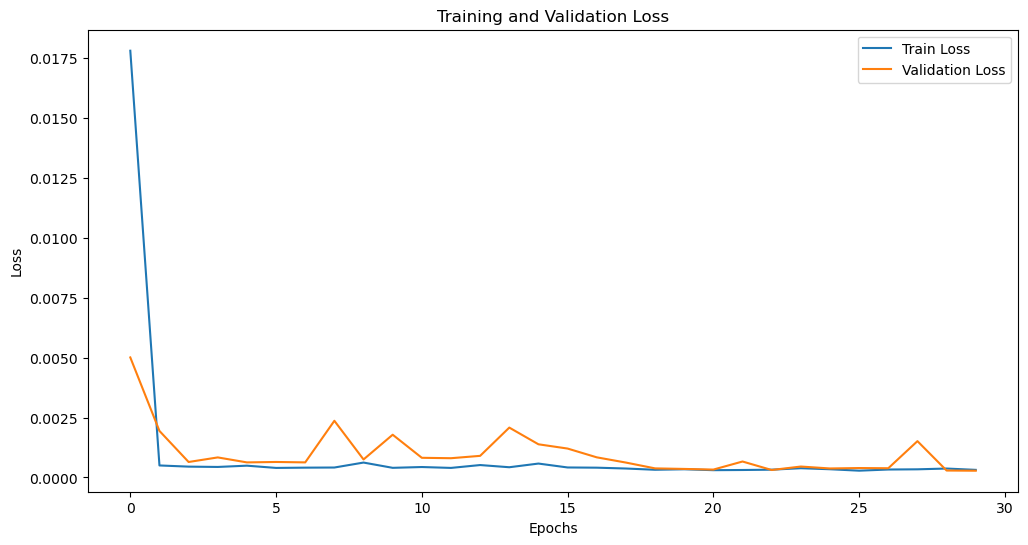

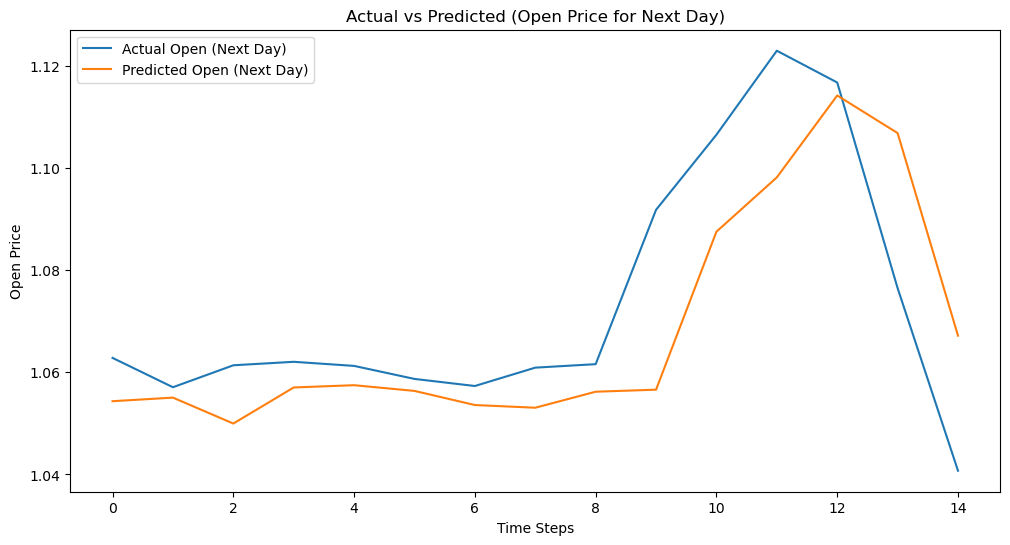

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test.flatten(), label='Actual Open (Next Day)')
plt.plot(test_predictions.flatten(), label='Predicted Open (Next Day)')
plt.title('Actual vs Predicted (Open Price for Next Day)')
plt.xlabel('Time Steps')
plt.ylabel('Open Price')
plt.legend()
plt.show()


# Multivarate

# 1. LSTM baseline

In [ ]:
N = 30  # Number of past days
M = 1   # Number of future days (predict the next day)

# the dataset using multiple features (multivariate)
def create_sequences_multivariate(data, N, M):
    X, y = [], []
    for i in range(len(data) - N - M + 1):
        X.append(data[i:i+N, :])  # Past N days (input with all features)
        y.append(data[i+N:i+N+M, 0])  # Predict next M days' 'Open' value (only one feature as output)
    return np.array(X), np.array(y)

In [ ]:

#  train_set and validation_set are pandas DataFrames with columns: Open, High, Low, Close, Volume - multivarate
train_data = train_set[['Open', 'High', 'Low', 'Close', 'Volume']].values
val_data = validation_set[['Open', 'High', 'Low', 'Close', 'Volume']].values

# Create sequences for training and validation data
X_train, y_train = create_sequences_multivariate(train_data, N, M)
X_val, y_val = create_sequences_multivariate(val_data, N, M)


print(f"Before Reshaping: X_train shape = {X_train.shape}")
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], X_val.shape[2]))
print(f"Training data shape: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Validation data shape: X_val={X_val.shape}, y_val={y_val.shape}")

#  LSTM model
regressor = Sequential()

# LSTM Layer
regressor.add(LSTM(units=50, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
regressor.add(Dense(units=M)) 
regressor.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = regressor.fit(X_train, y_train,
                        epochs=50, batch_size=32,
                        validation_data=(X_val, y_val),
                        verbose=1)

# Evaluate on validation data
val_predictions = regressor.predict(X_val)

# Flatten the arrays to make them 1D
y_val_flattened = y_val.flatten()
val_predictions_flattened = val_predictions.flatten()

# Calculate RMSE
val_rmse = sqrt(mean_squared_error(y_val_flattened, val_predictions_flattened))
print(f"Validation RMSE: {val_rmse:.4f}")


Before Reshaping: X_train shape = (976, 30, 5)
Training data shape: X_train=(976, 30, 5), y_train=(976, 1)
Validation data shape: X_val=(222, 30, 5), y_val=(222, 1)
Epoch 1/50
31/31 [==============================] - 4s 21ms/step - loss: 0.0246 - val_loss: 0.0031
Epoch 2/50
31/31 [==============================] - 0s 9ms/step - loss: 0.0039 - val_loss: 0.0067
Epoch 3/50
31/31 [==============================] - 0s 10ms/step - loss: 0.0038 - val_loss: 0.0011
Epoch 4/50
31/31 [==============================] - 0s 10ms/step - loss: 0.0040 - val_loss: 0.0021
Epoch 5/50
31/31 [==============================] - 0s 9ms/step - loss: 0.0034 - val_loss: 0.0024
Epoch 6/50
31/31 [==============================] - 0s 9ms/step - loss: 0.0033 - val_loss: 0.0010
Epoch 7/50
31/31 [==============================] - 0s 9ms/step - loss: 0.0034 - val_loss: 0.0011
Epoch 8/50
31/31 [==============================] - 0s 10ms/step - loss: 0.0028 - val_loss: 8.9202e-04
Epoch 9/50
31/31 [=========================

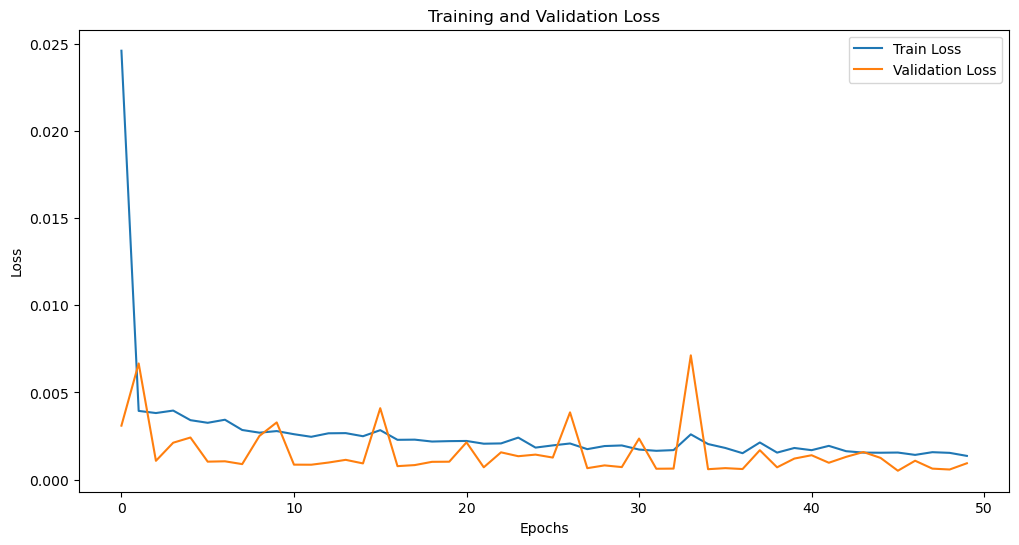

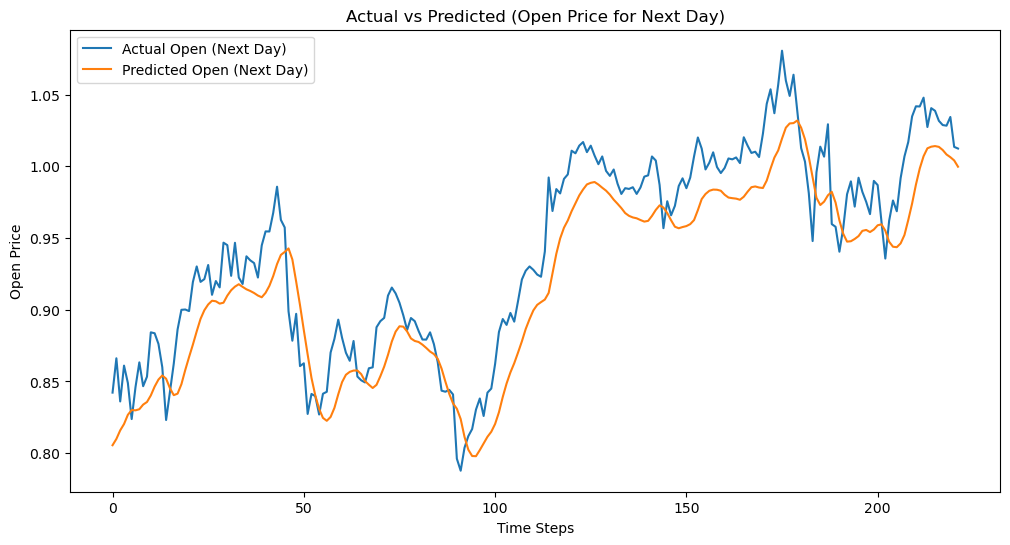

In [21]:
# Visualize training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Visualize actual vs. predicted for the 'Open' feature
plt.figure(figsize=(12, 6))
plt.plot(y_val_flattened, label='Actual Open (Next Day)')
plt.plot(val_predictions_flattened, label='Predicted Open (Next Day)')
plt.title('Actual vs Predicted (Open Price for Next Day)')
plt.xlabel('Time Steps')
plt.ylabel('Open Price')
plt.legend()
plt.show()

# HYperparameter Lstm

In [ ]:
# Function to create multivariate sequences
def create_sequences_multivariate(data, target_column_index, N, M):
    X, y = [], []
    for i in range(len(data) - N - M + 1):
        X.append(data[i:i + N, :])  # Past N days for all features
        y.append(data[i + N:i + N + M, target_column_index])  # Predict next M days' target column
    return np.array(X), np.array(y)

In [ ]:
N = 30  # Number of past days
M = 1   # Predict 1 day ahead

# `train_set` and `validation_set` are DataFrames with required columns - multivariate
train_data = train_set[['Open', 'High', 'Low', 'Close', 'Volume']].values
val_data = validation_set[['Open', 'High', 'Low', 'Close', 'Volume']].values

# Specify the target column index (e.g., 'Open' is index 0)
target_column_index = 0

#  sequences for training and validation
X_train, y_train = create_sequences_multivariate(train_data, target_column_index, N, M)
X_val, y_val = create_sequences_multivariate(val_data, target_column_index, N, M)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], X_val.shape[2]))

#  LSTM model
def create_lstm_model(input_shape, units, layers, activation, optimizer, learning_rate, output_units):
    model = Sequential()

    # Add LSTM layers
    for i in range(layers):
        if i == 0:  
            model.add(
                LSTM(
                    units=units, activation=activation, return_sequences=(i < layers - 1),
                    input_shape=input_shape
                )
            )
        else: 
            model.add(
                LSTM(
                    units=units, activation=activation, return_sequences=(i < layers - 1)
                )
            )
      
    model.add(Dense(units=output_units))

    # optimizer
    if optimizer.lower() == 'sgd':
        opt = SGD(learning_rate=learning_rate)
    elif optimizer.lower() == 'adam':
        opt = Adam(learning_rate=learning_rate)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer}")

    # Compile the model
    model.compile(optimizer=opt, loss='mean_squared_error')
    return model

In [ ]:
# Optuna Objective Function
def objective(trial):
    #  hyperparameter search space
    units = trial.suggest_categorical("units", [20, 50, 100])
    layers = trial.suggest_int("layers", 1, 5)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-8, 1e-2)
    optimizer = trial.suggest_categorical("optimizer", ["SGD", "Adam"])
    
    # lstm model
    model = create_lstm_model(
        input_shape=(X_train.shape[1], X_train.shape[2]),
        units=units,
        layers=layers,
        activation="tanh",
        optimizer=optimizer,
        learning_rate=learning_rate,
        output_units=M
    )

    # Train the model
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=0)
    history = model.fit(
        X_train, y_train,
        epochs=30,
        batch_size=32,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping],
        verbose=0
    )

    # Evaluate the model
    val_predictions = model.predict(X_val)
    val_rmse = sqrt(mean_squared_error(y_val.flatten(), val_predictions.flatten()))
    return val_rmse

# Run Optuna optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

# Print the best parameters
print("\nBest Hyperparameters:")
print(study.best_params)
print(f"Best Validation RMSE: {study.best_value:.4f}")

# Train and Evaluate the Best Model
best_params = study.best_params
best_model = create_lstm_model(
    input_shape=(X_train.shape[1], X_train.shape[2]),
    units=best_params['units'],
    layers=best_params['layers'],
    activation="tanh",
    optimizer=best_params['optimizer'],
    learning_rate=best_params['learning_rate'],
    output_units=M
)


[I 2024-11-24 21:06:28,765] A new study created in memory with name: no-name-893d8d5d-e74b-49f3-b06a-22b3b4620516


7/7 [==============================] - 1s 7ms/step


[I 2024-11-24 21:06:48,249] Trial 0 finished with value: 0.09148519650235519 and parameters: {'units': 50, 'layers': 4, 'learning_rate': 0.008374977706267167, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.09148519650235519.


7/7 [==============================] - 1s 8ms/step


[I 2024-11-24 21:07:12,457] Trial 1 finished with value: 0.8963952286037892 and parameters: {'units': 100, 'layers': 5, 'learning_rate': 2.1324862431837554e-07, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.09148519650235519.


7/7 [==============================] - 0s 3ms/step


[I 2024-11-24 21:07:22,590] Trial 2 finished with value: 0.8626896016347683 and parameters: {'units': 20, 'layers': 2, 'learning_rate': 2.0410586125267389e-07, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.09148519650235519.


7/7 [==============================] - 0s 7ms/step


[I 2024-11-24 21:07:37,718] Trial 3 finished with value: 0.03946160730096041 and parameters: {'units': 100, 'layers': 3, 'learning_rate': 0.00011746749838700314, 'optimizer': 'Adam'}. Best is trial 3 with value: 0.03946160730096041.


7/7 [==============================] - 0s 5ms/step


[I 2024-11-24 21:07:46,250] Trial 4 finished with value: 0.03430854834131169 and parameters: {'units': 20, 'layers': 3, 'learning_rate': 0.0034134521855117336, 'optimizer': 'Adam'}. Best is trial 4 with value: 0.03430854834131169.


7/7 [==============================] - 1s 8ms/step


[I 2024-11-24 21:08:10,284] Trial 5 finished with value: 0.8876228546019023 and parameters: {'units': 50, 'layers': 5, 'learning_rate': 3.46938766869552e-08, 'optimizer': 'Adam'}. Best is trial 4 with value: 0.03430854834131169.


7/7 [==============================] - 1s 7ms/step


[I 2024-11-24 21:08:20,343] Trial 6 finished with value: 0.04497708048641639 and parameters: {'units': 50, 'layers': 4, 'learning_rate': 0.0005798532024475324, 'optimizer': 'Adam'}. Best is trial 4 with value: 0.03430854834131169.


7/7 [==============================] - 0s 3ms/step


[I 2024-11-24 21:08:26,777] Trial 7 finished with value: 0.9910604503278859 and parameters: {'units': 50, 'layers': 1, 'learning_rate': 9.797140191962936e-08, 'optimizer': 'SGD'}. Best is trial 4 with value: 0.03430854834131169.


7/7 [==============================] - 1s 8ms/step


[I 2024-11-24 21:08:50,048] Trial 8 finished with value: 0.9027569274718251 and parameters: {'units': 20, 'layers': 5, 'learning_rate': 1.6279168874900833e-05, 'optimizer': 'SGD'}. Best is trial 4 with value: 0.03430854834131169.


7/7 [==============================] - 1s 6ms/step


[I 2024-11-24 21:08:59,017] Trial 9 finished with value: 0.03736184479614285 and parameters: {'units': 20, 'layers': 4, 'learning_rate': 0.008176140175299086, 'optimizer': 'Adam'}. Best is trial 4 with value: 0.03430854834131169.


7/7 [==============================] - 0s 3ms/step


[I 2024-11-24 21:09:09,178] Trial 10 finished with value: 0.7572692943576166 and parameters: {'units': 20, 'layers': 2, 'learning_rate': 3.607633805973985e-06, 'optimizer': 'Adam'}. Best is trial 4 with value: 0.03430854834131169.


7/7 [==============================] - 0s 6ms/step


[I 2024-11-24 21:09:17,995] Trial 11 finished with value: 0.02951469947542475 and parameters: {'units': 20, 'layers': 3, 'learning_rate': 0.009477242028194032, 'optimizer': 'Adam'}. Best is trial 11 with value: 0.02951469947542475.


7/7 [==============================] - 0s 5ms/step


[I 2024-11-24 21:09:27,768] Trial 12 finished with value: 0.03796744755335447 and parameters: {'units': 20, 'layers': 3, 'learning_rate': 0.0008718034149618227, 'optimizer': 'Adam'}. Best is trial 11 with value: 0.02951469947542475.


7/7 [==============================] - 0s 4ms/step


[I 2024-11-24 21:09:34,389] Trial 13 finished with value: 0.03726934975565893 and parameters: {'units': 20, 'layers': 2, 'learning_rate': 0.0009918486480942896, 'optimizer': 'Adam'}. Best is trial 11 with value: 0.02951469947542475.


7/7 [==============================] - 0s 5ms/step


[I 2024-11-24 21:09:49,047] Trial 14 finished with value: 0.1141609398576359 and parameters: {'units': 20, 'layers': 3, 'learning_rate': 3.165735567543726e-05, 'optimizer': 'Adam'}. Best is trial 11 with value: 0.02951469947542475.


7/7 [==============================] - 0s 2ms/step


[I 2024-11-24 21:09:53,436] Trial 15 finished with value: 0.01806218925678721 and parameters: {'units': 20, 'layers': 1, 'learning_rate': 0.007974436368372742, 'optimizer': 'Adam'}. Best is trial 15 with value: 0.01806218925678721.


7/7 [==============================] - 0s 3ms/step


[I 2024-11-24 21:09:57,302] Trial 16 finished with value: 0.032702112716740256 and parameters: {'units': 100, 'layers': 1, 'learning_rate': 0.00014188585790924062, 'optimizer': 'Adam'}. Best is trial 15 with value: 0.01806218925678721.


7/7 [==============================] - 0s 3ms/step


[I 2024-11-24 21:10:03,517] Trial 17 finished with value: 0.8254327081864 and parameters: {'units': 20, 'layers': 1, 'learning_rate': 1.8510609189607372e-06, 'optimizer': 'Adam'}. Best is trial 15 with value: 0.01806218925678721.


7/7 [==============================] - 0s 4ms/step


[I 2024-11-24 21:10:14,151] Trial 18 finished with value: 0.40170785104523754 and parameters: {'units': 20, 'layers': 2, 'learning_rate': 0.00018888264975222864, 'optimizer': 'SGD'}. Best is trial 15 with value: 0.01806218925678721.


7/7 [==============================] - 0s 2ms/step


[I 2024-11-24 21:10:18,453] Trial 19 finished with value: 0.019668241030995837 and parameters: {'units': 100, 'layers': 1, 'learning_rate': 0.0025830978214630065, 'optimizer': 'Adam'}. Best is trial 15 with value: 0.01806218925678721.


7/7 [==============================] - 0s 1ms/step


[I 2024-11-24 21:10:22,343] Trial 20 finished with value: 0.022910481107671122 and parameters: {'units': 100, 'layers': 1, 'learning_rate': 0.0017179695255301745, 'optimizer': 'Adam'}. Best is trial 15 with value: 0.01806218925678721.


7/7 [==============================] - 0s 724us/step


[I 2024-11-24 21:10:26,469] Trial 21 finished with value: 0.020903956791641944 and parameters: {'units': 100, 'layers': 1, 'learning_rate': 0.0018088242758513777, 'optimizer': 'Adam'}. Best is trial 15 with value: 0.01806218925678721.


7/7 [==============================] - 0s 3ms/step


[I 2024-11-24 21:10:32,776] Trial 22 finished with value: 0.015834854099788624 and parameters: {'units': 100, 'layers': 1, 'learning_rate': 0.0025068154518438877, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.015834854099788624.


7/7 [==============================] - 0s 3ms/step


[I 2024-11-24 21:10:38,958] Trial 23 finished with value: 0.02559818786659616 and parameters: {'units': 100, 'layers': 1, 'learning_rate': 0.00035357702391597575, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.015834854099788624.


7/7 [==============================] - 0s 5ms/step


[I 2024-11-24 21:10:43,285] Trial 24 finished with value: 0.04567856422762746 and parameters: {'units': 100, 'layers': 2, 'learning_rate': 5.250537595029871e-05, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.015834854099788624.


7/7 [==============================] - 0s 2ms/step


[I 2024-11-24 21:10:49,631] Trial 25 finished with value: 0.016316275092855423 and parameters: {'units': 100, 'layers': 1, 'learning_rate': 0.00445860689607434, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.015834854099788624.


7/7 [==============================] - 0s 4ms/step


[I 2024-11-24 21:11:00,323] Trial 26 finished with value: 0.06391632750156251 and parameters: {'units': 100, 'layers': 2, 'learning_rate': 0.00423303024381255, 'optimizer': 'SGD'}. Best is trial 22 with value: 0.015834854099788624.


7/7 [==============================] - 0s 3ms/step


[I 2024-11-24 21:11:07,083] Trial 27 finished with value: 0.023546191567184346 and parameters: {'units': 100, 'layers': 1, 'learning_rate': 0.00040270809491346326, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.015834854099788624.


7/7 [==============================] - 0s 5ms/step


[I 2024-11-24 21:11:17,671] Trial 28 finished with value: 0.05711856472478936 and parameters: {'units': 100, 'layers': 2, 'learning_rate': 3.2234902313678918e-06, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.015834854099788624.


7/7 [==============================] - 0s 2ms/step


[I 2024-11-24 21:11:24,066] Trial 29 finished with value: 0.04719709393838115 and parameters: {'units': 50, 'layers': 1, 'learning_rate': 0.009748550250413969, 'optimizer': 'SGD'}. Best is trial 22 with value: 0.015834854099788624.


7/7 [==============================] - 0s 3ms/step


[I 2024-11-24 21:11:33,119] Trial 30 finished with value: 0.020194777819247306 and parameters: {'units': 100, 'layers': 2, 'learning_rate': 0.004201595909688037, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.015834854099788624.


7/7 [==============================] - 0s 2ms/step


[I 2024-11-24 21:11:37,425] Trial 31 finished with value: 0.019074129479591206 and parameters: {'units': 100, 'layers': 1, 'learning_rate': 0.002099832031447362, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.015834854099788624.


7/7 [==============================] - 0s 1ms/step


[I 2024-11-24 21:11:43,147] Trial 32 finished with value: 0.020484850481473936 and parameters: {'units': 100, 'layers': 1, 'learning_rate': 0.0013283075353382919, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.015834854099788624.


7/7 [==============================] - 0s 4ms/step


[I 2024-11-24 21:11:47,492] Trial 33 finished with value: 0.018639205670286017 and parameters: {'units': 100, 'layers': 1, 'learning_rate': 0.004101084398491892, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.015834854099788624.


7/7 [==============================] - 0s 2ms/step


[I 2024-11-24 21:11:50,933] Trial 34 finished with value: 0.017586932880553616 and parameters: {'units': 100, 'layers': 1, 'learning_rate': 0.005406138915153172, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.015834854099788624.


7/7 [==============================] - 0s 4ms/step


[I 2024-11-24 21:11:58,517] Trial 35 finished with value: 0.028781356197776577 and parameters: {'units': 100, 'layers': 2, 'learning_rate': 0.0004212395806364679, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.015834854099788624.


7/7 [==============================] - 0s 1ms/step


[I 2024-11-24 21:12:02,648] Trial 36 finished with value: 0.0178788183306799 and parameters: {'units': 100, 'layers': 1, 'learning_rate': 0.00565601330096905, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.015834854099788624.


7/7 [==============================] - 0s 6ms/step


[I 2024-11-24 21:12:13,296] Trial 37 finished with value: 1.0427764447298695 and parameters: {'units': 100, 'layers': 2, 'learning_rate': 1.046911763925754e-06, 'optimizer': 'SGD'}. Best is trial 22 with value: 0.015834854099788624.


7/7 [==============================] - 0s 4ms/step


[I 2024-11-24 21:12:16,586] Trial 38 finished with value: 0.032031595634285544 and parameters: {'units': 100, 'layers': 1, 'learning_rate': 6.0384496348346264e-05, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.015834854099788624.


7/7 [==============================] - 0s 2ms/step


[I 2024-11-24 21:12:22,913] Trial 39 finished with value: 0.9636369159493449 and parameters: {'units': 50, 'layers': 1, 'learning_rate': 1.5533548393983102e-08, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.015834854099788624.


7/7 [==============================] - 1s 6ms/step


[I 2024-11-24 21:12:42,121] Trial 40 finished with value: 0.36063362955351524 and parameters: {'units': 100, 'layers': 4, 'learning_rate': 0.0007939426834492476, 'optimizer': 'SGD'}. Best is trial 22 with value: 0.015834854099788624.


7/7 [==============================] - 0s 2ms/step


[I 2024-11-24 21:12:44,398] Trial 41 finished with value: 0.018498171713853553 and parameters: {'units': 100, 'layers': 1, 'learning_rate': 0.005844951869840821, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.015834854099788624.


7/7 [==============================] - 0s 2ms/step


[I 2024-11-24 21:12:50,097] Trial 42 finished with value: 0.017669623534132796 and parameters: {'units': 50, 'layers': 1, 'learning_rate': 0.003003016501605475, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.015834854099788624.


7/7 [==============================] - 0s 3ms/step


[I 2024-11-24 21:12:53,981] Trial 43 finished with value: 0.01964646022064681 and parameters: {'units': 50, 'layers': 1, 'learning_rate': 0.002914442802758744, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.015834854099788624.


7/7 [==============================] - 0s 3ms/step


[I 2024-11-24 21:12:59,111] Trial 44 finished with value: 0.0354373149940557 and parameters: {'units': 50, 'layers': 2, 'learning_rate': 0.00025731571638664763, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.015834854099788624.


7/7 [==============================] - 0s 2ms/step


[I 2024-11-24 21:13:04,872] Trial 45 finished with value: 0.02208453964880784 and parameters: {'units': 50, 'layers': 1, 'learning_rate': 0.0007934410111818876, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.015834854099788624.


7/7 [==============================] - 1s 7ms/step


[I 2024-11-24 21:13:15,081] Trial 46 finished with value: 0.0436251536582386 and parameters: {'units': 50, 'layers': 5, 'learning_rate': 0.004974481398653989, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.015834854099788624.


7/7 [==============================] - 0s 4ms/step


[I 2024-11-24 21:13:20,700] Trial 47 finished with value: 0.031634267150738055 and parameters: {'units': 50, 'layers': 2, 'learning_rate': 0.0013919881580179993, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.015834854099788624.


7/7 [==============================] - 0s 2ms/step


[I 2024-11-24 21:13:24,864] Trial 48 finished with value: 0.019045970902156817 and parameters: {'units': 100, 'layers': 1, 'learning_rate': 0.0026560829494231414, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.015834854099788624.


7/7 [==============================] - 0s 3ms/step


[I 2024-11-24 21:13:31,182] Trial 49 finished with value: 0.015061574990797714 and parameters: {'units': 100, 'layers': 1, 'learning_rate': 0.009542940926163186, 'optimizer': 'Adam'}. Best is trial 49 with value: 0.015061574990797714.



Best Hyperparameters:
{'units': 100, 'layers': 1, 'learning_rate': 0.009542940926163186, 'optimizer': 'Adam'}
Best Validation RMSE: 0.0151


In [34]:
print("\nBest Hyperparameters:")
print(study.best_params)
print(f"Best Validation RMSE: {study.best_value:.4f}")


Best Hyperparameters:
{'units': 100, 'layers': 1, 'learning_rate': 0.009542940926163186, 'optimizer': 'Adam'}
Best Validation RMSE: 0.0151


# Testing Lstm

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# Concatinating train and validation dataset (combined_data_vanilla) and retraining it on test dataset with the best parameter
combined_data_lstm_multivariate= pd.DataFrame(np.concatenate([train_set, validation_set], axis=0)
, columns=['Date','Open', 'High', 'Low', 'Close', 'Volume'])

# MinMaxScaler
scaler = MinMaxScaler()
combined_data_lstm_multivariate[columns_to_normalize] = scaler.fit_transform(combined_data_lstm_multivariate[columns_to_normalize])

In [ ]:
def create_sequences_multivariate(data, target_index, N, M):

    X, y = [], []
    for i in range(len(data) - N - M + 1):
        input_sequence = data[i:i+N, :]  # Past N days for all features
        output_sequence = data[i+N:i+N+M, target_index]  # Next M days for target feature
        X.append(input_sequence)
        y.append(output_sequence)

    # Convert to numpy arrays
    return np.array(X), np.array(y)

In [ ]:
N = 5  # Number of past days
M = 1  # Number of future days (predict the next day)

# Use multiple features for multivariate input
features = ['Open', 'High', 'Low', 'Close', 'Volume']
combined_data = combined_data_lstm_multivariate[features].values 
test_data_combined = test_data[features].values
target_index = features.index('Open')

# Create sequences for training
X_train, y_train = create_sequences_multivariate(combined_data, target_index, N, M)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], len(features)))

# Create sequences for testing
X_test, y_test = create_sequences_multivariate(test_data_combined, target_index, N, M)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], len(features))) 

#  LSTM model with best hyperparameters
def create_model(input_shape, units, layers, learning_rate):
    model = Sequential()
    for i in range(layers):
        if i == 0:  
            model.add(LSTM(units, activation='tanh', return_sequences=(i < layers - 1), input_shape=input_shape))
        else: 
            model.add(LSTM(units, activation='tanh', return_sequences=(i < layers - 1)))
    model.add(Dense(1)) 
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse')
    return model

# Best hyperparameters
best_params = {
    'units': 100,
    'layers': 1,
    'learning_rate':0.009542940926163186
}

units = best_params['units']
layers = best_params['layers']
learning_rate = best_params['learning_rate']

# Create the model
input_shape = (X_train.shape[1], X_train.shape[2])  
model = create_model(input_shape, units, layers, learning_rate)

# Train the model on the full combined dataset
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    verbose=1,
    validation_data=(X_test, y_test)
)


Epoch 1/30
40/40 [==============================] - 1s 10ms/step - loss: 0.0268 - val_loss: 0.0048
Epoch 2/30
40/40 [==============================] - 0s 4ms/step - loss: 4.5811e-04 - val_loss: 0.0023
Epoch 3/30
40/40 [==============================] - 0s 4ms/step - loss: 3.1492e-04 - val_loss: 0.0011
Epoch 4/30
40/40 [==============================] - 0s 4ms/step - loss: 3.0382e-04 - val_loss: 9.2764e-04
Epoch 5/30
40/40 [==============================] - 0s 4ms/step - loss: 3.6590e-04 - val_loss: 6.1633e-04
Epoch 6/30
40/40 [==============================] - 0s 4ms/step - loss: 3.0425e-04 - val_loss: 0.0013
Epoch 7/30
40/40 [==============================] - 0s 4ms/step - loss: 3.5451e-04 - val_loss: 0.0013
Epoch 8/30
40/40 [==============================] - 0s 4ms/step - loss: 2.9850e-04 - val_loss: 4.6367e-04
Epoch 9/30
40/40 [==============================] - 0s 4ms/step - loss: 4.2397e-04 - val_loss: 0.0019
Epoch 10/30
40/40 [==============================] - 0s 4ms/step - loss: 

In [37]:
# Evaluate the model on the test set
test_predictions = model.predict(X_test)
test_rmse = sqrt(mean_squared_error(y_test.flatten(), test_predictions.flatten()))
print(f"Test RMSE: {test_rmse:.4f}")

1/1 [==============================] - 0s 137ms/step
Test RMSE: 0.0177


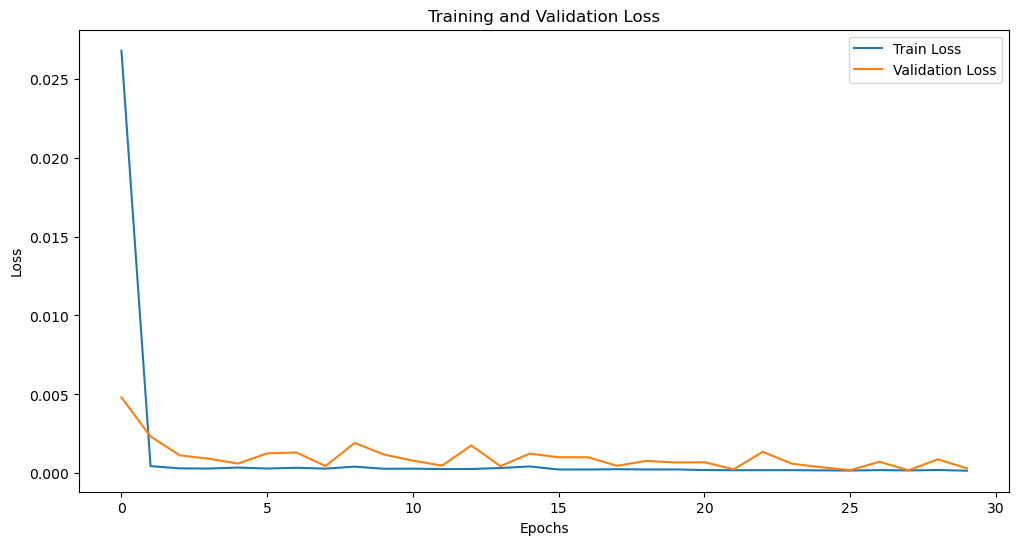

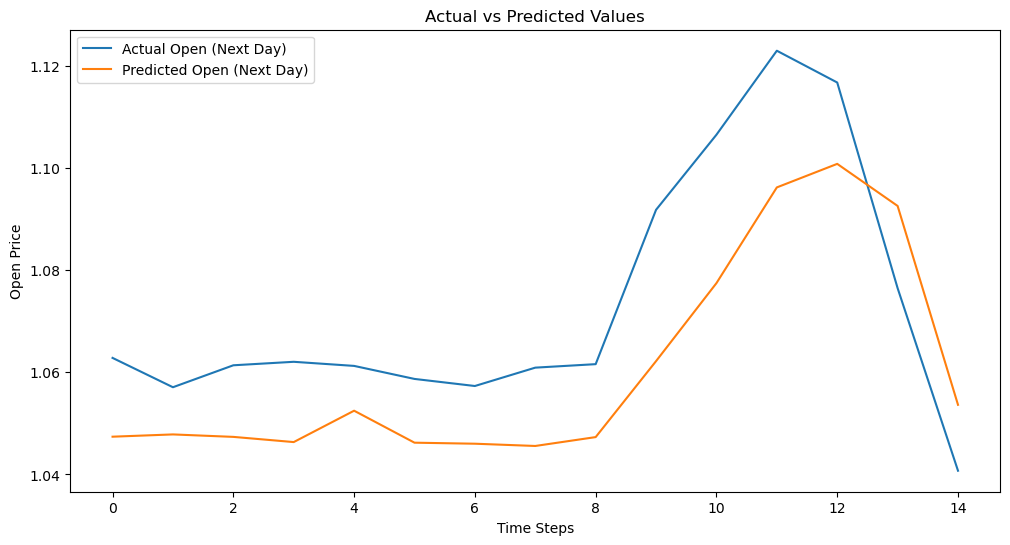

In [ ]:
# Plot training and Test loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test.flatten(), label='Actual Open (Next Day)')
plt.plot(test_predictions.flatten(), label='Predicted Open (Next Day)')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time Steps')
plt.ylabel('Open Price')
plt.legend()
plt.show()

#  2. Vanilla RNN baseline 

In [ ]:

N = 30  # Number of past days
M = 1   # Number of future days (predict the next day)

# Prepare the dataset for multivariate input
def create_sequences_multivariate(data, target_index, N, M):
    X, y = [], []
    for i in range(len(data) - N - M + 1):
        X.append(data[i:i+N, :])  # Past N days for all features
        y.append(data[i+N:i+N+M, target_index])  # Next M days' target feature
    return np.array(X), np.array(y)


In [ ]:
#  `train_set` and `validation_set` are DataFrames with columns: Open, High, Low, Close, Volume - multivariate
columns = ['Open', 'High', 'Low', 'Close', 'Volume']
train_data = train_set[columns].values  
val_data = validation_set[columns].values 

target_index = columns.index('Open')

# Create sequences for training and validation data
X_train, y_train = create_sequences_multivariate(train_data, target_index, N, M)
X_val, y_val = create_sequences_multivariate(val_data, target_index, N, M)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], X_val.shape[2]))

print(f"Training data shape: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Validation data shape: X_val={X_val.shape}, y_val={y_val.shape}")

# Vanilla RNN model
regressor = Sequential()
regressor.add(SimpleRNN(units=10, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])))
regressor.add(Dense(units=M))  

# Compile the model
regressor.compile(optimizer='SGD', loss='mean_squared_error')

# Train the model
history = regressor.fit(
    X_train, y_train,  
    epochs=50, batch_size=32,
    validation_data=(X_val, y_val),
    verbose=1
)

# Evaluation on validation data
val_predictions = regressor.predict(X_val)

y_val_flattened = y_val.flatten()
val_predictions_flattened = val_predictions.flatten()

# RMSE
val_rmse = sqrt(mean_squared_error(y_val_flattened, val_predictions_flattened))
print(f"Validation RMSE: {val_rmse:.4f}")


Training data shape: X_train=(976, 30, 5), y_train=(976, 1)
Validation data shape: X_val=(222, 30, 5), y_val=(222, 1)
Epoch 1/50
31/31 [==============================] - 1s 19ms/step - loss: 0.0466 - val_loss: 0.1861
Epoch 2/50
31/31 [==============================] - 1s 17ms/step - loss: 0.0191 - val_loss: 0.1287
Epoch 3/50
31/31 [==============================] - 0s 16ms/step - loss: 0.0149 - val_loss: 0.1040
Epoch 4/50
31/31 [==============================] - 1s 16ms/step - loss: 0.0125 - val_loss: 0.0828
Epoch 5/50
31/31 [==============================] - 1s 20ms/step - loss: 0.0109 - val_loss: 0.0610
Epoch 6/50
31/31 [==============================] - 1s 18ms/step - loss: 0.0096 - val_loss: 0.0504
Epoch 7/50
31/31 [==============================] - 1s 17ms/step - loss: 0.0086 - val_loss: 0.0466
Epoch 8/50
31/31 [==============================] - 1s 20ms/step - loss: 0.0079 - val_loss: 0.0378
Epoch 9/50
31/31 [==============================] - 1s 18ms/step - loss: 0.0072 - val_loss

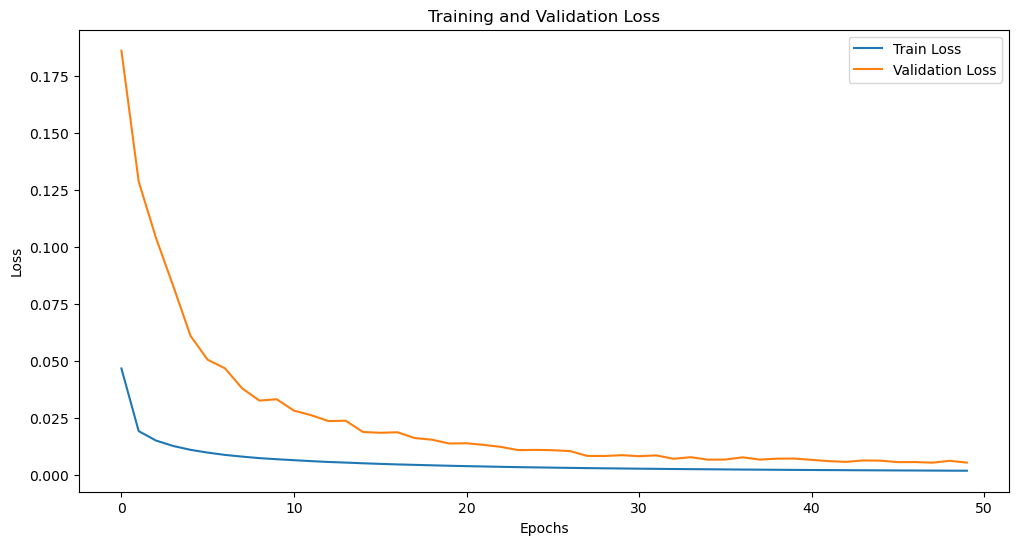

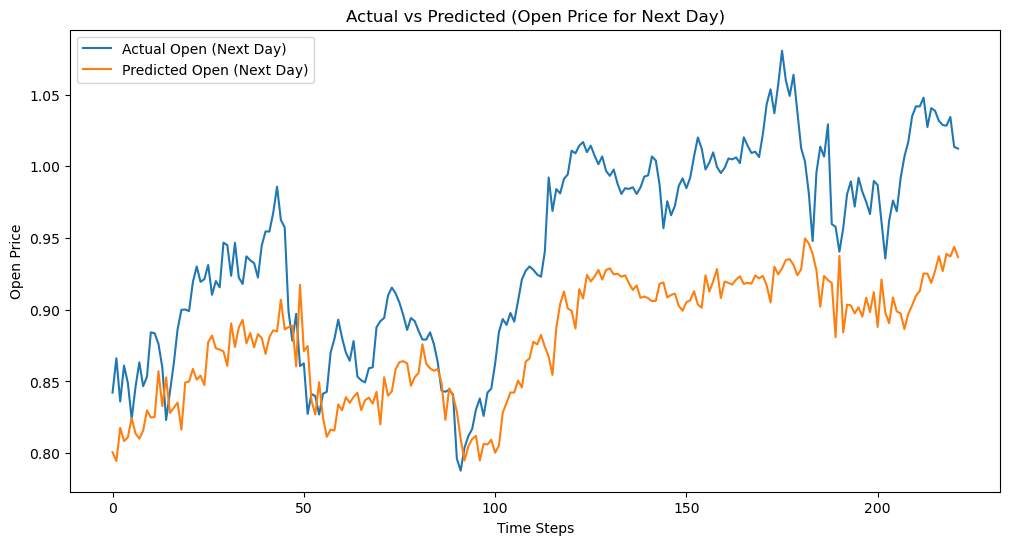

In [40]:
# Visualize training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Visualize actual vs. predicted for the 'Open' feature
plt.figure(figsize=(12, 6))
plt.plot(y_val_flattened, label='Actual Open (Next Day)')
plt.plot(val_predictions_flattened, label='Predicted Open (Next Day)')
plt.title('Actual vs Predicted (Open Price for Next Day)')
plt.xlabel('Time Steps')
plt.ylabel('Open Price')
plt.legend()
plt.show()


# Hyperparameter RNN

In [ ]:
#  multivariate sequences
def create_sequences_multivariate(data, target_index, N, M):

    X, y = [], []
    for i in range(len(data) - N - M + 1):
        X.append(data[i:i + N, :])  # Past N days for all features
        y.append(data[i + N:i + N + M, target_index])  # Next M days' target feature
    return np.array(X), np.array(y)

In [ ]:
N = 30  # Number of past days
M = 1   # Predict the next day

#  train_set and validation_set are DataFrames with the required columns-multivariate
columns = ['Open', 'High', 'Low', 'Close', 'Volume']
train_data = train_set[columns].values  
val_data = validation_set[columns].values 

target_index = columns.index('Open')

# Create sequences for training and validation
X_train, y_train = create_sequences_multivariate(train_data, target_index, N, M)
X_val, y_val = create_sequences_multivariate(val_data, target_index, N, M)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], X_val.shape[2]))

In [ ]:
# Vanilla RNN model
def create_model(input_shape, units, layers, activation, optimizer, learning_rate, output_units):
    model = Sequential()

    #  RNN layers
    for i in range(layers):
        if i == 0:
            model.add(SimpleRNN(units, activation=activation, return_sequences=(i < layers - 1), input_shape=input_shape))
        else:
            model.add(SimpleRNN(units, activation=activation, return_sequences=(i < layers - 1)))

    model.add(Dense(units=output_units))

    # optimizers
    if optimizer.lower() == 'sgd':
        opt = SGD(learning_rate=learning_rate)
    elif optimizer.lower() == 'adam':
        opt = Adam(learning_rate=learning_rate)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer}")

    # Compile the model
    model.compile(optimizer=opt, loss='mean_squared_error')
    return model

In [ ]:
# Optuna objective function
def objective(trial):
    #  hyperparameter search space
    units = trial.suggest_categorical("units", [20, 50, 100])
    layers = trial.suggest_int("layers", 1, 3)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
    optimizer = trial.suggest_categorical("optimizer", ["SGD", "Adam"])

    # Create the model
    model = create_model(
        input_shape=(X_train.shape[1], X_train.shape[2]),
        units=units,
        layers=layers,
        activation='tanh',
        optimizer=optimizer,
        learning_rate=learning_rate,
        output_units=M
    )

    # Train the model
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=0)
    history = model.fit(
        X_train, y_train,
        epochs=30,
        batch_size=32,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping],
        verbose=0  
    )

    # Evaluate the model
    val_predictions = model.predict(X_val)
    val_rmse = sqrt(mean_squared_error(y_val.flatten(), val_predictions.flatten()))
    return val_rmse

# Optuna optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

# Print the best parameters
print("\nBest Hyperparameters:")
print(study.best_params)
print(f"Best Validation RMSE: {study.best_value:.4f}")


[I 2024-11-24 21:27:32,002] A new study created in memory with name: no-name-2cbd5746-2b75-4bca-9c53-27a05a95e4af


7/7 [==============================] - 0s 9ms/step


[I 2024-11-24 21:27:51,187] Trial 0 finished with value: 0.02405036815269993 and parameters: {'units': 100, 'layers': 3, 'learning_rate': 0.0013706459704089572, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.02405036815269993.


7/7 [==============================] - 0s 15ms/step


[I 2024-11-24 21:28:56,922] Trial 1 finished with value: 0.22439266103346162 and parameters: {'units': 50, 'layers': 3, 'learning_rate': 0.00010699821871804677, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.02405036815269993.


7/7 [==============================] - 0s 8ms/step


[I 2024-11-24 21:29:24,256] Trial 2 finished with value: 0.018241684287971377 and parameters: {'units': 100, 'layers': 2, 'learning_rate': 0.008268297260375151, 'optimizer': 'Adam'}. Best is trial 2 with value: 0.018241684287971377.


7/7 [==============================] - 0s 5ms/step


[I 2024-11-24 21:29:40,929] Trial 3 finished with value: 0.2666271152124413 and parameters: {'units': 50, 'layers': 1, 'learning_rate': 0.0004308531285006986, 'optimizer': 'SGD'}. Best is trial 2 with value: 0.018241684287971377.


7/7 [==============================] - 0s 5ms/step


[I 2024-11-24 21:29:57,939] Trial 4 finished with value: 0.016420551974456604 and parameters: {'units': 50, 'layers': 1, 'learning_rate': 0.00030873765417678843, 'optimizer': 'Adam'}. Best is trial 4 with value: 0.016420551974456604.


7/7 [==============================] - 0s 10ms/step


[I 2024-11-24 21:30:59,821] Trial 5 finished with value: 0.04942729594779496 and parameters: {'units': 50, 'layers': 3, 'learning_rate': 0.0002929660722455674, 'optimizer': 'SGD'}. Best is trial 4 with value: 0.016420551974456604.


7/7 [==============================] - 0s 6ms/step


[I 2024-11-24 21:31:17,764] Trial 6 finished with value: 0.031237328393362344 and parameters: {'units': 100, 'layers': 2, 'learning_rate': 0.00679968822337567, 'optimizer': 'SGD'}. Best is trial 4 with value: 0.016420551974456604.


7/7 [==============================] - 0s 4ms/step


[I 2024-11-24 21:31:33,763] Trial 7 finished with value: 0.02533025851550132 and parameters: {'units': 20, 'layers': 1, 'learning_rate': 0.0025344199243099714, 'optimizer': 'Adam'}. Best is trial 4 with value: 0.016420551974456604.


7/7 [==============================] - 0s 6ms/step


[I 2024-11-24 21:31:45,640] Trial 8 finished with value: 0.020476207966291207 and parameters: {'units': 100, 'layers': 1, 'learning_rate': 0.00027189423891750504, 'optimizer': 'Adam'}. Best is trial 4 with value: 0.016420551974456604.


7/7 [==============================] - 0s 3ms/step


[I 2024-11-24 21:32:00,319] Trial 9 finished with value: 0.01686833464652299 and parameters: {'units': 50, 'layers': 1, 'learning_rate': 0.0005226732626644296, 'optimizer': 'Adam'}. Best is trial 4 with value: 0.016420551974456604.


7/7 [==============================] - 0s 7ms/step


[I 2024-11-24 21:32:39,478] Trial 10 finished with value: 0.0493983952984674 and parameters: {'units': 20, 'layers': 2, 'learning_rate': 0.00010617308689534494, 'optimizer': 'Adam'}. Best is trial 4 with value: 0.016420551974456604.


7/7 [==============================] - 0s 5ms/step


[I 2024-11-24 21:32:57,723] Trial 11 finished with value: 0.01701857316788475 and parameters: {'units': 50, 'layers': 1, 'learning_rate': 0.000686163871444238, 'optimizer': 'Adam'}. Best is trial 4 with value: 0.016420551974456604.


7/7 [==============================] - 0s 5ms/step


[I 2024-11-24 21:33:16,000] Trial 12 finished with value: 0.024310495534942744 and parameters: {'units': 50, 'layers': 1, 'learning_rate': 0.0012403760595516712, 'optimizer': 'Adam'}. Best is trial 4 with value: 0.016420551974456604.


7/7 [==============================] - 0s 5ms/step


[I 2024-11-24 21:33:33,742] Trial 13 finished with value: 0.02292955357925365 and parameters: {'units': 50, 'layers': 1, 'learning_rate': 0.00023976528321146222, 'optimizer': 'Adam'}. Best is trial 4 with value: 0.016420551974456604.


7/7 [==============================] - 0s 6ms/step


[I 2024-11-24 21:33:51,764] Trial 14 finished with value: 0.018870921943905078 and parameters: {'units': 50, 'layers': 2, 'learning_rate': 0.0006341856790819004, 'optimizer': 'Adam'}. Best is trial 4 with value: 0.016420551974456604.


7/7 [==============================] - 0s 6ms/step


[I 2024-11-24 21:34:09,134] Trial 15 finished with value: 0.01135648884089238 and parameters: {'units': 50, 'layers': 1, 'learning_rate': 0.002538320693650977, 'optimizer': 'Adam'}. Best is trial 15 with value: 0.01135648884089238.


7/7 [==============================] - 0s 8ms/step


[I 2024-11-24 21:34:47,100] Trial 16 finished with value: 0.015065564266801171 and parameters: {'units': 20, 'layers': 2, 'learning_rate': 0.004085053424789576, 'optimizer': 'Adam'}. Best is trial 15 with value: 0.01135648884089238.


7/7 [==============================] - 0s 10ms/step


[I 2024-11-24 21:35:07,221] Trial 17 finished with value: 0.01820065064819236 and parameters: {'units': 20, 'layers': 2, 'learning_rate': 0.003505646468088075, 'optimizer': 'Adam'}. Best is trial 15 with value: 0.01135648884089238.


7/7 [==============================] - 0s 9ms/step


[I 2024-11-24 21:35:50,319] Trial 18 finished with value: 0.08070696803214361 and parameters: {'units': 20, 'layers': 2, 'learning_rate': 0.0035673495341267485, 'optimizer': 'SGD'}. Best is trial 15 with value: 0.01135648884089238.


7/7 [==============================] - 0s 11ms/step


[I 2024-11-24 21:36:55,793] Trial 19 finished with value: 0.020108566584964585 and parameters: {'units': 20, 'layers': 3, 'learning_rate': 0.0021442551946174245, 'optimizer': 'Adam'}. Best is trial 15 with value: 0.01135648884089238.


7/7 [==============================] - 0s 7ms/step


[I 2024-11-24 21:37:25,725] Trial 20 finished with value: 0.016972382004854375 and parameters: {'units': 20, 'layers': 2, 'learning_rate': 0.004964376247095812, 'optimizer': 'Adam'}. Best is trial 15 with value: 0.01135648884089238.


7/7 [==============================] - 0s 4ms/step


[I 2024-11-24 21:37:40,410] Trial 21 finished with value: 0.015117256202056869 and parameters: {'units': 50, 'layers': 1, 'learning_rate': 0.0018636987656440469, 'optimizer': 'Adam'}. Best is trial 15 with value: 0.01135648884089238.


7/7 [==============================] - 0s 4ms/step


[I 2024-11-24 21:37:55,438] Trial 22 finished with value: 0.015506805336825531 and parameters: {'units': 50, 'layers': 1, 'learning_rate': 0.0018493533433033887, 'optimizer': 'Adam'}. Best is trial 15 with value: 0.01135648884089238.


7/7 [==============================] - 0s 5ms/step


[I 2024-11-24 21:38:06,053] Trial 23 finished with value: 0.025977460486278546 and parameters: {'units': 20, 'layers': 1, 'learning_rate': 0.003988545537206734, 'optimizer': 'Adam'}. Best is trial 15 with value: 0.01135648884089238.


7/7 [==============================] - 0s 8ms/step


[I 2024-11-24 21:38:42,220] Trial 24 finished with value: 0.018141921270083895 and parameters: {'units': 50, 'layers': 2, 'learning_rate': 0.0057660748501211275, 'optimizer': 'Adam'}. Best is trial 15 with value: 0.01135648884089238.


7/7 [==============================] - 0s 5ms/step


[I 2024-11-24 21:38:57,414] Trial 25 finished with value: 0.025696198190689013 and parameters: {'units': 20, 'layers': 1, 'learning_rate': 0.0009174080112592765, 'optimizer': 'Adam'}. Best is trial 15 with value: 0.01135648884089238.


7/7 [==============================] - 0s 8ms/step


[I 2024-11-24 21:39:32,882] Trial 26 finished with value: 0.048427892155243256 and parameters: {'units': 50, 'layers': 2, 'learning_rate': 0.0016636515346100207, 'optimizer': 'SGD'}. Best is trial 15 with value: 0.01135648884089238.


7/7 [==============================] - 0s 5ms/step


[I 2024-11-24 21:39:40,352] Trial 27 finished with value: 0.015582931806045882 and parameters: {'units': 50, 'layers': 1, 'learning_rate': 0.009791195247434976, 'optimizer': 'Adam'}. Best is trial 15 with value: 0.01135648884089238.


7/7 [==============================] - 0s 8ms/step


[I 2024-11-24 21:39:52,809] Trial 28 finished with value: 0.030465481868302776 and parameters: {'units': 100, 'layers': 2, 'learning_rate': 0.0027144784136530634, 'optimizer': 'Adam'}. Best is trial 15 with value: 0.01135648884089238.


7/7 [==============================] - 0s 16ms/step


[I 2024-11-24 21:41:00,251] Trial 29 finished with value: 0.019719378272256234 and parameters: {'units': 20, 'layers': 3, 'learning_rate': 0.001109515887398161, 'optimizer': 'Adam'}. Best is trial 15 with value: 0.01135648884089238.


7/7 [==============================] - 0s 10ms/step


[I 2024-11-24 21:42:07,446] Trial 30 finished with value: 0.01914638541270931 and parameters: {'units': 100, 'layers': 3, 'learning_rate': 0.0027075295512479234, 'optimizer': 'Adam'}. Best is trial 15 with value: 0.01135648884089238.


7/7 [==============================] - 0s 5ms/step


[I 2024-11-24 21:42:20,255] Trial 31 finished with value: 0.015738564294975783 and parameters: {'units': 50, 'layers': 1, 'learning_rate': 0.001686945205924378, 'optimizer': 'Adam'}. Best is trial 15 with value: 0.01135648884089238.


7/7 [==============================] - 0s 5ms/step


[I 2024-11-24 21:42:40,451] Trial 32 finished with value: 0.013437056005773308 and parameters: {'units': 50, 'layers': 1, 'learning_rate': 0.00175016699742541, 'optimizer': 'Adam'}. Best is trial 15 with value: 0.01135648884089238.


7/7 [==============================] - 0s 7ms/step


[I 2024-11-24 21:42:51,314] Trial 33 finished with value: 0.015019792631294878 and parameters: {'units': 50, 'layers': 1, 'learning_rate': 0.004674685343097242, 'optimizer': 'Adam'}. Best is trial 15 with value: 0.01135648884089238.


7/7 [==============================] - 0s 5ms/step


[I 2024-11-24 21:43:07,845] Trial 34 finished with value: 0.03028323802790795 and parameters: {'units': 50, 'layers': 1, 'learning_rate': 0.004253495311929561, 'optimizer': 'SGD'}. Best is trial 15 with value: 0.01135648884089238.


7/7 [==============================] - 0s 4ms/step


[I 2024-11-24 21:43:19,444] Trial 35 finished with value: 0.014827497780439243 and parameters: {'units': 50, 'layers': 1, 'learning_rate': 0.003125216779598682, 'optimizer': 'Adam'}. Best is trial 15 with value: 0.01135648884089238.


7/7 [==============================] - 0s 5ms/step


[I 2024-11-24 21:43:28,687] Trial 36 finished with value: 0.016173560110777998 and parameters: {'units': 50, 'layers': 1, 'learning_rate': 0.005761349644382372, 'optimizer': 'Adam'}. Best is trial 15 with value: 0.01135648884089238.


7/7 [==============================] - 0s 5ms/step


[I 2024-11-24 21:43:43,801] Trial 37 finished with value: 0.042063374747501846 and parameters: {'units': 50, 'layers': 1, 'learning_rate': 0.007488457460794275, 'optimizer': 'SGD'}. Best is trial 15 with value: 0.01135648884089238.


7/7 [==============================] - 0s 5ms/step


[I 2024-11-24 21:43:51,177] Trial 38 finished with value: 0.020944996877471412 and parameters: {'units': 50, 'layers': 1, 'learning_rate': 0.0029080779368162984, 'optimizer': 'Adam'}. Best is trial 15 with value: 0.01135648884089238.


7/7 [==============================] - 0s 4ms/step


[I 2024-11-24 21:44:02,919] Trial 39 finished with value: 0.013470487872180078 and parameters: {'units': 50, 'layers': 1, 'learning_rate': 0.0013834172543396568, 'optimizer': 'Adam'}. Best is trial 15 with value: 0.01135648884089238.


7/7 [==============================] - 0s 4ms/step


[I 2024-11-24 21:44:17,789] Trial 40 finished with value: 0.15166328927571351 and parameters: {'units': 50, 'layers': 1, 'learning_rate': 0.0009301242531932349, 'optimizer': 'SGD'}. Best is trial 15 with value: 0.01135648884089238.


7/7 [==============================] - 0s 6ms/step


[I 2024-11-24 21:44:32,704] Trial 41 finished with value: 0.02068727443530471 and parameters: {'units': 50, 'layers': 1, 'learning_rate': 0.0013433008385815009, 'optimizer': 'Adam'}. Best is trial 15 with value: 0.01135648884089238.


7/7 [==============================] - 0s 5ms/step


[I 2024-11-24 21:44:47,429] Trial 42 finished with value: 0.013692214773039092 and parameters: {'units': 50, 'layers': 1, 'learning_rate': 0.0021938600393955196, 'optimizer': 'Adam'}. Best is trial 15 with value: 0.01135648884089238.


7/7 [==============================] - 0s 5ms/step


[I 2024-11-24 21:45:01,153] Trial 43 finished with value: 0.016271402185165738 and parameters: {'units': 50, 'layers': 1, 'learning_rate': 0.0021620270391368257, 'optimizer': 'Adam'}. Best is trial 15 with value: 0.01135648884089238.


7/7 [==============================] - 0s 5ms/step


[I 2024-11-24 21:45:16,110] Trial 44 finished with value: 0.014907600165372575 and parameters: {'units': 50, 'layers': 1, 'learning_rate': 0.0014763363579521707, 'optimizer': 'Adam'}. Best is trial 15 with value: 0.01135648884089238.


7/7 [==============================] - 0s 5ms/step


[I 2024-11-24 21:45:27,432] Trial 45 finished with value: 0.016438656209584537 and parameters: {'units': 100, 'layers': 1, 'learning_rate': 0.002215767037883408, 'optimizer': 'Adam'}. Best is trial 15 with value: 0.01135648884089238.


7/7 [==============================] - 0s 4ms/step


[I 2024-11-24 21:45:35,032] Trial 46 finished with value: 0.02382709187880607 and parameters: {'units': 50, 'layers': 1, 'learning_rate': 0.0008094514388550258, 'optimizer': 'Adam'}. Best is trial 15 with value: 0.01135648884089238.


7/7 [==============================] - 0s 4ms/step


[I 2024-11-24 21:45:50,674] Trial 47 finished with value: 0.026296564420787497 and parameters: {'units': 50, 'layers': 1, 'learning_rate': 0.0032208784104785695, 'optimizer': 'Adam'}. Best is trial 15 with value: 0.01135648884089238.


7/7 [==============================] - 0s 5ms/step


[I 2024-11-24 21:46:02,944] Trial 48 finished with value: 0.012771789456144966 and parameters: {'units': 50, 'layers': 1, 'learning_rate': 0.0012360685785305643, 'optimizer': 'Adam'}. Best is trial 15 with value: 0.01135648884089238.


7/7 [==============================] - 0s 5ms/step


[I 2024-11-24 21:46:16,425] Trial 49 finished with value: 0.018308600200850112 and parameters: {'units': 50, 'layers': 1, 'learning_rate': 0.00046774647757781064, 'optimizer': 'Adam'}. Best is trial 15 with value: 0.01135648884089238.



Best Hyperparameters:
{'units': 50, 'layers': 1, 'learning_rate': 0.002538320693650977, 'optimizer': 'Adam'}
Best Validation RMSE: 0.0114


In [42]:
# Print the best parameters
print("\nBest Hyperparameters:")
print(study.best_params)
print(f"Best Validation RMSE: {study.best_value:.4f}")


Best Hyperparameters:
{'units': 50, 'layers': 1, 'learning_rate': 0.002538320693650977, 'optimizer': 'Adam'}
Best Validation RMSE: 0.0114


# Testing RNN

In [ ]:
# concatenate train and validation dataset retrain the model with the bestparameter and evaluate on the test set 
combined_data_vanilla_multivariate = np.concatenate([train_set, validation_set], axis=0)
combined_data_vanilla_multivariate = pd.DataFrame(combined_data_vanilla_multivariate, columns=['Date','Open', 'High', 'Low', 'Close', 'Volume'])

# MinMaxScaler
scaler = MinMaxScaler()

# Apply the transformation to the combined dataset
combined_data_vanilla_multivariate[columns_to_normalize] = scaler.fit_transform(combined_data_vanilla_multivariate[columns_to_normalize])


In [ ]:
def create_sequences_multivariate(data, target_index, N, M):
    X, y = [], []
    for i in range(len(data) - N - M + 1):
        X.append(data[i:i+N, :])  # Past N days for all features
        y.append(data[i+N:i+N+M, target_index])  # Next M days for target feature
    return np.array(X), np.array(y)


In [ ]:
N = 5  # Number of past days
M = 1  # Number of future days (predict the next day)

# Assuming `combined_data_vanilla_multivariate` and `test_data` are DataFrames with required columns - Multivariate test data
columns = ['Open', 'High', 'Low', 'Close', 'Volume']
combined_data_multivariate = combined_data_vanilla_multivariate[columns].values  
test_data_multivariate = test_data[columns].values  

# Target index (e.g., 'Open' is the target feature to predict)
target_index = columns.index('Open')

# Create sequences for training and testing
X_train, y_train = create_sequences_multivariate(combined_data_multivariate, target_index, N, M)
X_test, y_test = create_sequences_multivariate(test_data_multivariate, target_index, N, M)

# Reshape input to 3D for RNN
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))

In [ ]:
# Vanilla RNN model with best hyperparameters
def create_model(input_shape, units, layers, learning_rate):
    model = Sequential()
    for i in range(layers):
        if i == 0:
            model.add(SimpleRNN(units, activation='tanh', return_sequences=(i < layers - 1), input_shape=input_shape))
        else:
            model.add(SimpleRNN(units, activation='tanh', return_sequences=(i < layers - 1)))
    model.add(Dense(1))  # Predict next day's `Open` value
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    return model

# Best hyperparameters
best_params = {
    'units': 50,
    'layers': 1,
    'learning_rate': 0.002538320693650977,
}

units = best_params['units']
layers = best_params['layers']
learning_rate = best_params['learning_rate']

input_shape = (X_train.shape[1], X_train.shape[2])  
model = create_model(input_shape, units, layers, learning_rate)

# Train the model on the full combined dataset
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    verbose=1,
    validation_data=(X_test, y_test)
)

# Evaluate the model on the test set
test_predictions = model.predict(X_test)
test_rmse = sqrt(mean_squared_error(y_test.flatten(), test_predictions.flatten()))
print(f"Test RMSE: {test_rmse:.4f}")


Epoch 1/30
40/40 [==============================] - 1s 7ms/step - loss: 0.0470 - val_loss: 0.0025
Epoch 2/30
40/40 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 3/30
40/40 [==============================] - 0s 5ms/step - loss: 4.5504e-04 - val_loss: 0.0011
Epoch 4/30
40/40 [==============================] - 0s 5ms/step - loss: 4.0252e-04 - val_loss: 0.0013
Epoch 5/30
40/40 [==============================] - 0s 5ms/step - loss: 3.9844e-04 - val_loss: 0.0011
Epoch 6/30
40/40 [==============================] - 0s 4ms/step - loss: 3.4173e-04 - val_loss: 0.0010
Epoch 7/30
40/40 [==============================] - 0s 5ms/step - loss: 3.6186e-04 - val_loss: 0.0016
Epoch 8/30
40/40 [==============================] - 0s 5ms/step - loss: 3.4641e-04 - val_loss: 4.1192e-04
Epoch 9/30
40/40 [==============================] - 0s 4ms/step - loss: 3.7310e-04 - val_loss: 0.0011
Epoch 10/30
40/40 [==============================] - 0s 5ms/step - loss: 2.9798e-04 - 

In [49]:
# Evaluate the model on the test set
test_predictions = model.predict(X_test)

test_rmse = sqrt(mean_squared_error(y_test.flatten(), test_predictions.flatten()))
print(f"Test RMSE: {test_rmse:.4f}")

1/1 [==============================] - 0s 14ms/step
Test RMSE: 0.0113


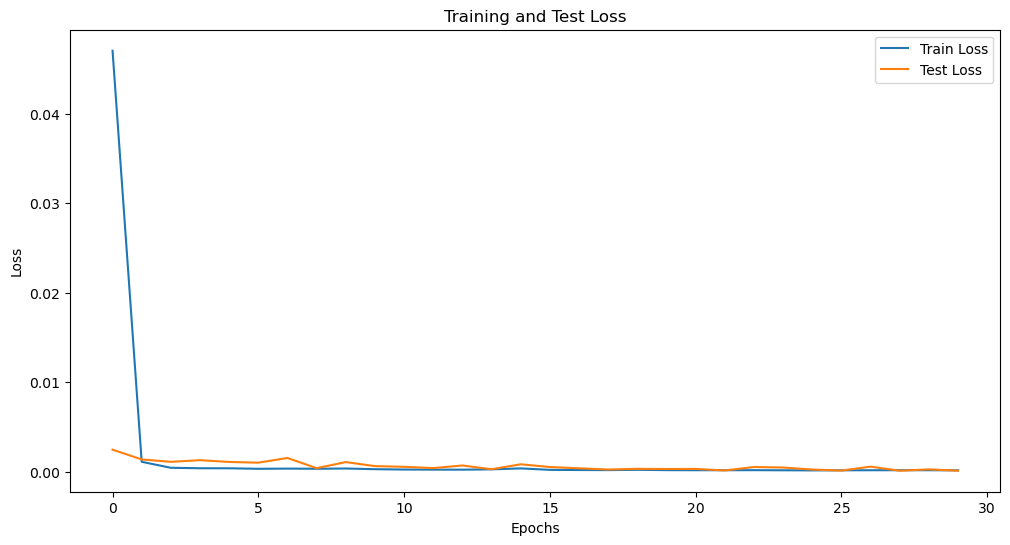

1/1 [==============================] - 0s 23ms/step


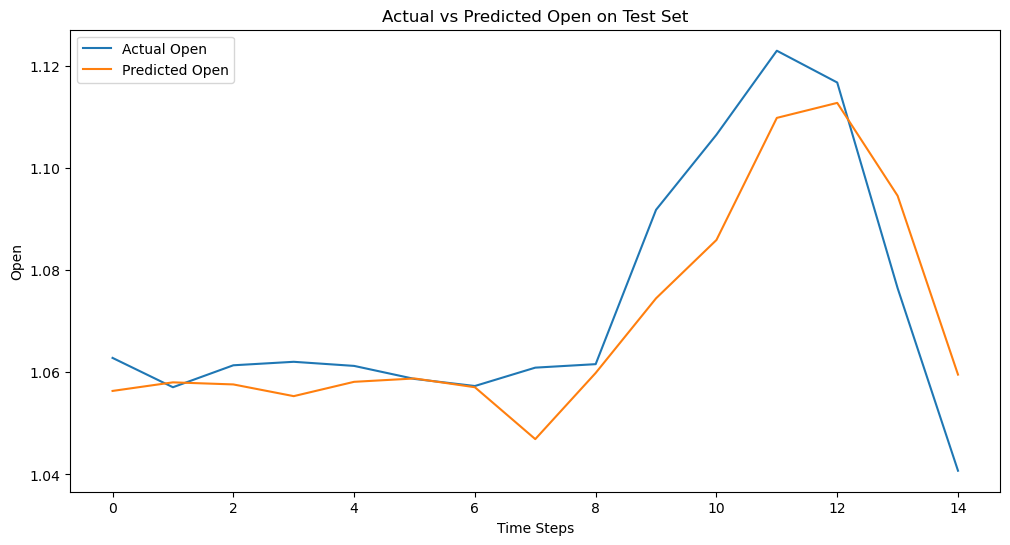

In [ ]:
# Plot training and test loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss') 
plt.title('Training and Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Generate predictions for the test set
test_predictions = model.predict(X_test)
# Plot actual vs. predicted values for the test set
plt.figure(figsize=(12, 6))
plt.plot(y_test.flatten(), label='Actual Open')
plt.plot(test_predictions.flatten(), label='Predicted Open')
plt.title('Actual vs Predicted Open on Test Set')
plt.xlabel('Time Steps')
plt.ylabel('Open')
plt.legend()
plt.show()


# 3. Baseline GRU

In [ ]:

N = 30  # Number of past days
M = 1   # Number of future days (predict the next day)

# the dataset for multivariate input
def create_sequences_multivariate(data, target_index, N, M):
    X, y = [], []
    for i in range(len(data) - N - M + 1):
        X.append(data[i:i+N, :]) 
        y.append(data[i+N:i+N+M, target_index]) 
    return np.array(X), np.array(y)

In [ ]:
# `train_set` and `validation_set` are DataFrames with required columns - multivariate
columns = ['Open', 'High', 'Low', 'Close', 'Volume']
train_data = train_set[columns].values  
val_data = validation_set[columns].values  
target_index = columns.index('Open')

# Create sequences for training and validation
X_train, y_train = create_sequences_multivariate(train_data, target_index, N, M)
X_val, y_val = create_sequences_multivariate(val_data, target_index, N, M)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], X_val.shape[2]))

print(f"Training data shape: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Validation data shape: X_val={X_val.shape}, y_val={y_val.shape}")

# Build the GRU model
regressor = Sequential()

# GRU layer
regressor.add(GRU(units=5, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])))
regressor.add(Dense(units=M))
regressor.compile(optimizer='Adam', loss='mean_squared_error')

# Train the model
history = regressor.fit(X_train, y_train, 
                        epochs=50, batch_size=32,
                        validation_data=(X_val, y_val),
                        verbose=1)

# Evaluate on validation data
val_predictions = regressor.predict(X_val)
y_val_flattened = y_val.flatten()
val_predictions_flattened = val_predictions.flatten()

#  RMSE
val_rmse = sqrt(mean_squared_error(y_val_flattened, val_predictions_flattened))
print(f"Validation RMSE: {val_rmse:.4f}")


Training data shape: X_train=(976, 30, 5), y_train=(976, 1)
Validation data shape: X_val=(222, 30, 5), y_val=(222, 1)
Epoch 1/50
31/31 [==============================] - 1s 11ms/step - loss: 0.2160 - val_loss: 0.5785
Epoch 2/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0650 - val_loss: 0.2239
Epoch 3/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0254 - val_loss: 0.1192
Epoch 4/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0182 - val_loss: 0.0940
Epoch 5/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0128 - val_loss: 0.0766
Epoch 6/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0085 - val_loss: 0.0579
Epoch 7/50
31/31 [==============================] - 0s 5ms/step - loss: 0.0053 - val_loss: 0.0432
Epoch 8/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0034 - val_loss: 0.0330
Epoch 9/50
31/31 [==============================] - 0s 5ms/step - loss: 0.0023 - val_loss: 0.0265

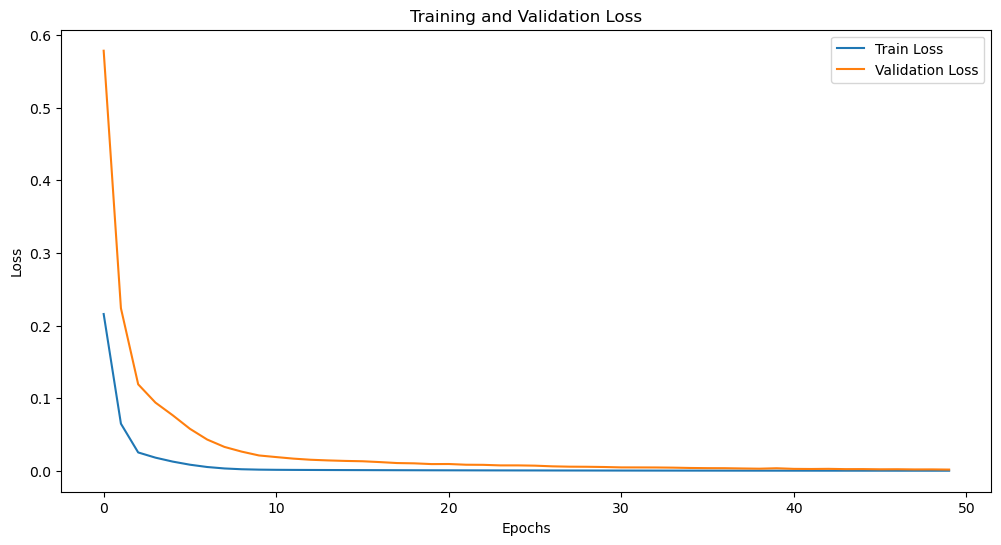

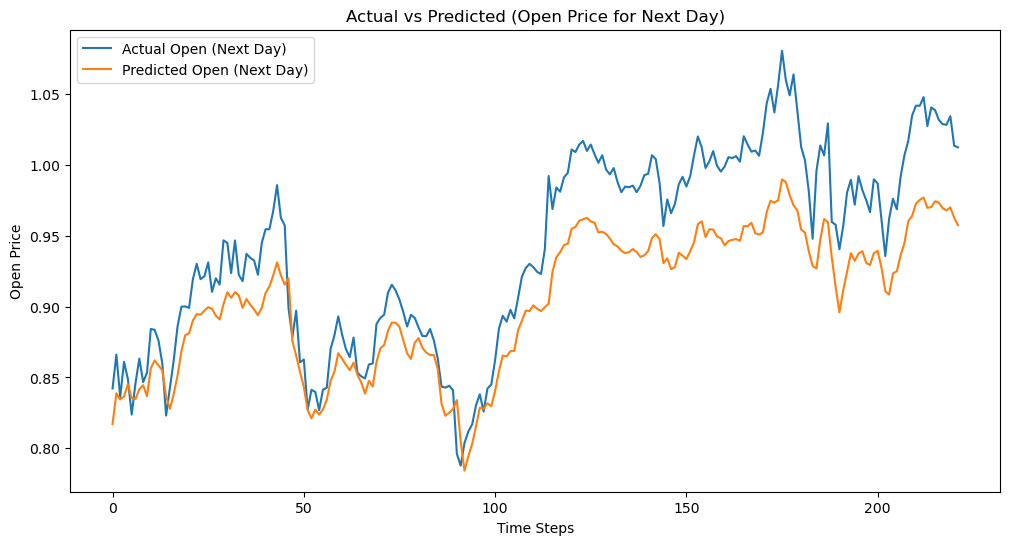

In [56]:
# Visualize training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Visualize actual vs. predicted for the 'Open' feature
plt.figure(figsize=(12, 6))
plt.plot(y_val_flattened, label='Actual Open (Next Day)')
plt.plot(val_predictions_flattened, label='Predicted Open (Next Day)')
plt.title('Actual vs Predicted (Open Price for Next Day)')
plt.xlabel('Time Steps')
plt.ylabel('Open Price')
plt.legend()
plt.show()

# Hyperparameter GRU

In [ ]:

N = 30  # Number of past days
M = 1   # Number of future days (predict the next day)

#  the dataset for multivariate input
def create_sequences_multivariate(data, target_index, N, M):
    X, y = [], []
    for i in range(len(data) - N - M + 1):
        X.append(data[i:i+N, :])  
        y.append(data[i+N:i+N+M, target_index])  
    return np.array(X), np.array(y)

In [ ]:

columns = ['Open', 'High', 'Low', 'Close', 'Volume']
train_data = train_set[columns].values  
val_data = validation_set[columns].values 

# Target index (e.g., 'Open' is the target feature to predict)
target_index = columns.index('Open')

#  sequences for training and validation
X_train, y_train = create_sequences_multivariate(train_data, target_index, N, M)
X_val, y_val = create_sequences_multivariate(val_data, target_index, N, M)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], X_val.shape[2]))

print(f"Training data shape: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Validation data shape: X_val={X_val.shape}, y_val={y_val.shape}")

# Optuna objective function
def objective(trial):
    # hyperparameter search space
    units = trial.suggest_categorical("units", [20, 50, 100])
    layers = trial.suggest_int("layers", 1, 3)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
    optimizer_name = trial.suggest_categorical("optimizer", ["SGD", "Adam"])
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])

    #   GRU model
    regressor = Sequential()
    for i in range(layers):
        if i == 0:  
            regressor.add(GRU(units=units, activation='tanh', return_sequences=(i < layers - 1), input_shape=(X_train.shape[1], X_train.shape[2])))
        else:
            regressor.add(GRU(units=units, activation='tanh', return_sequences=(i < layers - 1)))
    regressor.add(Dense(units=M)) 

    # optimizer
    if optimizer_name == "SGD":
        optimizer = SGD(learning_rate=learning_rate)
    else:
        optimizer = Adam(learning_rate=learning_rate)
    regressor.compile(optimizer=optimizer, loss='mean_squared_error')

    # Train the model
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=0)
    history = regressor.fit(
        X_train, y_train,
        epochs=30,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping],
        verbose=0  
    )

    # Evaluate the model
    val_predictions = regressor.predict(X_val)
    val_rmse = sqrt(mean_squared_error(y_val.flatten(), val_predictions.flatten()))
    return val_rmse

# Run Optuna optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

# Print the best parameters
print("\nBest Hyperparameters:")
print(study.best_params)
print(f"Best Validation RMSE: {study.best_value:.4f}")

# Train and Evaluate the Best Model
best_params = study.best_params
best_model = Sequential()
for i in range(best_params['layers']):
    if i == 0:  
        best_model.add(GRU(units=best_params['units'], activation='tanh', return_sequences=(i < best_params['layers'] - 1), input_shape=(X_train.shape[1], X_train.shape[2])))
    else:  
        best_model.add(GRU(units=best_params['units'], activation='tanh', return_sequences=(i < best_params['layers'] - 1)))
best_model.add(Dense(units=M))  # Output layer

# Configure optimizer
if best_params['optimizer'] == "SGD":
    optimizer = SGD(learning_rate=best_params['learning_rate'])
else:
    optimizer = Adam(learning_rate=best_params['learning_rate'])
best_model.compile(optimizer=optimizer, loss='mean_squared_error')


[I 2024-11-24 22:51:40,207] A new study created in memory with name: no-name-c6d0343b-f0a7-4d33-86a6-9ed5d8e13c4a


Training data shape: X_train=(976, 30, 5), y_train=(976, 1)
Validation data shape: X_val=(222, 30, 5), y_val=(222, 1)
7/7 [==============================] - 0s 4ms/step


[I 2024-11-24 22:51:46,575] Trial 0 finished with value: 0.03724852572526454 and parameters: {'units': 20, 'layers': 1, 'learning_rate': 0.008268135995273316, 'optimizer': 'SGD', 'batch_size': 32}. Best is trial 0 with value: 0.03724852572526454.


7/7 [==============================] - 0s 5ms/step


[I 2024-11-24 22:52:08,277] Trial 1 finished with value: 0.1091747663406428 and parameters: {'units': 50, 'layers': 3, 'learning_rate': 0.0010210525484470416, 'optimizer': 'SGD', 'batch_size': 16}. Best is trial 0 with value: 0.03724852572526454.


7/7 [==============================] - 0s 5ms/step


[I 2024-11-24 22:52:32,402] Trial 2 finished with value: 0.06345343432360492 and parameters: {'units': 50, 'layers': 3, 'learning_rate': 0.0015079210109619164, 'optimizer': 'SGD', 'batch_size': 16}. Best is trial 0 with value: 0.03724852572526454.


7/7 [==============================] - 0s 3ms/step


[I 2024-11-24 22:52:38,576] Trial 3 finished with value: 0.02102668435152142 and parameters: {'units': 50, 'layers': 1, 'learning_rate': 0.0001712140761613031, 'optimizer': 'Adam', 'batch_size': 32}. Best is trial 3 with value: 0.02102668435152142.


7/7 [==============================] - 0s 3ms/step


[I 2024-11-24 22:52:54,195] Trial 4 finished with value: 0.09612817427011382 and parameters: {'units': 100, 'layers': 2, 'learning_rate': 0.0005090202869405228, 'optimizer': 'SGD', 'batch_size': 16}. Best is trial 3 with value: 0.02102668435152142.


7/7 [==============================] - 0s 5ms/step


[I 2024-11-24 22:53:09,520] Trial 5 finished with value: 0.1215632215501586 and parameters: {'units': 20, 'layers': 2, 'learning_rate': 0.0008927768456642921, 'optimizer': 'SGD', 'batch_size': 16}. Best is trial 3 with value: 0.02102668435152142.


7/7 [==============================] - 0s 5ms/step


[I 2024-11-24 22:53:14,722] Trial 6 finished with value: 0.02491289745206028 and parameters: {'units': 50, 'layers': 3, 'learning_rate': 0.002359361893159384, 'optimizer': 'Adam', 'batch_size': 64}. Best is trial 3 with value: 0.02102668435152142.


7/7 [==============================] - 0s 2ms/step


[I 2024-11-24 22:53:24,475] Trial 7 finished with value: 0.029690107599331387 and parameters: {'units': 50, 'layers': 2, 'learning_rate': 0.00807440251492891, 'optimizer': 'SGD', 'batch_size': 32}. Best is trial 3 with value: 0.02102668435152142.


7/7 [==============================] - 0s 2ms/step


[I 2024-11-24 22:53:28,637] Trial 8 finished with value: 0.32251883083569544 and parameters: {'units': 20, 'layers': 1, 'learning_rate': 0.0009760165655557691, 'optimizer': 'SGD', 'batch_size': 64}. Best is trial 3 with value: 0.02102668435152142.


7/7 [==============================] - 0s 2ms/step


[I 2024-11-24 22:53:32,537] Trial 9 finished with value: 0.01717689177076428 and parameters: {'units': 50, 'layers': 1, 'learning_rate': 0.00020552555137346533, 'optimizer': 'Adam', 'batch_size': 64}. Best is trial 9 with value: 0.01717689177076428.


7/7 [==============================] - 0s 2ms/step


[I 2024-11-24 22:53:36,471] Trial 10 finished with value: 0.01693169041779199 and parameters: {'units': 100, 'layers': 1, 'learning_rate': 0.00010515476424886218, 'optimizer': 'Adam', 'batch_size': 64}. Best is trial 10 with value: 0.01693169041779199.


7/7 [==============================] - 0s 3ms/step


[I 2024-11-24 22:53:38,602] Trial 11 finished with value: 0.03695310213284481 and parameters: {'units': 100, 'layers': 1, 'learning_rate': 0.0001110983778870294, 'optimizer': 'Adam', 'batch_size': 64}. Best is trial 10 with value: 0.01693169041779199.


7/7 [==============================] - 0s 3ms/step


[I 2024-11-24 22:53:42,483] Trial 12 finished with value: 0.014217227182385375 and parameters: {'units': 100, 'layers': 1, 'learning_rate': 0.00026692746356108055, 'optimizer': 'Adam', 'batch_size': 64}. Best is trial 12 with value: 0.014217227182385375.


7/7 [==============================] - 0s 3ms/step


[I 2024-11-24 22:53:44,208] Trial 13 finished with value: 0.03491461808688389 and parameters: {'units': 100, 'layers': 1, 'learning_rate': 0.0003359992914715937, 'optimizer': 'Adam', 'batch_size': 64}. Best is trial 12 with value: 0.014217227182385375.


7/7 [==============================] - 0s 4ms/step


[I 2024-11-24 22:53:47,322] Trial 14 finished with value: 0.03262510957221602 and parameters: {'units': 100, 'layers': 2, 'learning_rate': 0.00010559377016177305, 'optimizer': 'Adam', 'batch_size': 64}. Best is trial 12 with value: 0.014217227182385375.


7/7 [==============================] - 0s 2ms/step


[I 2024-11-24 22:53:51,285] Trial 15 finished with value: 0.01631287884281006 and parameters: {'units': 100, 'layers': 1, 'learning_rate': 0.0003384490622971327, 'optimizer': 'Adam', 'batch_size': 64}. Best is trial 12 with value: 0.014217227182385375.


7/7 [==============================] - 0s 4ms/step


[I 2024-11-24 22:53:57,951] Trial 16 finished with value: 0.0138571815984144 and parameters: {'units': 100, 'layers': 2, 'learning_rate': 0.0003797613692697051, 'optimizer': 'Adam', 'batch_size': 64}. Best is trial 16 with value: 0.0138571815984144.


7/7 [==============================] - 0s 4ms/step


[I 2024-11-24 22:54:04,820] Trial 17 finished with value: 0.016518697032979583 and parameters: {'units': 100, 'layers': 2, 'learning_rate': 0.000512660818909381, 'optimizer': 'Adam', 'batch_size': 64}. Best is trial 16 with value: 0.0138571815984144.


7/7 [==============================] - 0s 5ms/step


[I 2024-11-24 22:54:11,460] Trial 18 finished with value: 0.012322861726459034 and parameters: {'units': 100, 'layers': 3, 'learning_rate': 0.003209013040380181, 'optimizer': 'Adam', 'batch_size': 64}. Best is trial 18 with value: 0.012322861726459034.


7/7 [==============================] - 0s 5ms/step


[I 2024-11-24 22:54:18,278] Trial 19 finished with value: 0.012999625556181702 and parameters: {'units': 100, 'layers': 3, 'learning_rate': 0.004486183533597632, 'optimizer': 'Adam', 'batch_size': 32}. Best is trial 18 with value: 0.012322861726459034.


7/7 [==============================] - 0s 6ms/step


[I 2024-11-24 22:54:27,608] Trial 20 finished with value: 0.011648097919043207 and parameters: {'units': 100, 'layers': 3, 'learning_rate': 0.004405073757418304, 'optimizer': 'Adam', 'batch_size': 32}. Best is trial 20 with value: 0.011648097919043207.


7/7 [==============================] - 0s 6ms/step


[I 2024-11-24 22:54:36,869] Trial 21 finished with value: 0.011147726968228884 and parameters: {'units': 100, 'layers': 3, 'learning_rate': 0.00410962066898203, 'optimizer': 'Adam', 'batch_size': 32}. Best is trial 21 with value: 0.011147726968228884.


7/7 [==============================] - 1s 7ms/step


[I 2024-11-24 22:54:49,064] Trial 22 finished with value: 0.010998420454410126 and parameters: {'units': 100, 'layers': 3, 'learning_rate': 0.0036164900549363107, 'optimizer': 'Adam', 'batch_size': 32}. Best is trial 22 with value: 0.010998420454410126.


7/7 [==============================] - 0s 4ms/step


[I 2024-11-24 22:54:59,727] Trial 23 finished with value: 0.011204654128185403 and parameters: {'units': 100, 'layers': 3, 'learning_rate': 0.00503087719628086, 'optimizer': 'Adam', 'batch_size': 32}. Best is trial 22 with value: 0.010998420454410126.


7/7 [==============================] - 0s 5ms/step


[I 2024-11-24 22:55:10,857] Trial 24 finished with value: 0.01093662810579207 and parameters: {'units': 100, 'layers': 3, 'learning_rate': 0.005002296406644276, 'optimizer': 'Adam', 'batch_size': 32}. Best is trial 24 with value: 0.01093662810579207.


7/7 [==============================] - 0s 6ms/step


[I 2024-11-24 22:55:24,613] Trial 25 finished with value: 0.013554700801666566 and parameters: {'units': 20, 'layers': 3, 'learning_rate': 0.0021238765938008247, 'optimizer': 'Adam', 'batch_size': 32}. Best is trial 24 with value: 0.01093662810579207.


7/7 [==============================] - 0s 7ms/step


[I 2024-11-24 22:55:35,774] Trial 26 finished with value: 0.011297809290547352 and parameters: {'units': 100, 'layers': 3, 'learning_rate': 0.006030507436978393, 'optimizer': 'Adam', 'batch_size': 32}. Best is trial 24 with value: 0.01093662810579207.


7/7 [==============================] - 0s 5ms/step


[I 2024-11-24 22:55:47,712] Trial 27 finished with value: 0.010895011006378056 and parameters: {'units': 100, 'layers': 3, 'learning_rate': 0.0030753216453236988, 'optimizer': 'Adam', 'batch_size': 32}. Best is trial 27 with value: 0.010895011006378056.


7/7 [==============================] - 0s 6ms/step


[I 2024-11-24 22:55:56,994] Trial 28 finished with value: 0.011292374263636717 and parameters: {'units': 100, 'layers': 3, 'learning_rate': 0.002668704188870485, 'optimizer': 'Adam', 'batch_size': 32}. Best is trial 27 with value: 0.010895011006378056.


7/7 [==============================] - 1s 7ms/step


[I 2024-11-24 22:56:08,138] Trial 29 finished with value: 0.013121931900752845 and parameters: {'units': 20, 'layers': 3, 'learning_rate': 0.009892503642007604, 'optimizer': 'Adam', 'batch_size': 32}. Best is trial 27 with value: 0.010895011006378056.


7/7 [==============================] - 0s 5ms/step


[I 2024-11-24 22:56:15,442] Trial 30 finished with value: 0.012539014364341008 and parameters: {'units': 100, 'layers': 2, 'learning_rate': 0.0016183574506070735, 'optimizer': 'Adam', 'batch_size': 32}. Best is trial 27 with value: 0.010895011006378056.


7/7 [==============================] - 1s 5ms/step


[I 2024-11-24 22:56:26,824] Trial 31 finished with value: 0.011403282093398547 and parameters: {'units': 100, 'layers': 3, 'learning_rate': 0.0037464353684649983, 'optimizer': 'Adam', 'batch_size': 32}. Best is trial 27 with value: 0.010895011006378056.


7/7 [==============================] - 1s 5ms/step


[I 2024-11-24 22:56:36,341] Trial 32 finished with value: 0.011171224840916365 and parameters: {'units': 100, 'layers': 3, 'learning_rate': 0.00621526508713797, 'optimizer': 'Adam', 'batch_size': 32}. Best is trial 27 with value: 0.010895011006378056.


7/7 [==============================] - 0s 5ms/step


[I 2024-11-24 22:56:51,610] Trial 33 finished with value: 0.010553382839363775 and parameters: {'units': 100, 'layers': 3, 'learning_rate': 0.001671221627947323, 'optimizer': 'Adam', 'batch_size': 32}. Best is trial 33 with value: 0.010553382839363775.


7/7 [==============================] - 1s 6ms/step


[I 2024-11-24 22:57:08,192] Trial 34 finished with value: 0.08224413883280446 and parameters: {'units': 100, 'layers': 3, 'learning_rate': 0.0012824691128498712, 'optimizer': 'SGD', 'batch_size': 32}. Best is trial 33 with value: 0.010553382839363775.


7/7 [==============================] - 0s 5ms/step


[I 2024-11-24 22:57:21,084] Trial 35 finished with value: 0.01256332323129021 and parameters: {'units': 100, 'layers': 3, 'learning_rate': 0.001605259400215636, 'optimizer': 'Adam', 'batch_size': 16}. Best is trial 33 with value: 0.010553382839363775.


7/7 [==============================] - 0s 7ms/step


[I 2024-11-24 22:57:36,282] Trial 36 finished with value: 0.09786997333661016 and parameters: {'units': 20, 'layers': 3, 'learning_rate': 0.002982531883190608, 'optimizer': 'SGD', 'batch_size': 32}. Best is trial 33 with value: 0.010553382839363775.


7/7 [==============================] - 1s 6ms/step


[I 2024-11-24 22:57:45,287] Trial 37 finished with value: 0.013475217088129118 and parameters: {'units': 50, 'layers': 3, 'learning_rate': 0.0020244834582682255, 'optimizer': 'Adam', 'batch_size': 32}. Best is trial 33 with value: 0.010553382839363775.


7/7 [==============================] - 0s 5ms/step


[I 2024-11-24 22:57:54,030] Trial 38 finished with value: 0.02366649180045126 and parameters: {'units': 100, 'layers': 2, 'learning_rate': 0.006853503864113817, 'optimizer': 'SGD', 'batch_size': 16}. Best is trial 33 with value: 0.010553382839363775.


7/7 [==============================] - 0s 6ms/step


[I 2024-11-24 22:58:00,833] Trial 39 finished with value: 0.032697346271447554 and parameters: {'units': 50, 'layers': 3, 'learning_rate': 0.0007726617843842089, 'optimizer': 'Adam', 'batch_size': 32}. Best is trial 33 with value: 0.010553382839363775.


7/7 [==============================] - 0s 4ms/step


[I 2024-11-24 22:58:11,827] Trial 40 finished with value: 0.014707942197050707 and parameters: {'units': 20, 'layers': 2, 'learning_rate': 0.0012734908812628977, 'optimizer': 'Adam', 'batch_size': 32}. Best is trial 33 with value: 0.010553382839363775.


7/7 [==============================] - 0s 5ms/step


[I 2024-11-24 22:58:22,571] Trial 41 finished with value: 0.011041290133808163 and parameters: {'units': 100, 'layers': 3, 'learning_rate': 0.0037710167304087594, 'optimizer': 'Adam', 'batch_size': 32}. Best is trial 33 with value: 0.010553382839363775.


7/7 [==============================] - 1s 7ms/step


[I 2024-11-24 22:58:31,915] Trial 42 finished with value: 0.0113554502895717 and parameters: {'units': 100, 'layers': 3, 'learning_rate': 0.0030465676797645632, 'optimizer': 'Adam', 'batch_size': 32}. Best is trial 33 with value: 0.010553382839363775.


7/7 [==============================] - 1s 6ms/step


[I 2024-11-24 22:58:44,793] Trial 43 finished with value: 0.011062570939747584 and parameters: {'units': 100, 'layers': 3, 'learning_rate': 0.002429008400538742, 'optimizer': 'Adam', 'batch_size': 32}. Best is trial 33 with value: 0.010553382839363775.


7/7 [==============================] - 0s 6ms/step


[I 2024-11-24 22:58:57,102] Trial 44 finished with value: 0.010868065567855328 and parameters: {'units': 100, 'layers': 3, 'learning_rate': 0.0035586699214046093, 'optimizer': 'Adam', 'batch_size': 16}. Best is trial 33 with value: 0.010553382839363775.


7/7 [==============================] - 0s 7ms/step


[I 2024-11-24 22:59:17,467] Trial 45 finished with value: 0.03662522171944065 and parameters: {'units': 100, 'layers': 3, 'learning_rate': 0.005235387679193291, 'optimizer': 'SGD', 'batch_size': 16}. Best is trial 33 with value: 0.010553382839363775.


7/7 [==============================] - 0s 6ms/step


[I 2024-11-24 22:59:36,281] Trial 46 finished with value: 0.011784187110713789 and parameters: {'units': 50, 'layers': 3, 'learning_rate': 0.0018264001982047676, 'optimizer': 'Adam', 'batch_size': 16}. Best is trial 33 with value: 0.010553382839363775.


7/7 [==============================] - 0s 6ms/step


[I 2024-11-24 22:59:48,433] Trial 47 finished with value: 0.010673490116217805 and parameters: {'units': 100, 'layers': 3, 'learning_rate': 0.007190936571218555, 'optimizer': 'Adam', 'batch_size': 16}. Best is trial 33 with value: 0.010553382839363775.


7/7 [==============================] - 0s 6ms/step


[I 2024-11-24 22:59:58,213] Trial 48 finished with value: 0.011823640884657429 and parameters: {'units': 100, 'layers': 3, 'learning_rate': 0.00808972204211629, 'optimizer': 'Adam', 'batch_size': 16}. Best is trial 33 with value: 0.010553382839363775.


7/7 [==============================] - 0s 4ms/step


[I 2024-11-24 23:00:07,996] Trial 49 finished with value: 0.026057162056512723 and parameters: {'units': 100, 'layers': 2, 'learning_rate': 0.00762280843874585, 'optimizer': 'SGD', 'batch_size': 16}. Best is trial 33 with value: 0.010553382839363775.



Best Hyperparameters:
{'units': 100, 'layers': 3, 'learning_rate': 0.001671221627947323, 'optimizer': 'Adam', 'batch_size': 32}
Best Validation RMSE: 0.0106


In [59]:
# Print the best parameters
print("\nBest Hyperparameters:")
print(study.best_params)
print(f"Best Validation RMSE: {study.best_value:.4f}")


Best Hyperparameters:
{'units': 100, 'layers': 3, 'learning_rate': 0.001671221627947323, 'optimizer': 'Adam', 'batch_size': 32}
Best Validation RMSE: 0.0106


# Testing GRU

In [ ]:
# concatenating validation and train dataset, retrain the model with bet parameters, evaluate on test dataset
combined_data_GRU_multivariate = np.concatenate([train_set, validation_set], axis=0)
combined_data_GRU_multivariate = pd.DataFrame(combined_data_GRU_multivariate, columns=['Date','Open', 'High', 'Low', 'Close', 'Volume'])

# MinMaxScaler
scaler = MinMaxScaler()

#  transformation to the combined dataset
combined_data_GRU_multivariate[columns_to_normalize] = scaler.fit_transform(combined_data_GRU_multivariate[columns_to_normalize])

In [ ]:
def create_sequences_multivariate(data, target_index, N, M):
    X, y = [], []
    for i in range(len(data) - N - M + 1):
        X.append(data[i:i+N, :])  
        y.append(data[i+N:i+N+M, target_index])  
    return np.array(X), np.array(y)

In [ ]:
N = 5  # Number of past days
M = 1  # Number of future days (predict the next day)

# Use all features for multivariate input
columns = ['Open', 'High', 'Low', 'Close', 'Volume']
combined_data_multivariate = combined_data_GRU_multivariate[columns].values 
test_data_multivariate = test_data[columns].values  

# Target index (e.g., 'Open' is the target feature to predict)
target_index = columns.index('Open')

# sequences from the combined data
X_train, y_train = create_sequences_multivariate(combined_data_multivariate, target_index, N=N, M=M)

# Prepare sequences for the test dataset
X_test, y_test = create_sequences_multivariate(test_data_multivariate, target_index, N=N, M=M)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))

In [ ]:
#  GRU model with best hyperparameters
def create_model(input_shape, units, layers, learning_rate):
    model = Sequential()
    for i in range(layers):
        if i == 0:
            model.add(GRU(units, activation='tanh', return_sequences=(i < layers - 1), input_shape=input_shape))
        else:
            model.add(GRU(units, activation='tanh', return_sequences=(i < layers - 1)))
    model.add(Dense(1))  
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse')
    return model

# Best hyperparameters
best_params = {
    'units': 100,
    'layers': 3,
    'learning_rate': 0.001671221627947323,
    'batch_size': 32,
}

units = best_params['units']
layers = best_params['layers']
learning_rate = best_params['learning_rate']
batch_size = best_params['batch_size']


input_shape = (X_train.shape[1], X_train.shape[2]) 
model = create_model(input_shape, units, layers, learning_rate)

# Train the model on the full combined dataset
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=batch_size,
    verbose=1,
    validation_data=(X_test, y_test)
)

Epoch 1/30
40/40 [==============================] - 2s 16ms/step - loss: 0.0200 - val_loss: 0.0065
Epoch 2/30
40/40 [==============================] - 0s 6ms/step - loss: 6.4732e-04 - val_loss: 0.0030
Epoch 3/30
40/40 [==============================] - 0s 6ms/step - loss: 5.0035e-04 - val_loss: 0.0022
Epoch 4/30
40/40 [==============================] - 0s 7ms/step - loss: 4.6847e-04 - val_loss: 9.3576e-04
Epoch 5/30
40/40 [==============================] - 0s 7ms/step - loss: 5.7111e-04 - val_loss: 6.4377e-04
Epoch 6/30
40/40 [==============================] - 0s 7ms/step - loss: 4.6111e-04 - val_loss: 0.0012
Epoch 7/30
40/40 [==============================] - 0s 7ms/step - loss: 5.1642e-04 - val_loss: 9.7859e-04
Epoch 8/30
40/40 [==============================] - 0s 7ms/step - loss: 4.5707e-04 - val_loss: 0.0013
Epoch 9/30
40/40 [==============================] - 0s 7ms/step - loss: 6.3252e-04 - val_loss: 0.0012
Epoch 10/30
40/40 [==============================] - 0s 6ms/step - loss: 

In [ ]:
# Evaluate the model on the test set
test_predictions = model.predict(X_test)
test_rmse = sqrt(mean_squared_error(y_test.flatten(), test_predictions.flatten()))
print(f"Test RMSE: {test_rmse:.4f}")

1/1 [==============================] - 1s 505ms/step
Test RMSE: 0.0139


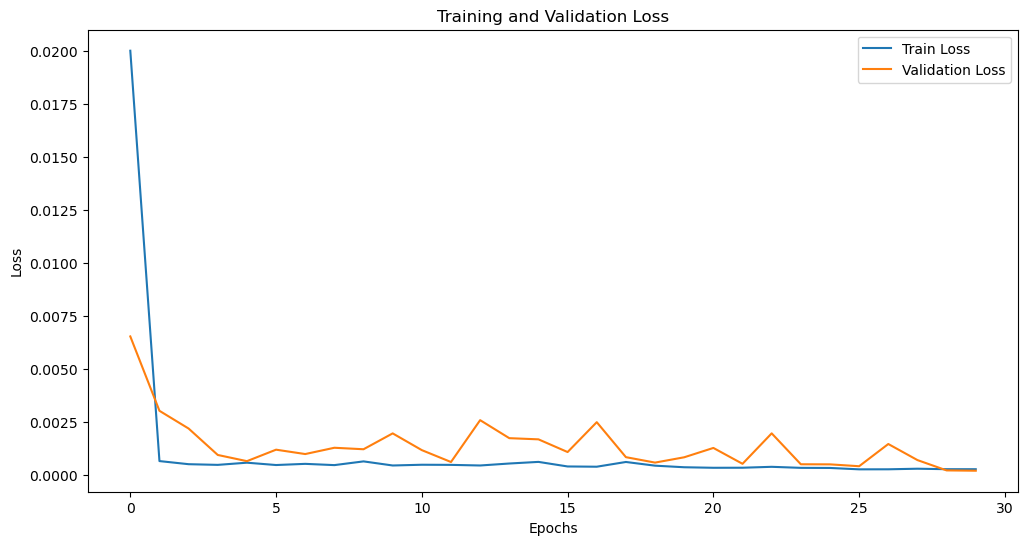

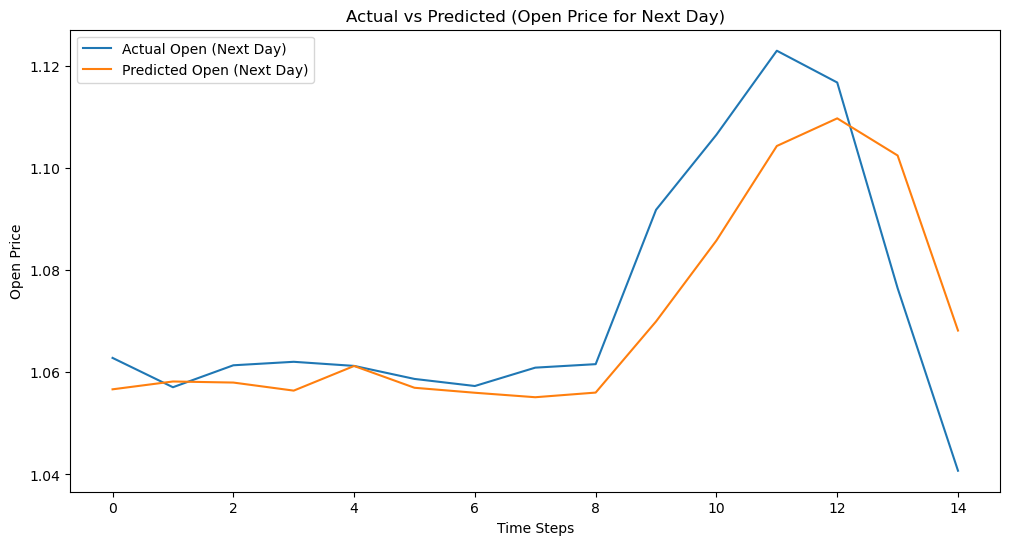

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test.flatten(), label='Actual Open (Next Day)')
plt.plot(test_predictions.flatten(), label='Predicted Open (Next Day)')
plt.title('Actual vs Predicted (Open Price for Next Day)')
plt.xlabel('Time Steps')
plt.ylabel('Open Price')
plt.legend()
plt.show()


# Findings

UNIVARIATE MODEL RMSE:

LSTM = 0.0246

Vanilla RNN = 0.0216

GRU = 0.0167

MULTIVARIATE MODEL RMSE:

LSTM = 0.0177

Vanilla RNN = 0.0113

GRU = 0.0139


From the study of experiment trials, it is noted that GRU performs best among all models in univariate stock price prediction, showing a Test RMSE of 0.0167, capturing temporal dependencies and being efficient in computations. Vanilla RNN, with a Test RMSE of 0.0113, proved to perform the best in multivariate predictions. Relying on simple architecture without overfitting and being effective on feature-rich data, it is the best in terms of Test error RMSE. LSTM is fair in both cases but not preferred over GRU and Vanilla RNN on the count of higher computational cost and slightly higher RMSE. In summary, GRU is the best for univariate cases and Vanilla RNN is the best-fit for multivariate data, hence both models will be appropriate in their respective contexts. These findings illustrate how well these approaches compete in terms of reliability and cost-efficiency for stock price predictions.

# Reference

1) A. Tam, “LSTM for Time Series Prediction in PyTorch - MachineLearningMastery.com,” MachineLearningMastery.com, Mar. 10, 2023. https://machinelearningmastery.com/lstm-for-time-series-prediction-in-pytorch/ (accessed Dec. 07, 2024).

2) R. Adusumilli, “Predicting Stock Prices Using a Keras LSTM Model,” Medium, Jan. 29, 2020. https://towardsdatascience.com/predicting-stock-prices-using-a-keras-lstm-model-4225457f0233

3) “Google stock price prediction using RNN - LSTM Python,” InfinityCodeX, https://www.infinitycodex.in/2020/07/google-stock-price-prediction-using-rnn.html (accessed Dec. 7, 2024). 

4) akhileshrai, “Tutorial - Early Stopping - Vanilla RNN - PyTorch,” Kaggle.com, Jan. 07, 2020. https://www.kaggle.com/code/akhileshrai/tutorial-early-stopping-vanilla-rnn-pytorch (accessed Dec. 07, 2024).
‌
5) A. Verma, “Pytorch [Basics] — Intro to RNN - Towards Data Science,” Medium, Feb. 15, 2020. https://towardsdatascience.com/pytorch-basics-how-to-train-your-neural-net-intro-to-rnn-cb6ebc594677 (accessed Dec. 07, 2024).

6) C. Parker, “Is hidden and output the same for a GRU unit in Pytorch?,” Stack Overflow, Jun. 19, 2019. https://stackoverflow.com/questions/56677052/is-hidden-and-output-the-same-for-a-gru-unit-in-pytorch

7) Rahul, “Gooogle Stock Price,” Kaggle.com, 2019. https://www.kaggle.com/datasets/rahulsah06/gooogle-stock-price (accessed Dec. 06, 2024).
‌
‌
‌
‌